# Starting with MM system

In [53]:
# from numpy import*
from pylab import*
import matplotlib.pyplot as plt
from h5py import File
import pandas as pd
from slab.dsfit import*
import seaborn as sns
# from slab import*
import json
import numpy as np
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from h5py import File
import os
from slab.dataanalysis import get_next_filename
import math
import scipy.special
from scipy.stats import poisson

# Fit functions

In [2]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def storage_t1(t, a, k):
    alpha = alpha_awg_cal(cav_amp=cav_amp, cav_len=cav_len)
    return a*np.exp(-alpha**2*np.exp(-k*t))

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y

def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, N))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0], np.sqrt(pcov[0][0])

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def decaysin_ramsey(x, a, b, c, d, e, f):
    """p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)*np.e**(-1.*(x-p[5])/p[3])+p[4]"""
    return a*np.sin(2.*np.pi*b*x+c*np.pi/180.)*np.exp(-1.*(x-f)/d)+e

def gauss(x, mu, sigma, a):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def bimodal(x, mu1, sigma1, a1, mu2, sigma2, a2):
    return gauss(x, mu1, sigma1, a1) + gauss(x, mu2, sigma2, a2)

def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
    ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        popt, pcov = curve_fit(bimodal, xdata=binsg[:-1], ydata=ng, p0=None)
        mu_g = popt[0]
        axs[2].plot(binsg, bimodal(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        popt, pcov = curve_fit(bimodal, xdata=binse[:-1], ydata=ne, p0=None)
        mu_e = popt[3]
        axs[2].plot(binse, bimodal(binse, *popt), 'k--', linewidth=2 )
#         axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)
        axs[2].set_xlabel('I(a.u.)')        
        axs[2].set_title('F = %.3f'%fid)
        fig.show()
        
    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)

def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

# Storage lifetimes

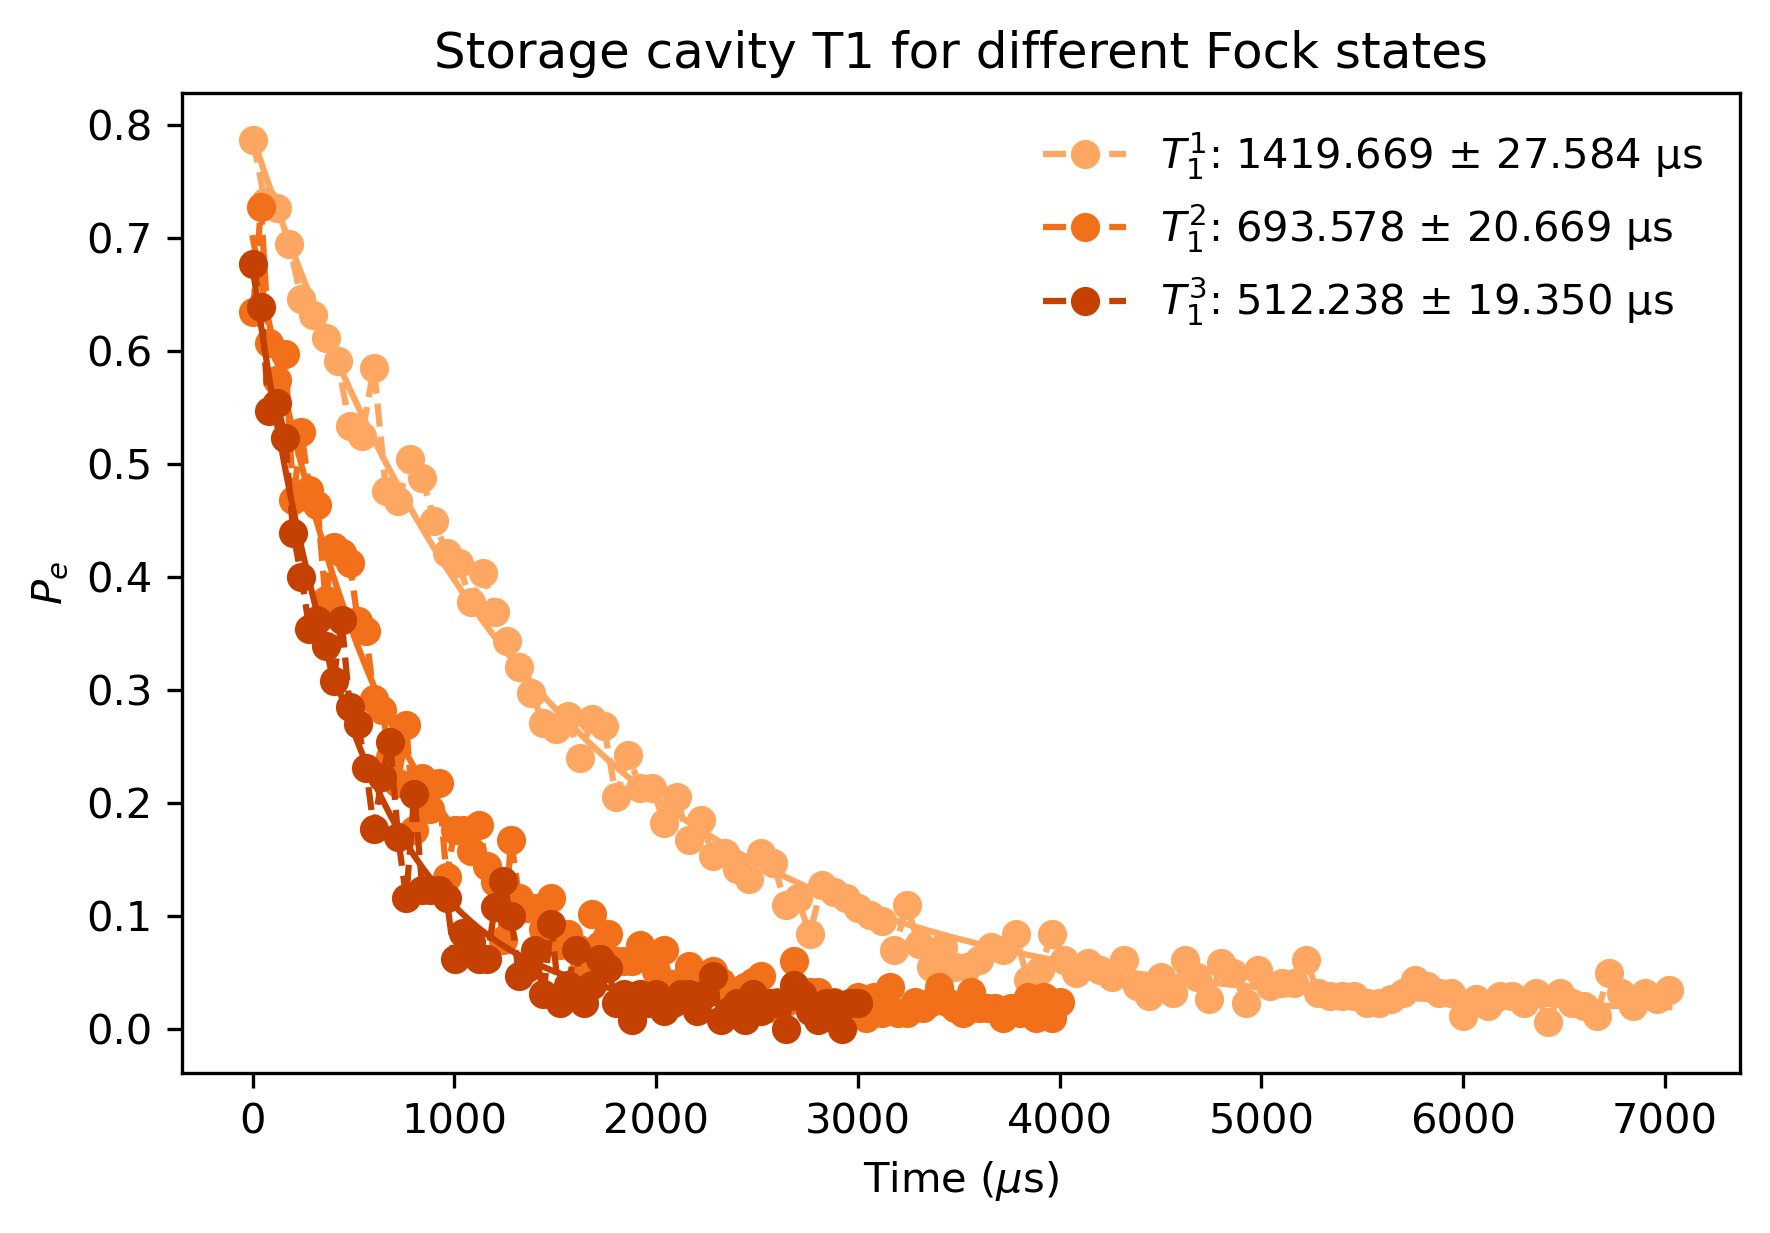

In [5]:
expt_name = 'storage_t1'
filelist = [21, 25, 23]
fig, ax = plt.subplots(1, 1, dpi=300)
cmap  = plt.get_cmap("Oranges")
colors = cmap([0.2, 0.4, 0.6, 0.8])

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        
        y = Q

        popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1000, 0))
        ax.plot(x, y, 'o--', color=colors[ii+1], label=r"$T_{1}^{%.f}$: %.3f $\pm$ %.3f μs"%(ii+1,popt[1], np.sqrt(np.diag(pcov)[1])))
        ax.plot(x, expfunc_baseline(x, *popt), color=colors[ii+1])
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel(r'$P_{e}$')
        ax.legend(frameon=False)

fig.tight_layout()
plt.title('Storage cavity T1 for different Fock states')
plt.show()


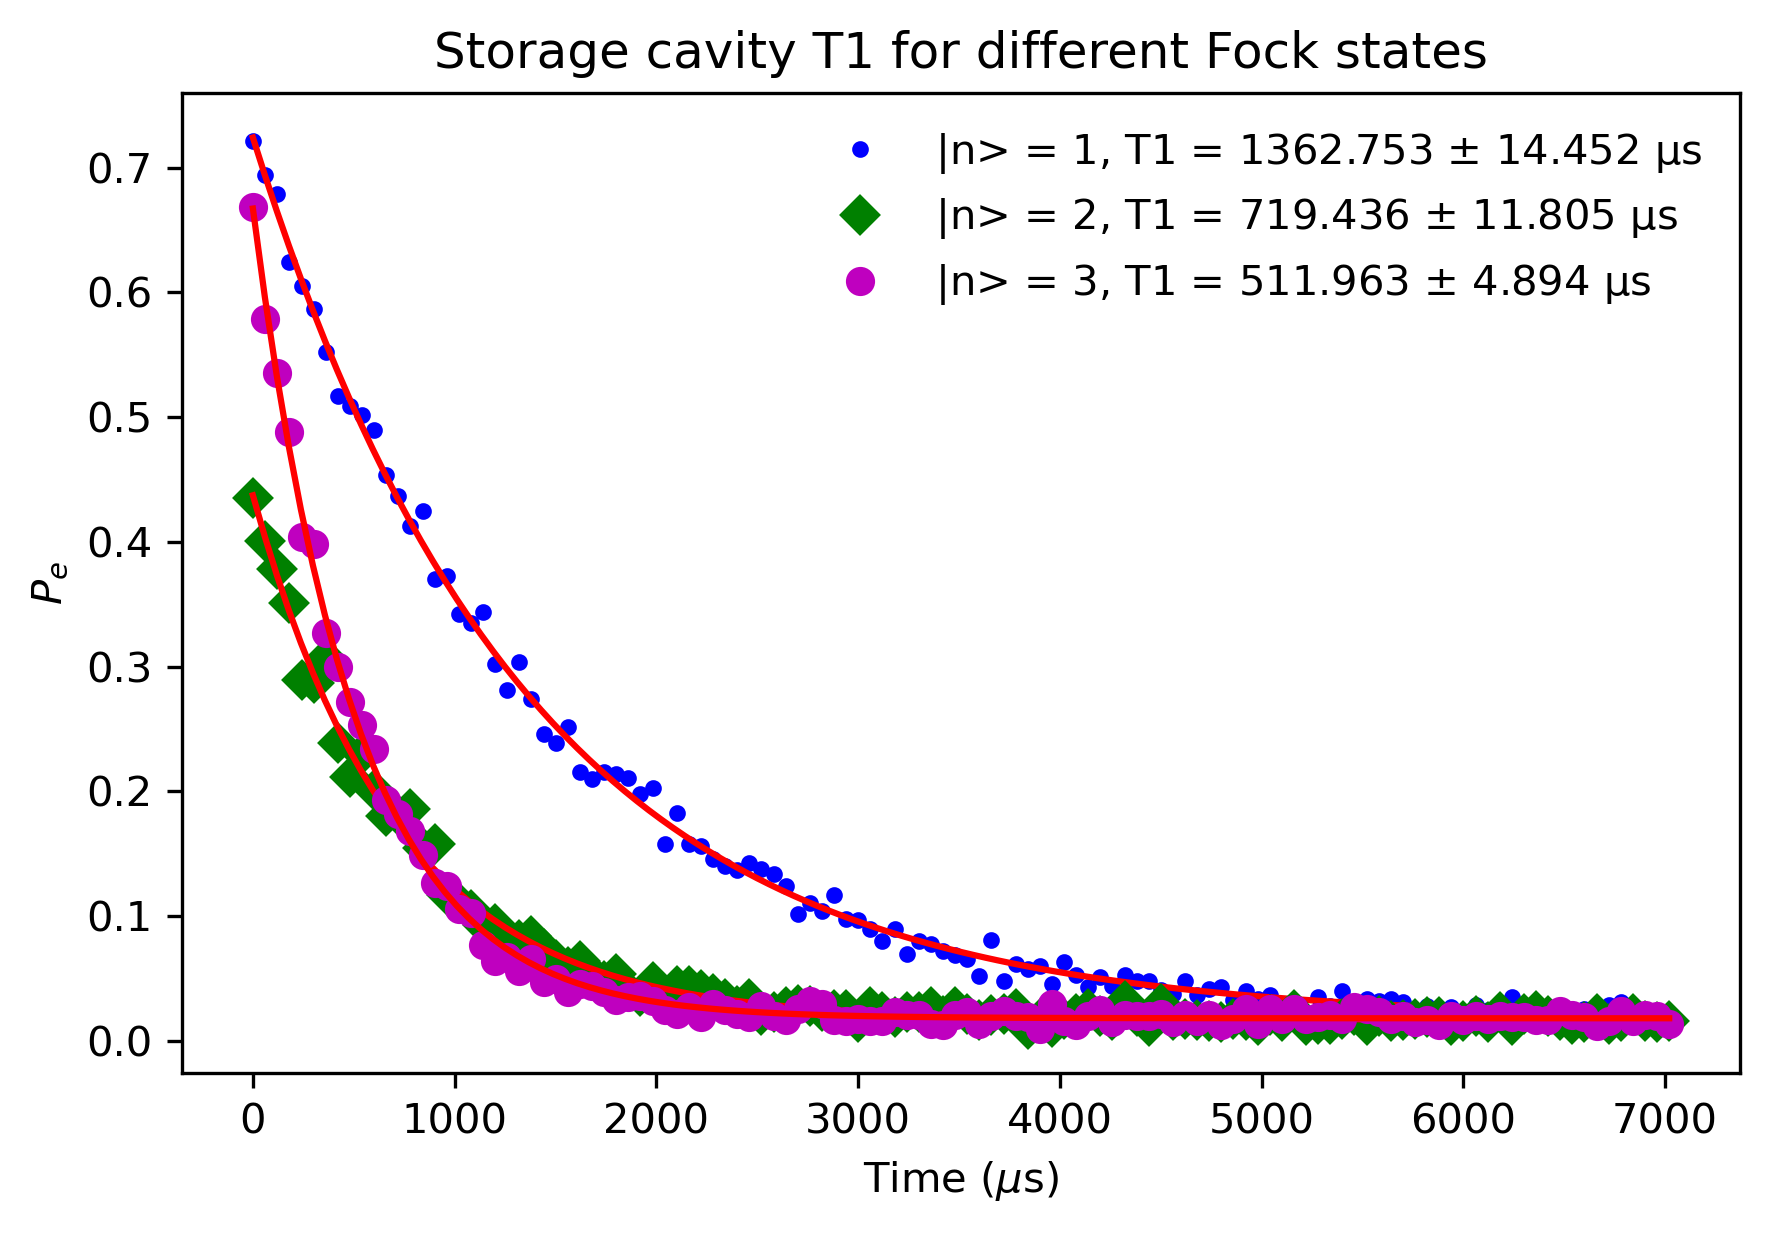

In [3]:
expt_name = 'storage_t1'
filelist = [1, 2, 3]
fig, ax = plt.subplots(1, 1, dpi=300)

marker = ['b.', 'gD', 'mo', 'y*']
for ii, i in enumerate(filelist):
    filename = "..\\data\\thesis\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        
        y = Q
        
        x_fit = np.linspace(0, np.max(x), len(x)+1)

        popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1000, 0))
        ax.plot(x, y, marker[ii], label=r"|n> = {}, T1 = {:.3f} $\pm$ {:.3f} μs".format(ii+1, popt[1], np.sqrt(np.diag(pcov)[1])))
        ax.plot(x_fit, expfunc_baseline(x_fit, *popt), 'r-' )
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel(r'$P_{e}$')

ax.legend(loc='best', frameon=False)
fig.tight_layout()
plt.title('Storage cavity T1 for different Fock states')
# plt.savefig('../plots/20210604-Storage-T1decay_Fock.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

# QNDness Pi + Readout

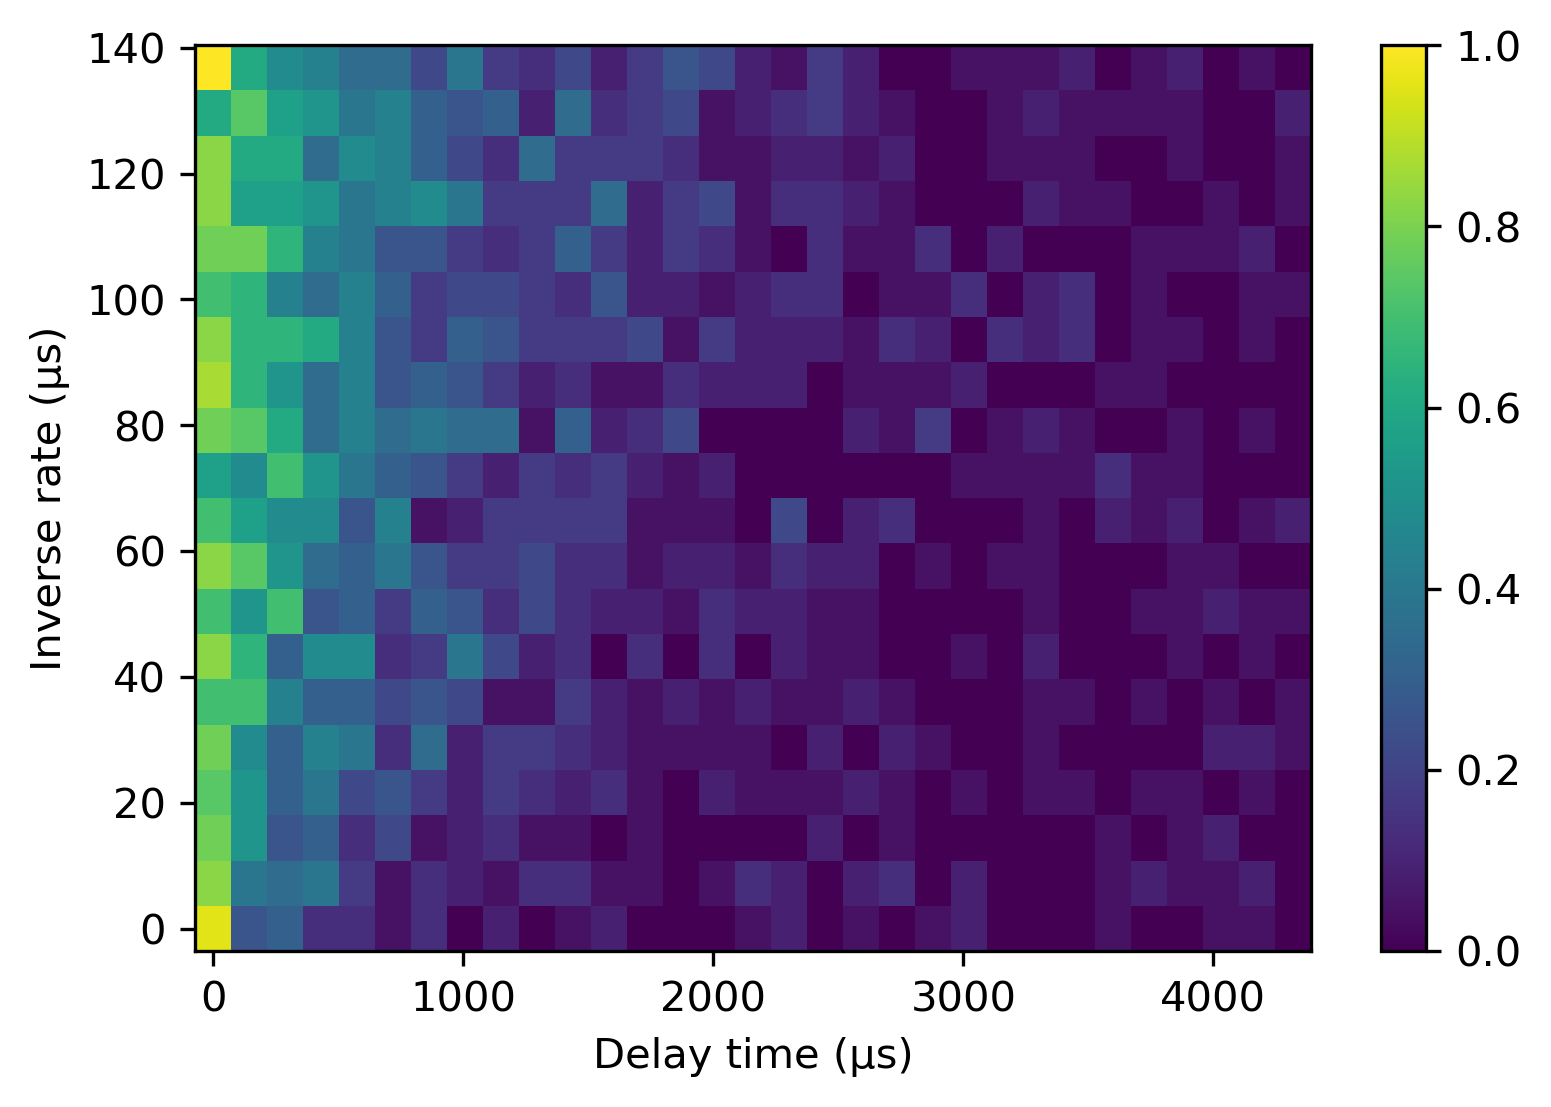

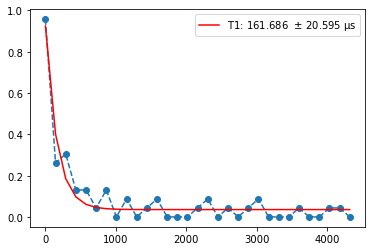

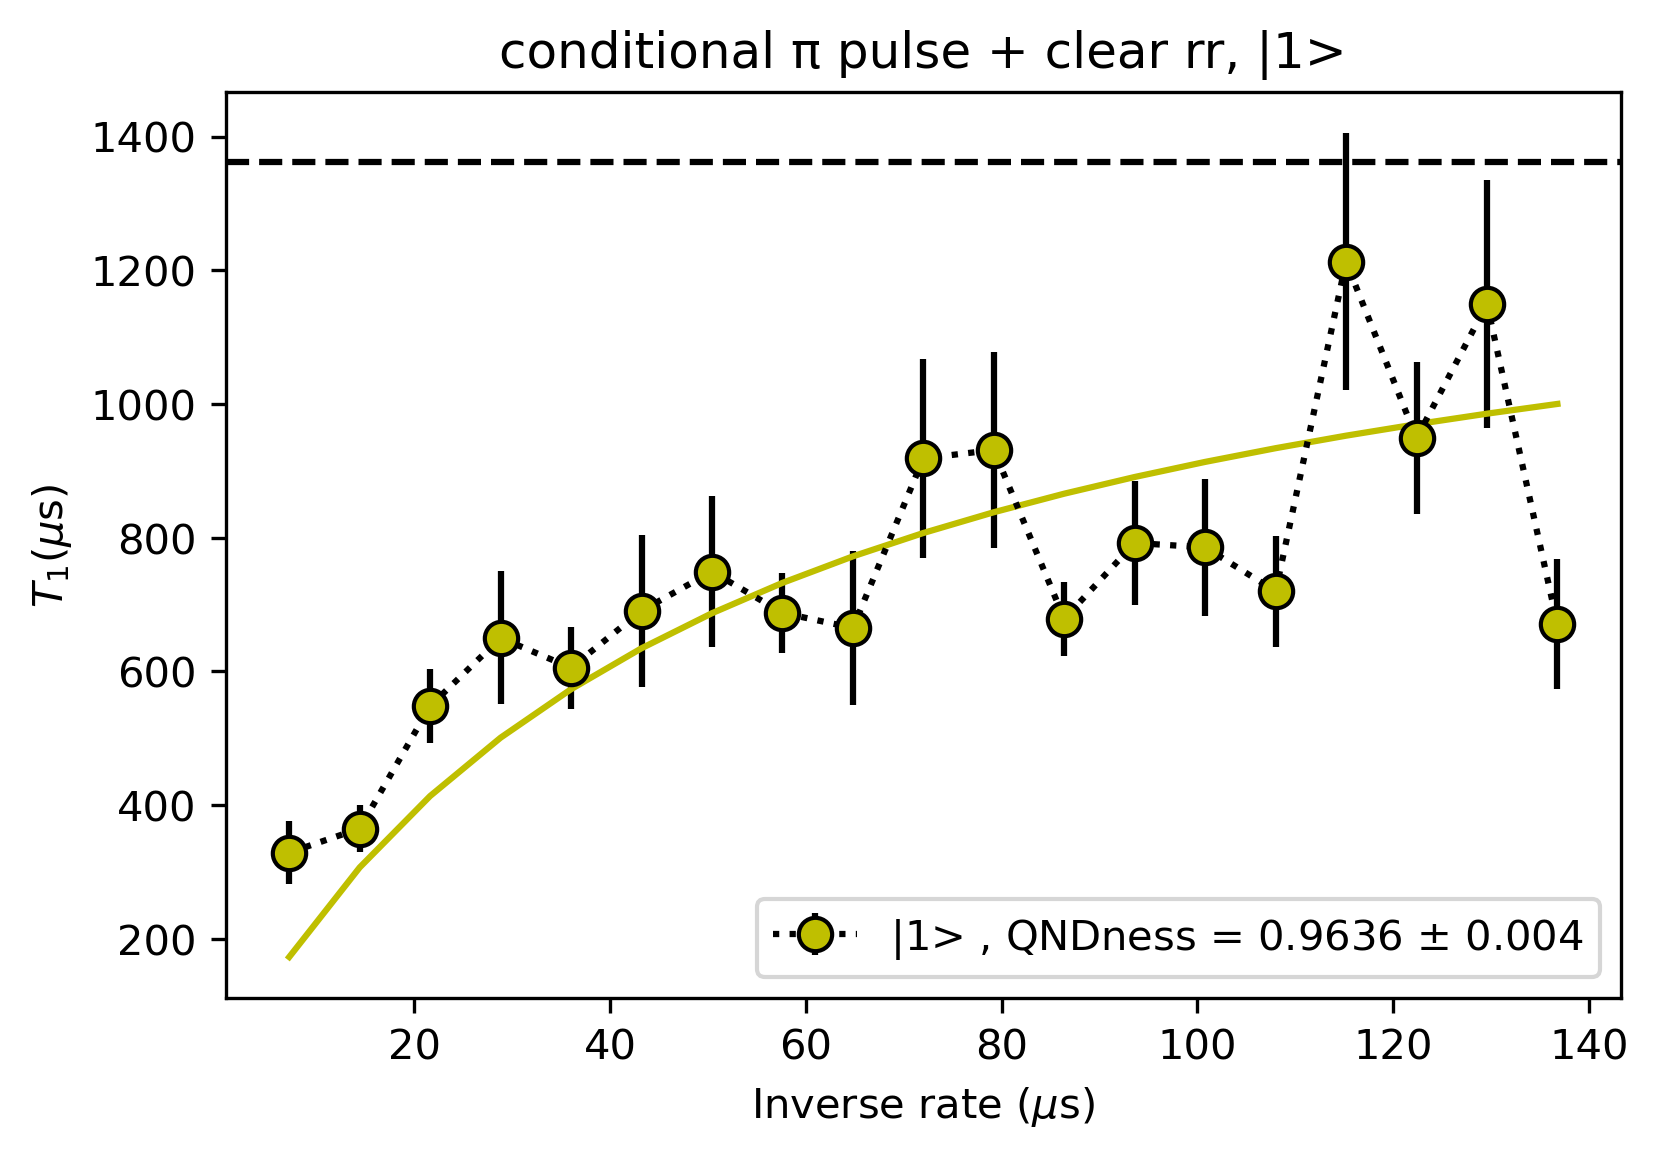

QNDness = 0.964


In [69]:
def qndness(x, b):
    t1 = 1362
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness'
filelist = [18]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im)
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')

        plt.show()        
        x = x[:]
        for jj in range(len(Q)-1):
            y = Q[jj+1][:]
            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1000, 0))
            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)

t=0
popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate[1:]
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1362, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')
plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title('conditional π pulse + clear rr, |1>')
plt.legend()
plt.show()

print("QNDness = %.3f"%(1-popt))

## Different Fock states

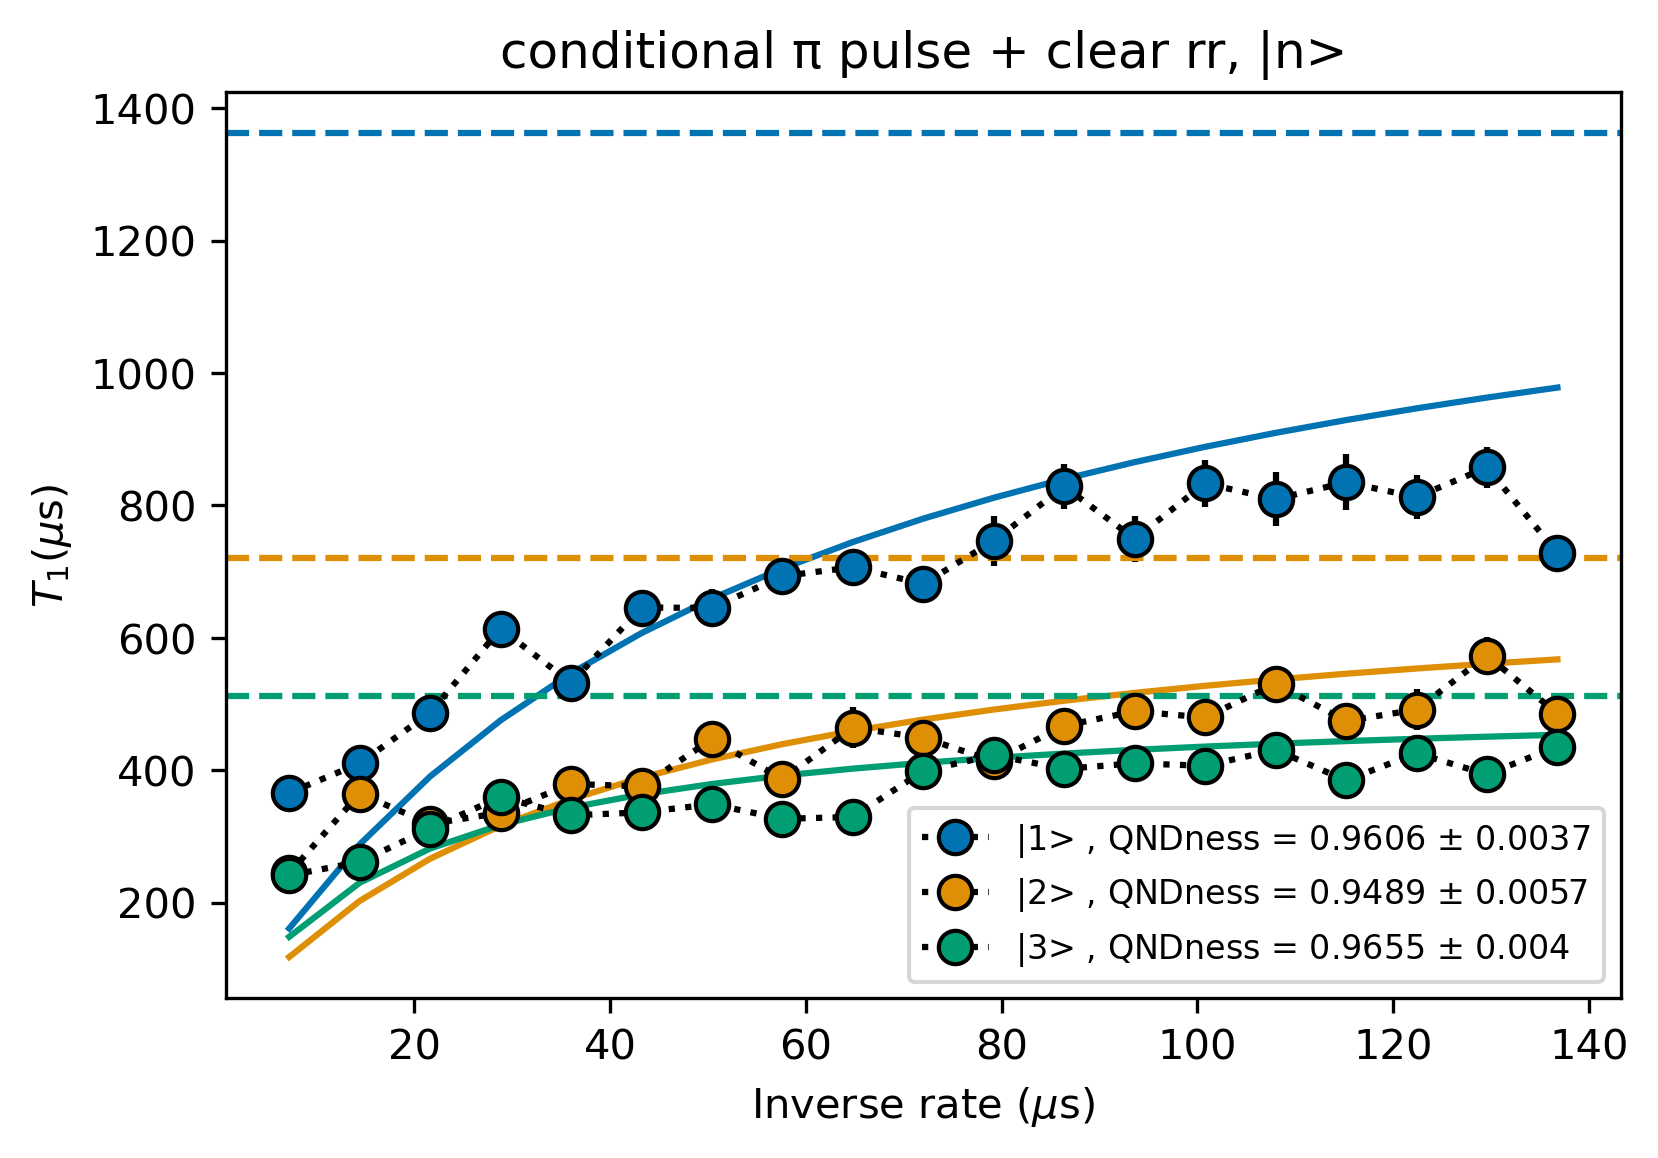

In [80]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
t1_ind = [1362, 720, 512]
def qndness(x, b):
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness'
filelist = [11, 14, 17]

t1_rate = {}
t1_rate_err = {}

fig, axs = plt.subplots(1, 1, dpi=300)
colors = sns.color_palette('colorblind')

qnd = []
qnd_err = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
#         fig, axs = plt.subplots()
#         im = axs.pcolormesh(x, rate, Q, shading='auto')
#         plt.colorbar(im)
#         plt.xlabel('Delay time (μs)')
#         plt.ylabel('Inverse rate (μs)')
#         plt.show()        
        x = x[:]
        t1_temp = []
        t1_err_temp = []
        for jj in range(len(Q)-1):
            y = Q[jj+1][:]
            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1000, 0))
            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_temp.append(t1)
            t1_err_temp.append(t1_err)
        t1_rate['n%i'%(ii+1)] = t1_temp
        t1_rate_err['n%i'%(ii+1)] = t1_err_temp
        
        x = inv_rate[1:]
        t1 = t1_ind[ii]
        popt, pcov = curve_fit(qndness, x, t1_temp, sigma=t1_err_temp)
        qnd = np.round(1-popt[0], 4)
        qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
        axs.axhline(y=t1, linestyle='--', color=colors[ii])
        axs.errorbar(x, y=t1_temp, yerr= t1_err_temp, marker='o', markersize=8, 
                     linestyle='dotted', color='k', markerfacecolor=colors[ii], label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
        axs.plot(x, qndness(x, *popt),  color=colors[ii])
        axs.legend(fontsize=8)
        
axs.set_xlabel('Inverse rate ($\mu$s)')
axs.set_ylabel(r'$T_{1}(\mu$s)')
plt.title('conditional π pulse + clear rr, |n>')
plt.show()

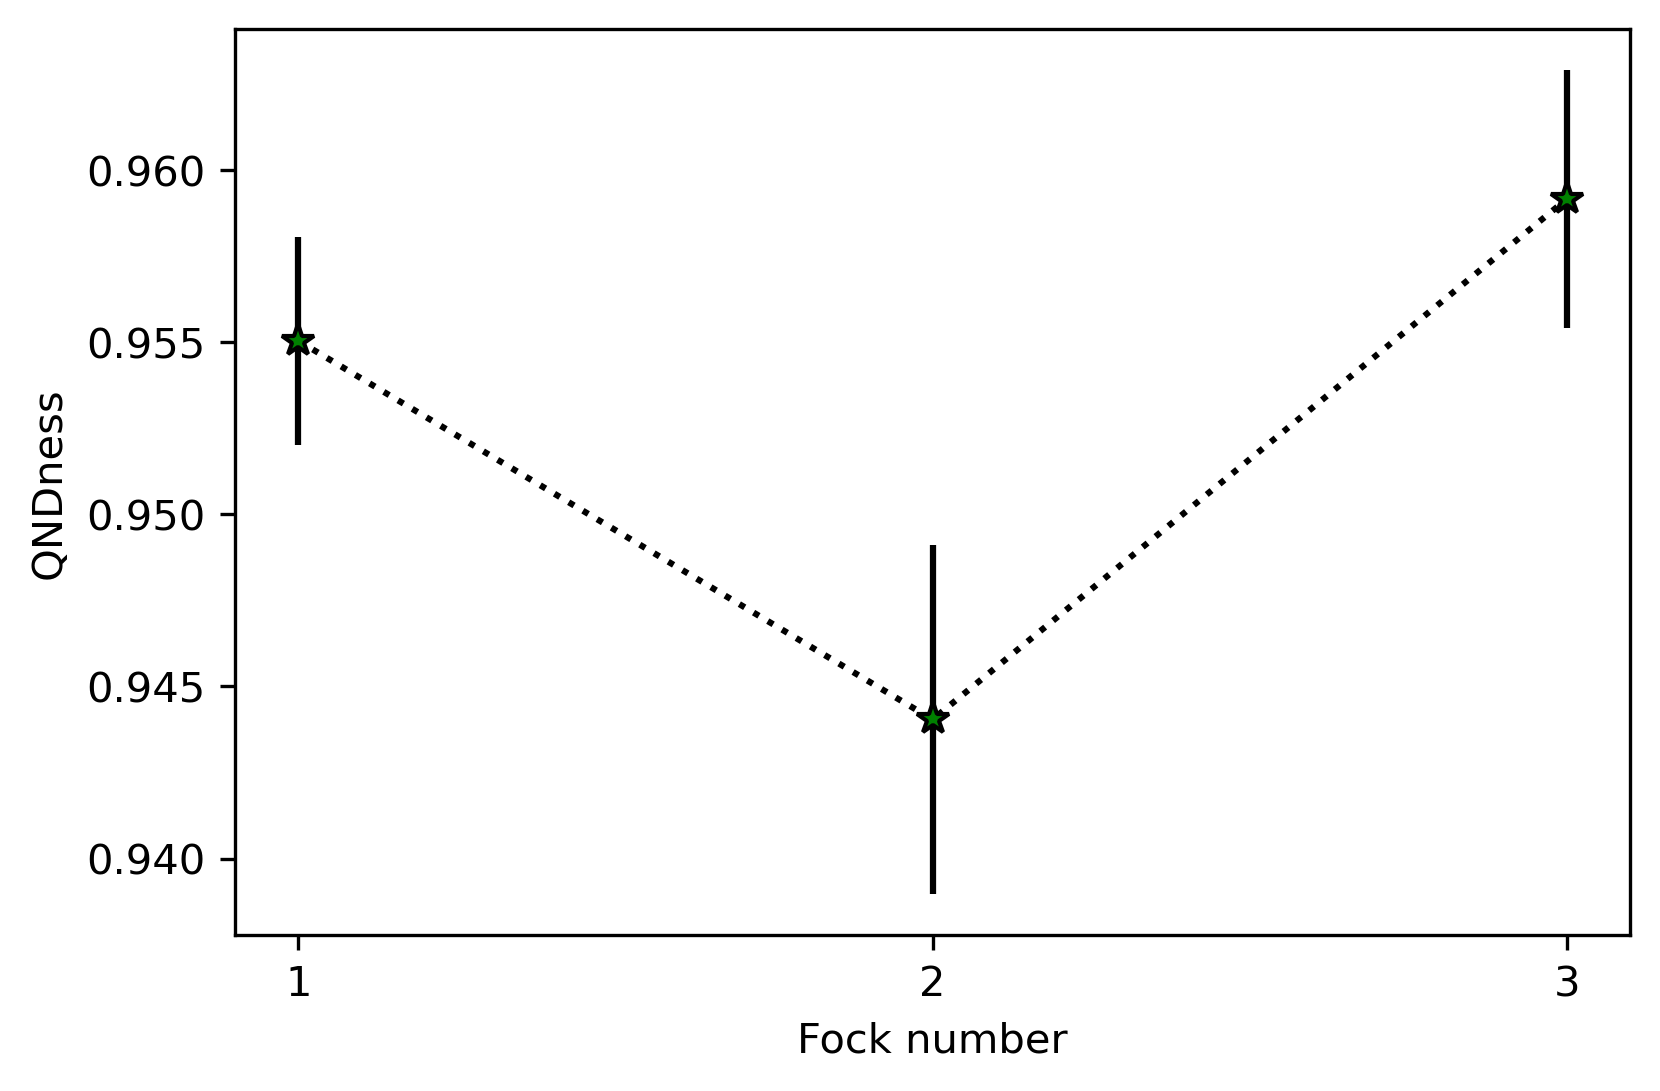

In [163]:
plt.figure(dpi=300)
plt.errorbar(np.arange(1, 4, 1), y=qnd, yerr= qnd_err, marker=markers[ii], markersize=8, 
             linestyle='dotted', color='k', markerfacecolor=colors[ii], label='|{}> , QNDness = {}'.format(ii+1, np.round(1-popt[0], 3)))
plt.xlabel('Fock number')
plt.ylabel('QNDness')
plt.xticks([1, 2, 3])
plt.show()

## QNDness Pi + Sq readout

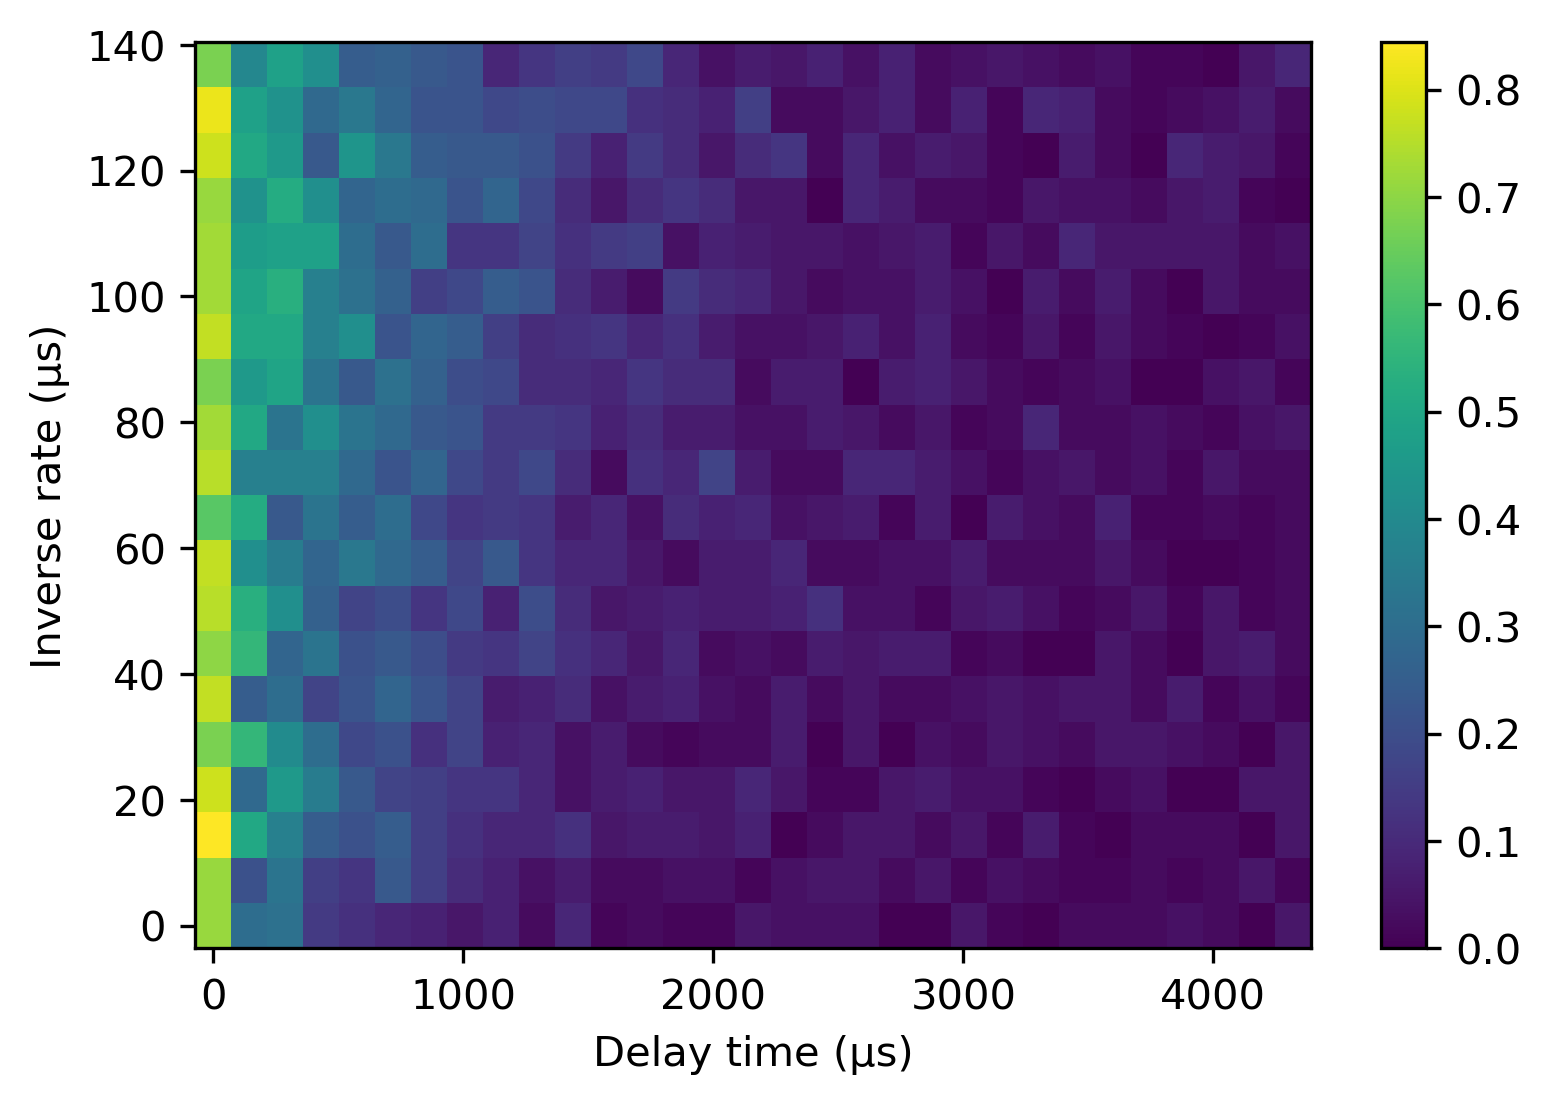

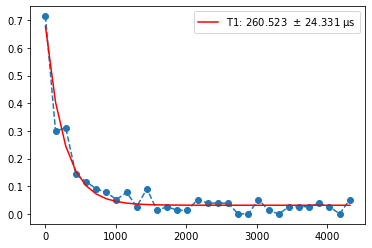

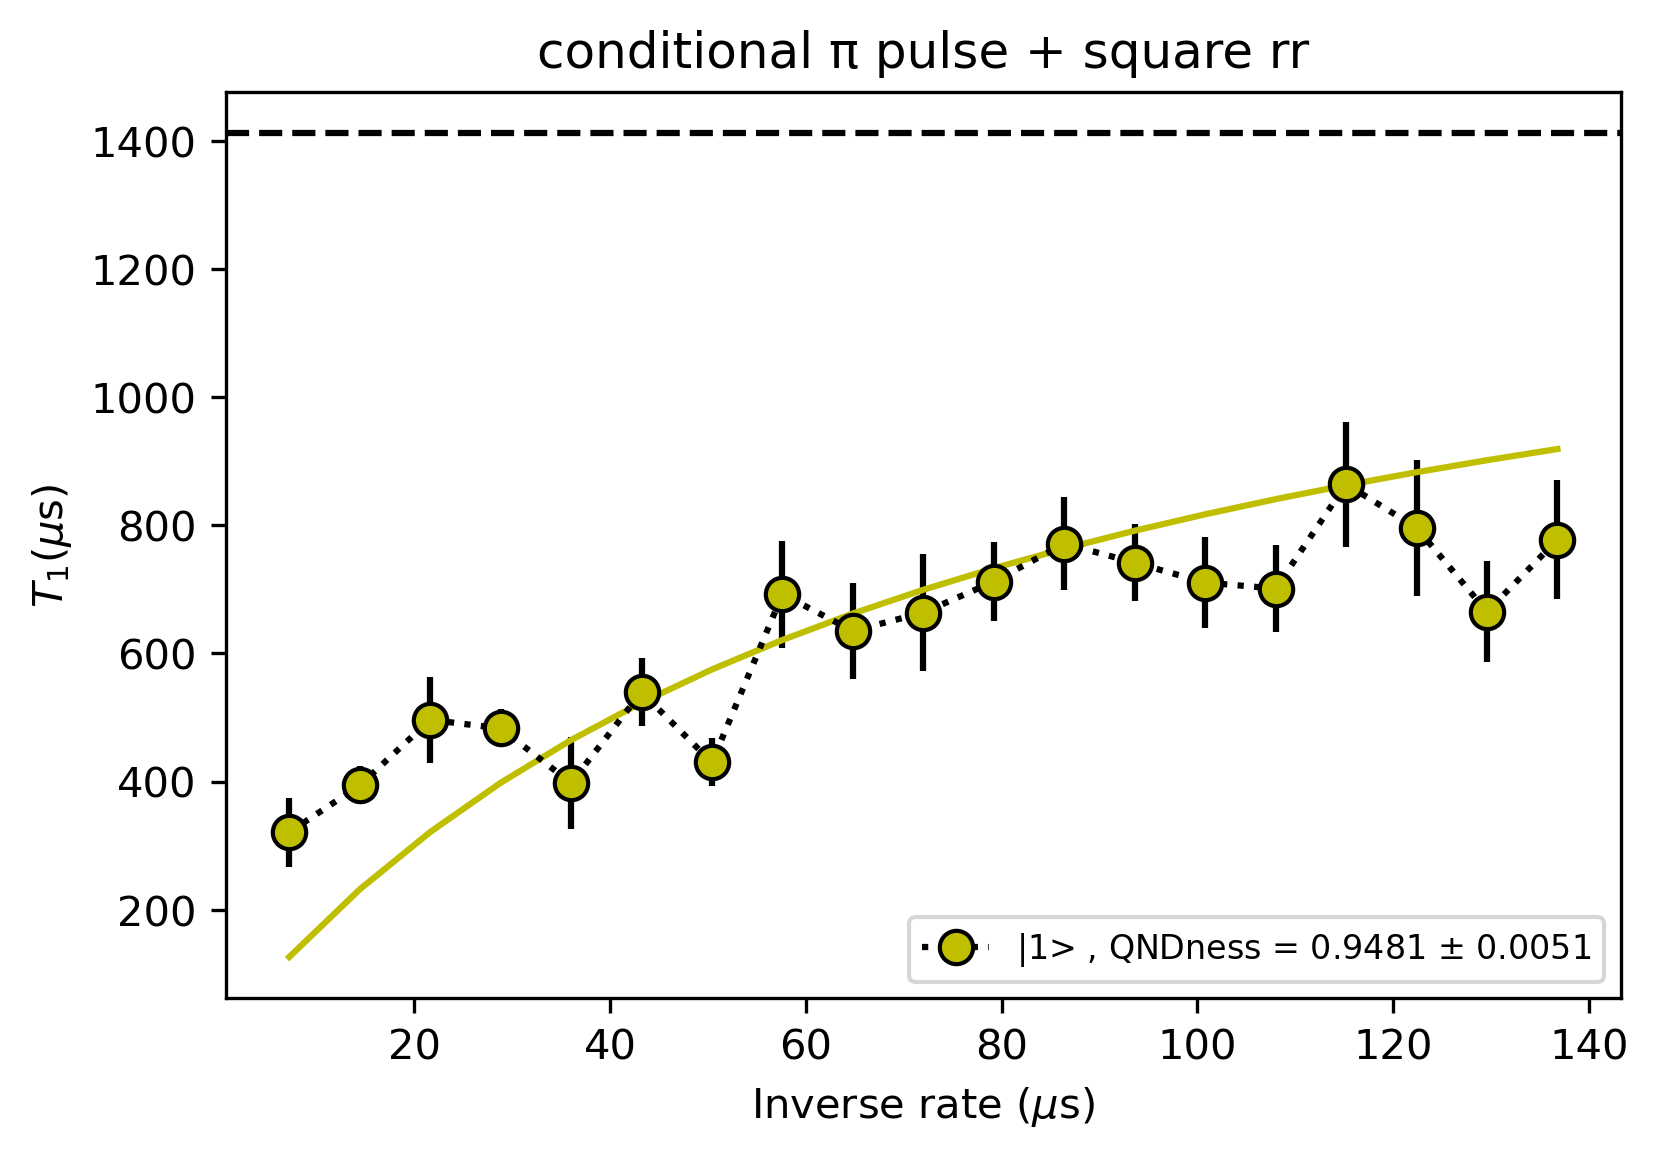

QNDness = 0.948


In [79]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
def qndness(x, b):
    t1 = 1412
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_sq'
filelist = [2]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im)
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')

        plt.show()
        
        t = 0
        x = x[t:]
        for jj in range(len(Q)-1):

            y = Q[jj+1][t:]

            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1200, 0))

            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)

popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate[1:]
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1412, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')
plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title('conditional π pulse + square rr')
plt.legend(fontsize=8)
plt.show()

print("QNDness = %.3f"%(1-popt))

## QNDness Pi + Gauss readout

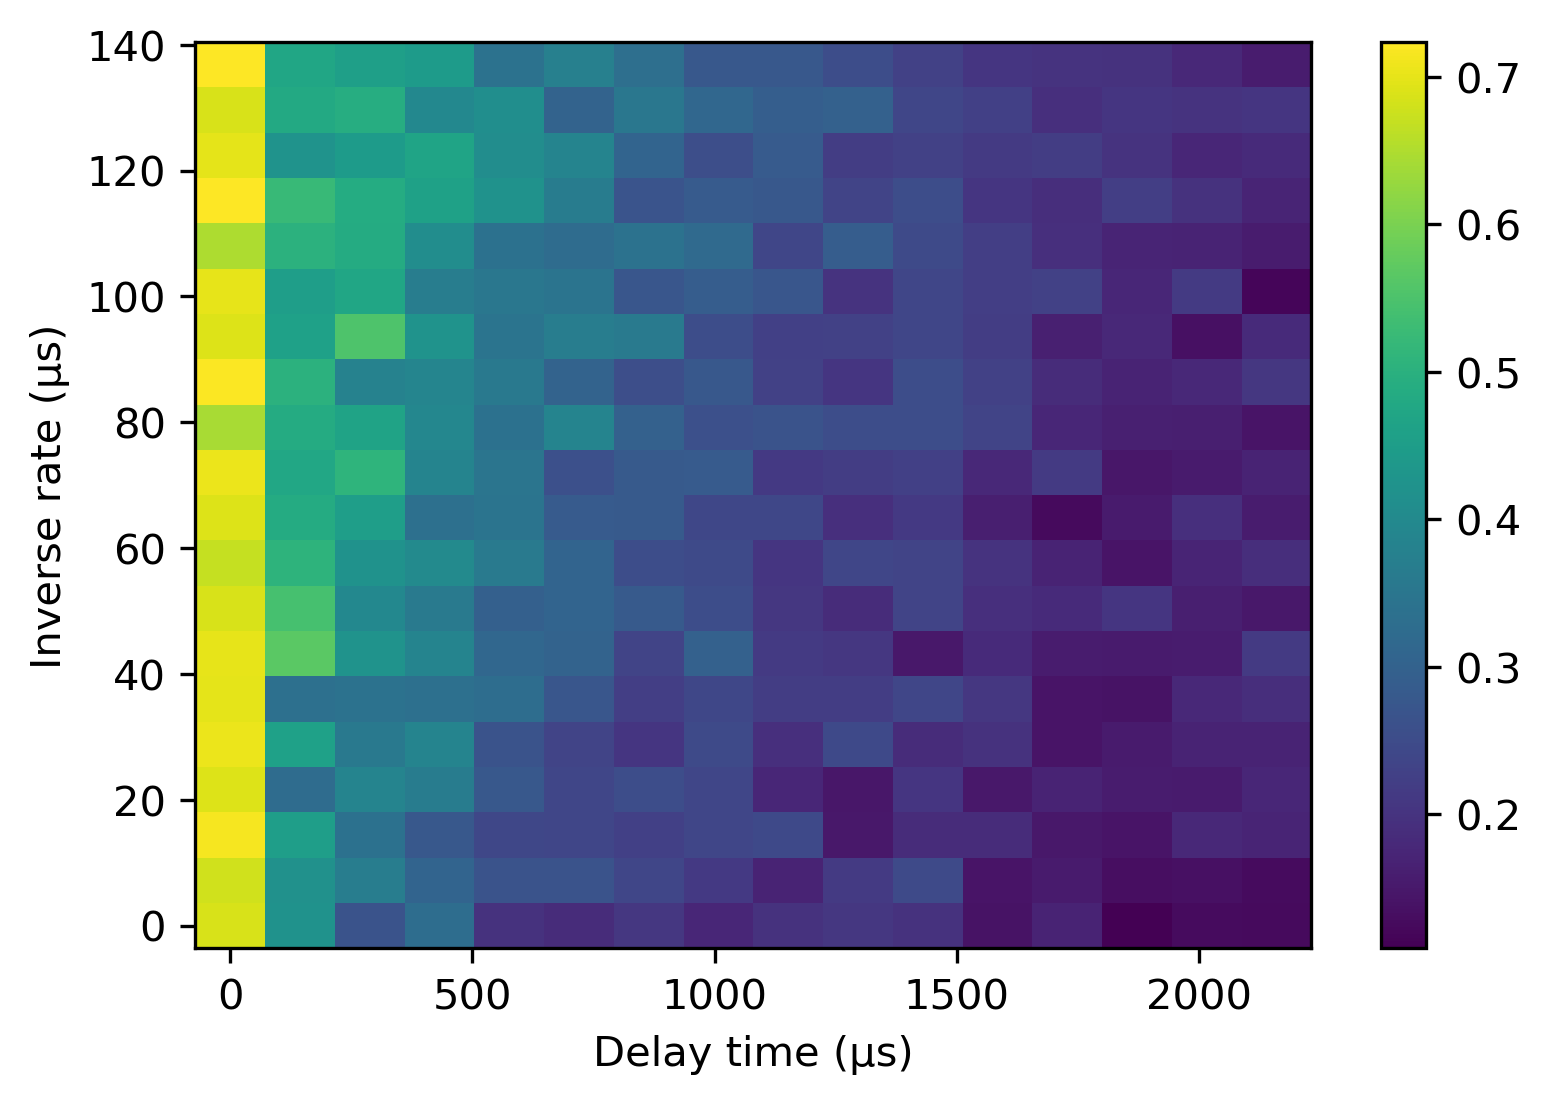

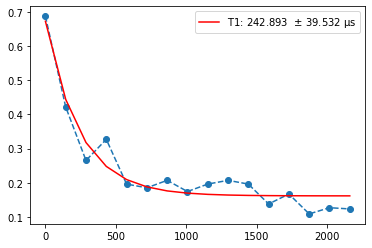

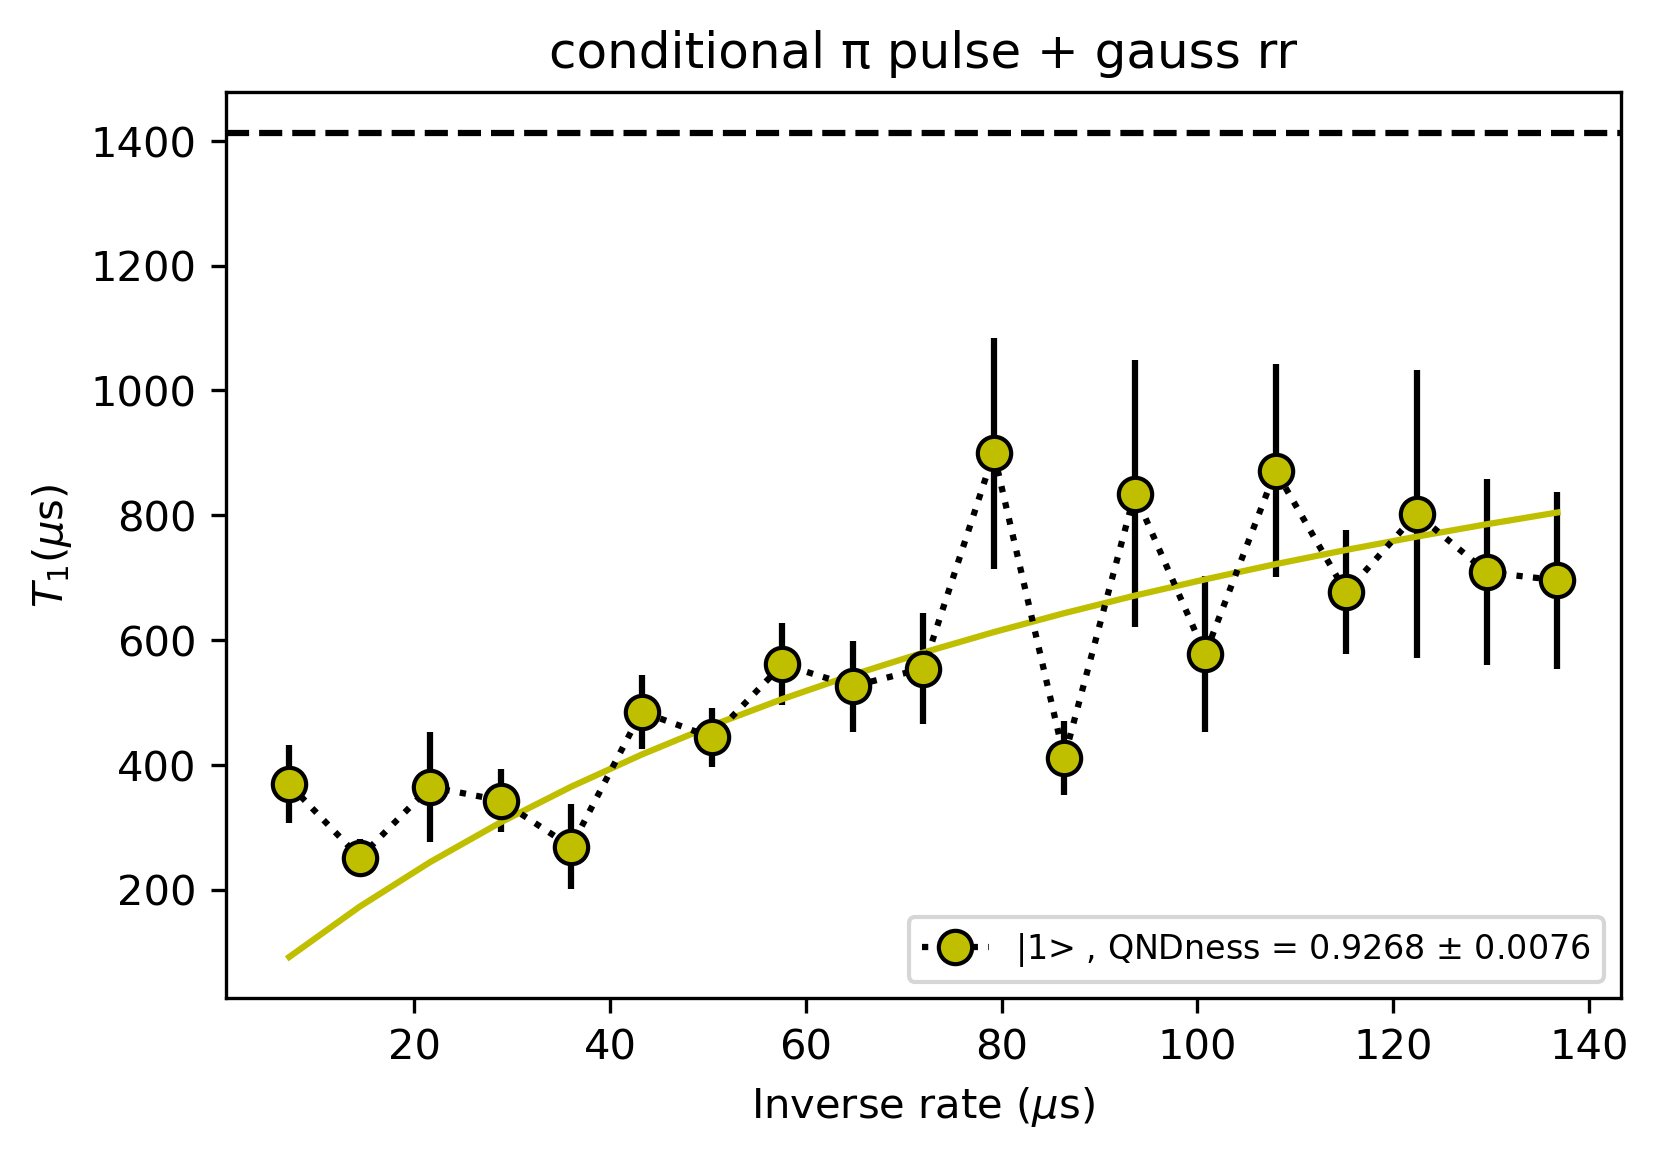

QNDness = 0.927


In [78]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
def qndness(x, b):
    t1 = 1412
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_gauss_rr'
filelist = [1]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im)
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')

        plt.show()
        
        t = 0
        x = x[t:]
        for jj in range(len(Q)-1):

            y = Q[jj+1][t:]

            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1200, 0))

            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)

popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate[1:]
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1412, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')
plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title('conditional π pulse + gauss rr')
plt.legend(fontsize=8)
plt.show()

print("QNDness = %.3f"%(1-popt))

# QNDness readout only

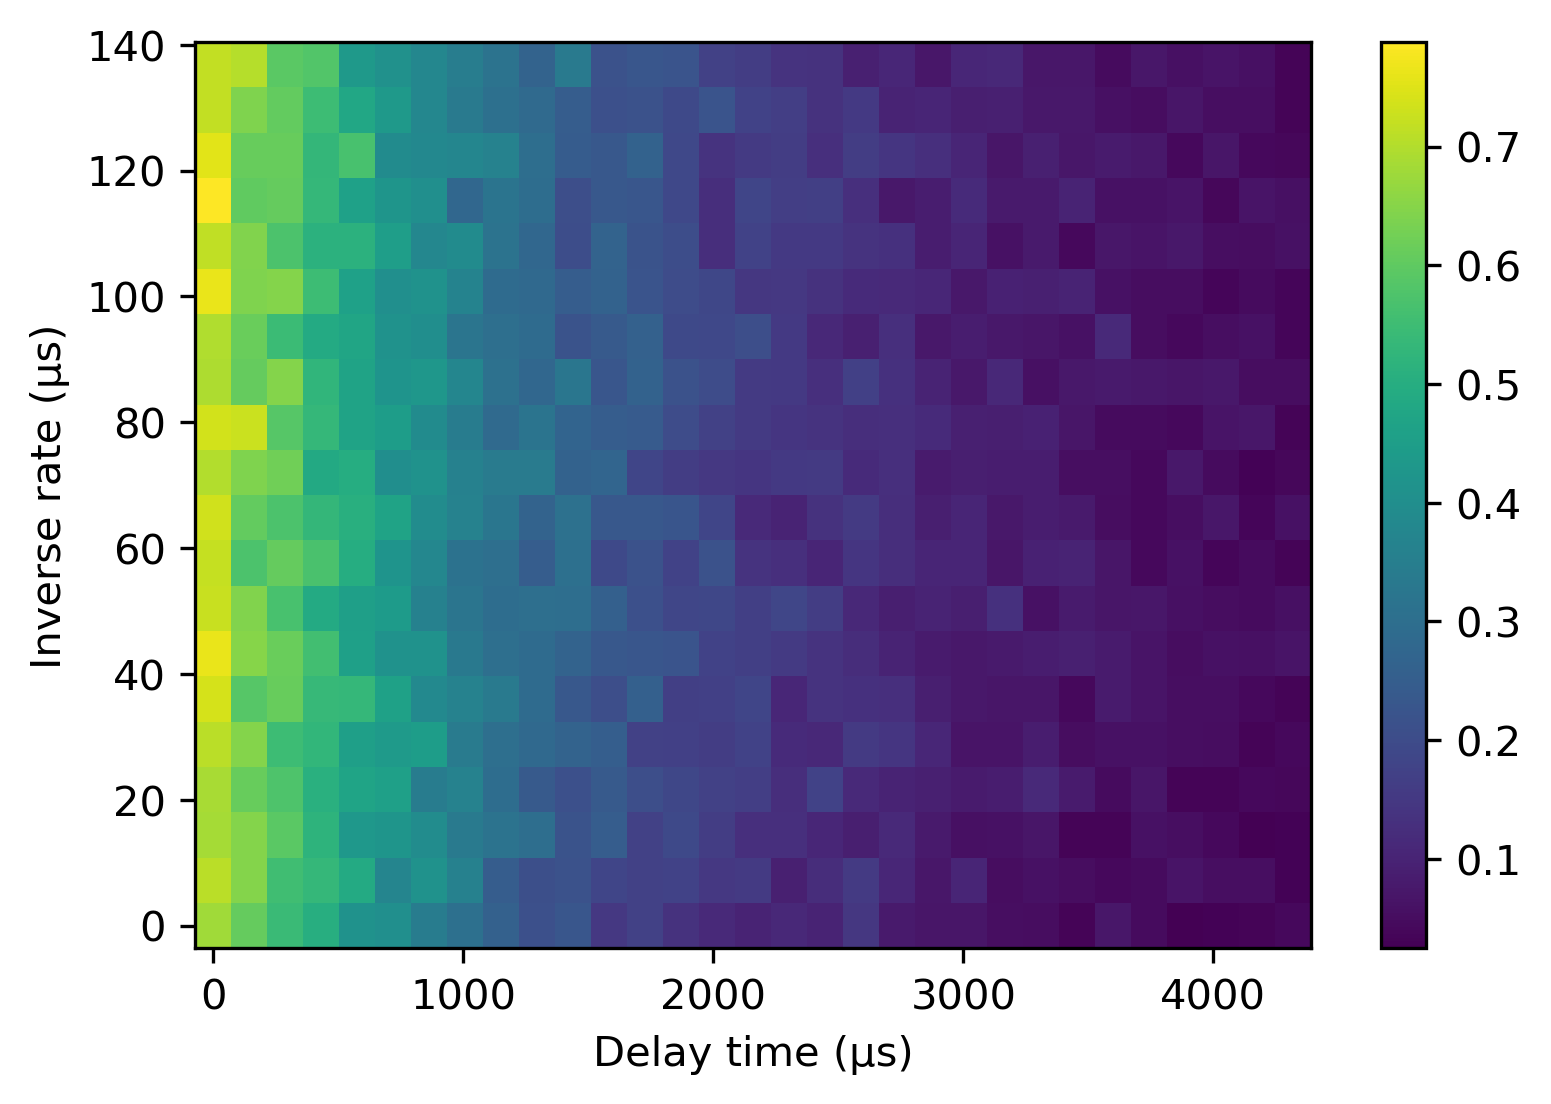

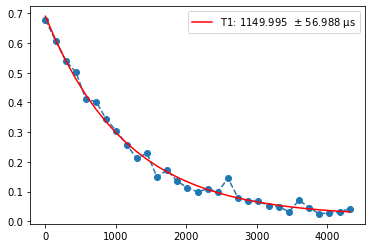

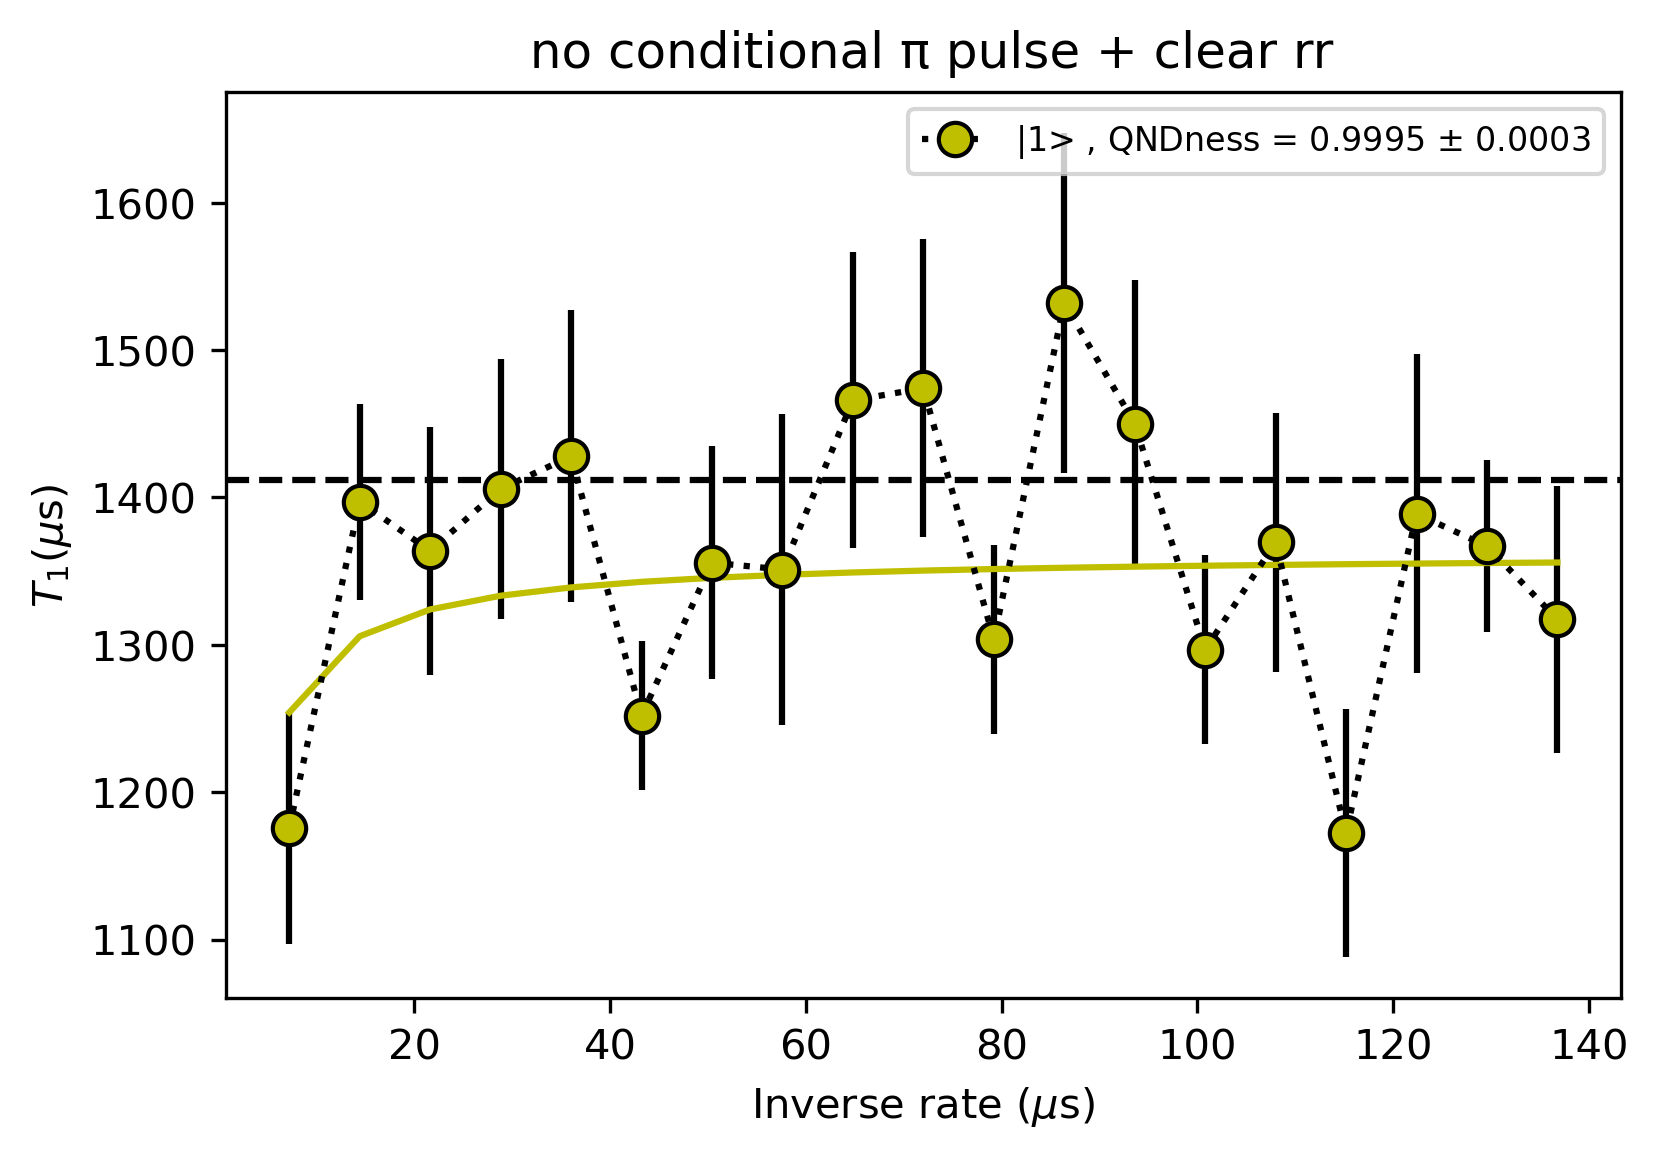

QNDness = 1.000


In [77]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
def qndness(x, b):
    t1 = 1362
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_readout'
filelist = [17]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im)
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')

        plt.show()
        
        t = 0
        x = x[t:]
        for jj in range(len(Q)-1):

            y = Q[jj+1][t:]

            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1200, 0))

            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)

popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate[1:]
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1412, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')
plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title(' no conditional π pulse + clear rr')
plt.legend(fontsize=8)
plt.show()

print("QNDness = %.3f"%(1-popt))

## Different Fock states 

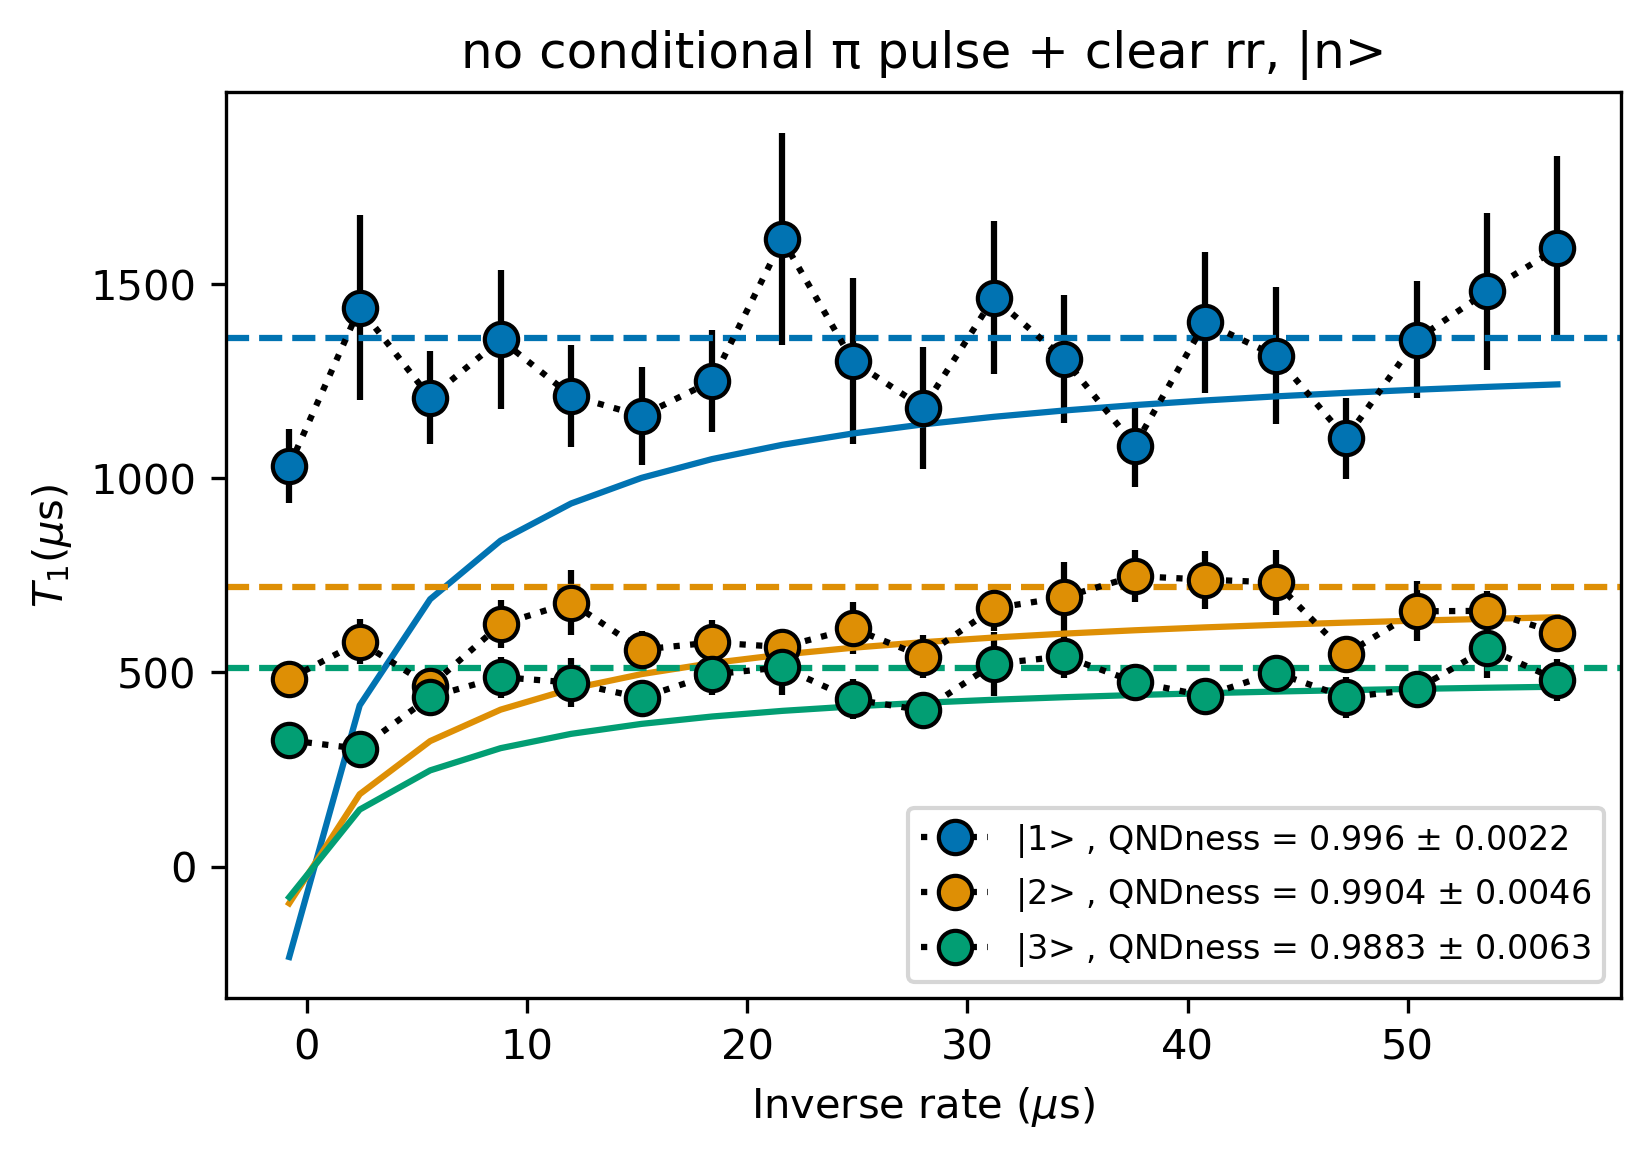

In [76]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
t1_ind = [1362, 720, 512]
def qndness(x, b):
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_readout'
filelist = [4, 9, 13]

t1_rate = {}
t1_rate_err = {}

fig, axs = plt.subplots(1, 1, dpi=300)
colors = sns.color_palette('colorblind')

qnd = []
qnd_err = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data

        x = x[:]
        t1_temp = []
        t1_err_temp = []
        for jj in range(len(Q)-1):
            y = Q[jj+1][:]
            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1000, 0))
            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_temp.append(t1)
            t1_err_temp.append(t1_err)
        t1_rate['n%i'%(ii+1)] = t1_temp
        t1_rate_err['n%i'%(ii+1)] = t1_err_temp
        
        x = inv_rate[1:]
        t1 = t1_ind[ii]
        popt, pcov = curve_fit(qndness, x, t1_temp, sigma=t1_err_temp)
        
        qnd = np.round(1-popt[0], 4)
        qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
        
        axs.axhline(y=t1, linestyle='--', color=colors[ii])
        axs.errorbar(x, y=t1_temp, yerr= t1_err_temp, marker='o', markersize=8, 
                     linestyle='dotted', color='k', markerfacecolor=colors[ii], label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
        axs.plot(x, qndness(x, *popt),  color=colors[ii])
        axs.legend(fontsize=8)

axs.set_xlabel('Inverse rate ($\mu$s)')
axs.set_ylabel(r'$T_{1}(\mu$s)')
plt.title('no conditional π pulse + clear rr, |n>')
plt.show()

## Square readout

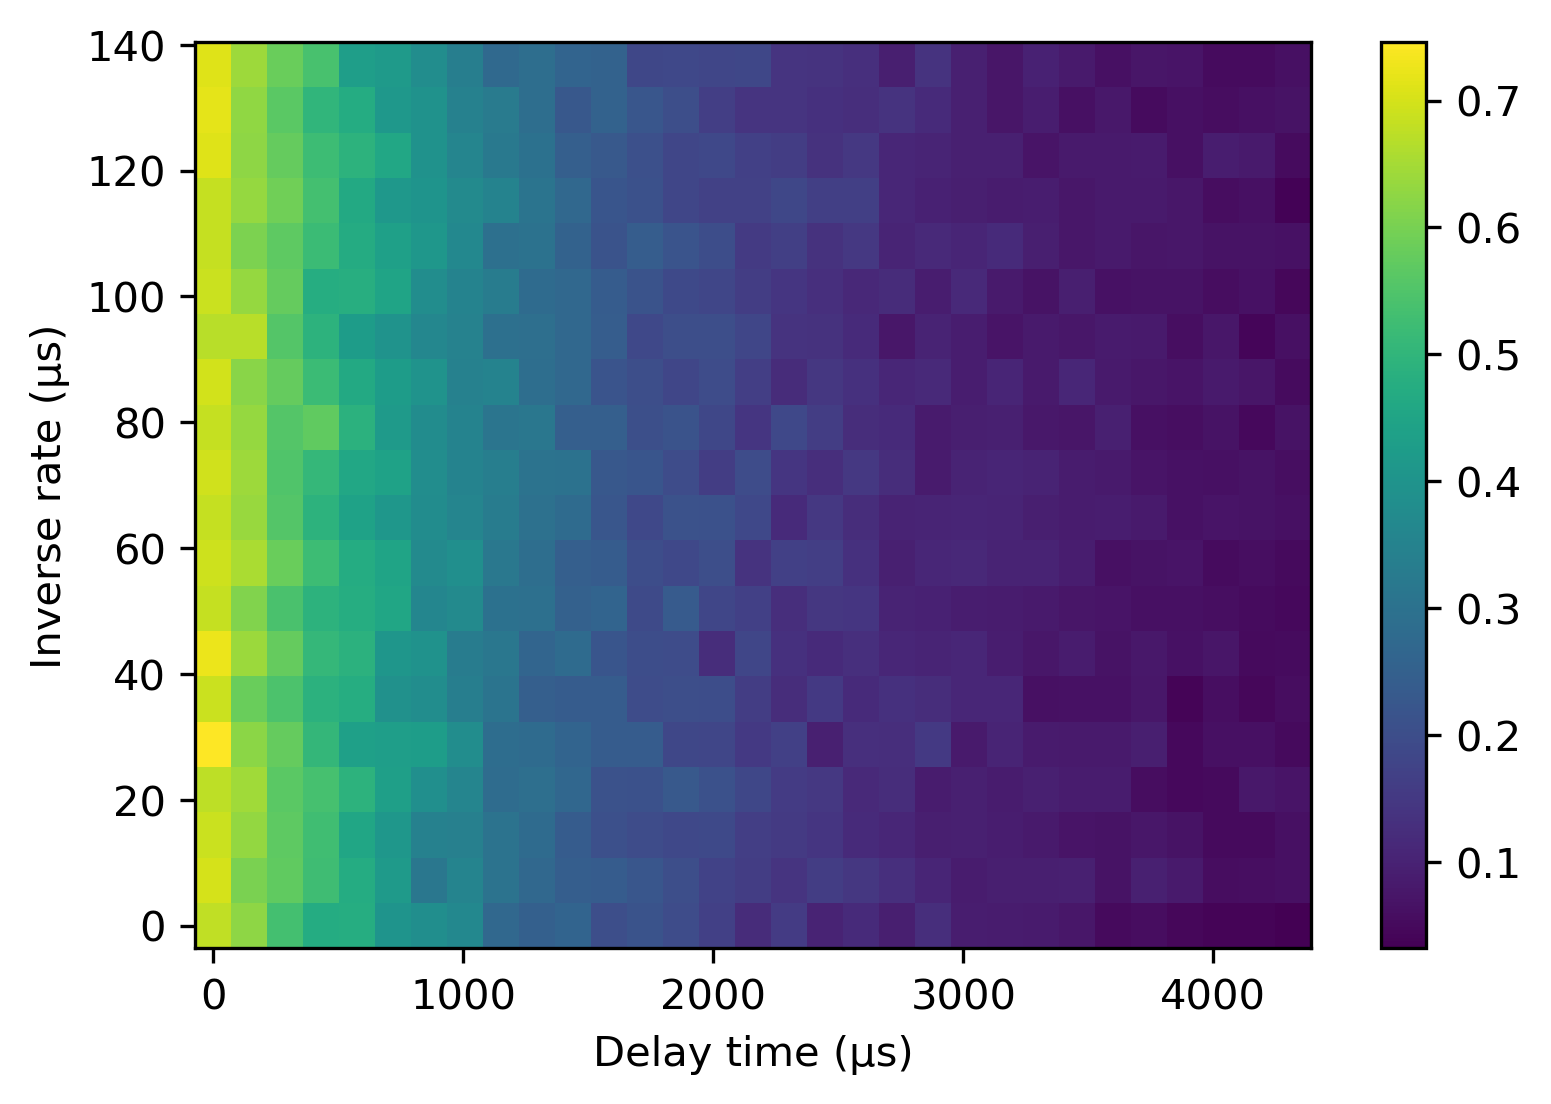

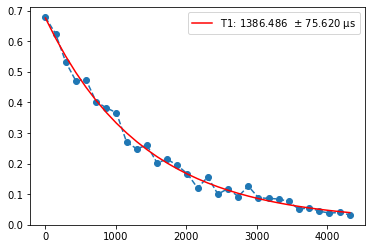

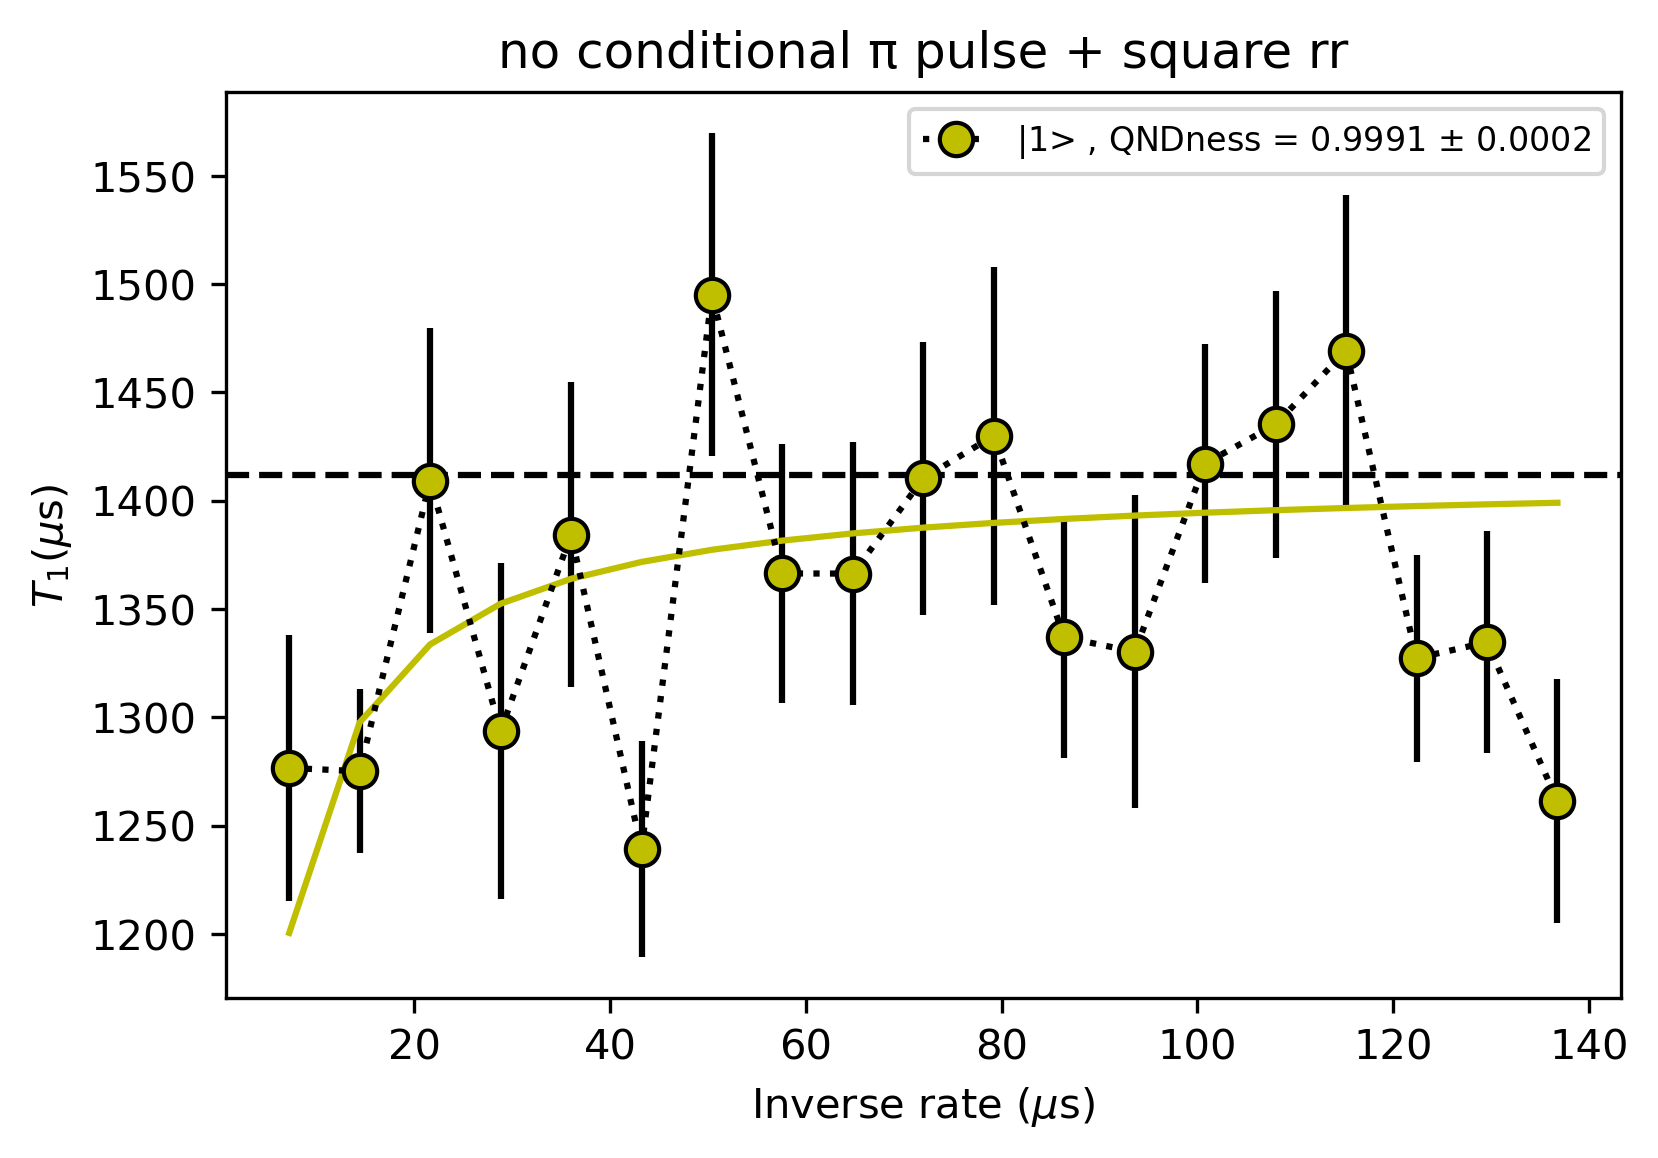

QNDness = 0.999


In [82]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
def qndness(x, b):
    t1 = 1412
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_sq'
filelist = [4]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im)
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')

        plt.show()
        
        t = 0
        x = x[t:]
        for jj in range(len(Q)-1):

            y = Q[jj+1][t:]

            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1200, 0))

            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)

popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate[1:]
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1412, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')

plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title('no conditional π pulse + square rr')
plt.legend(fontsize=8)
plt.show()

print("QNDness = %.3f"%(1-popt))

# QNDness Pi only

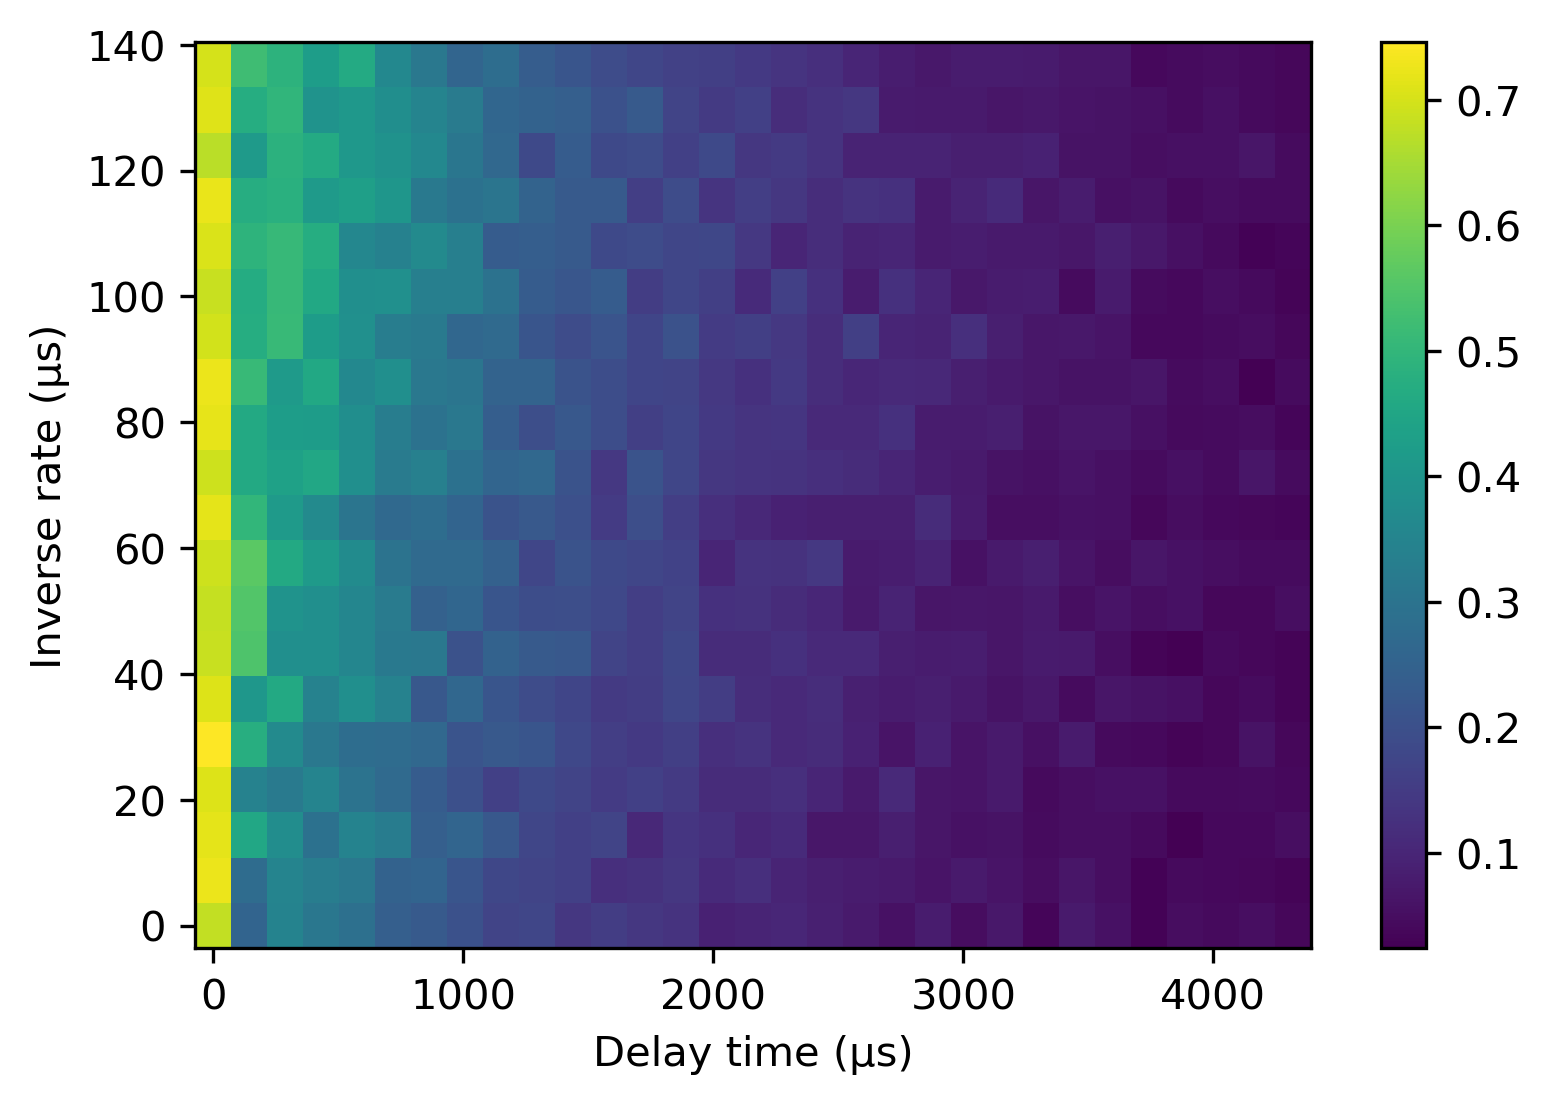

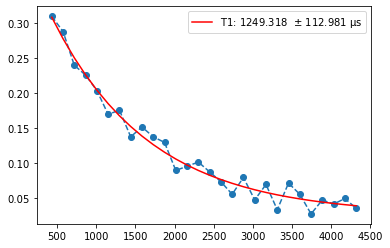

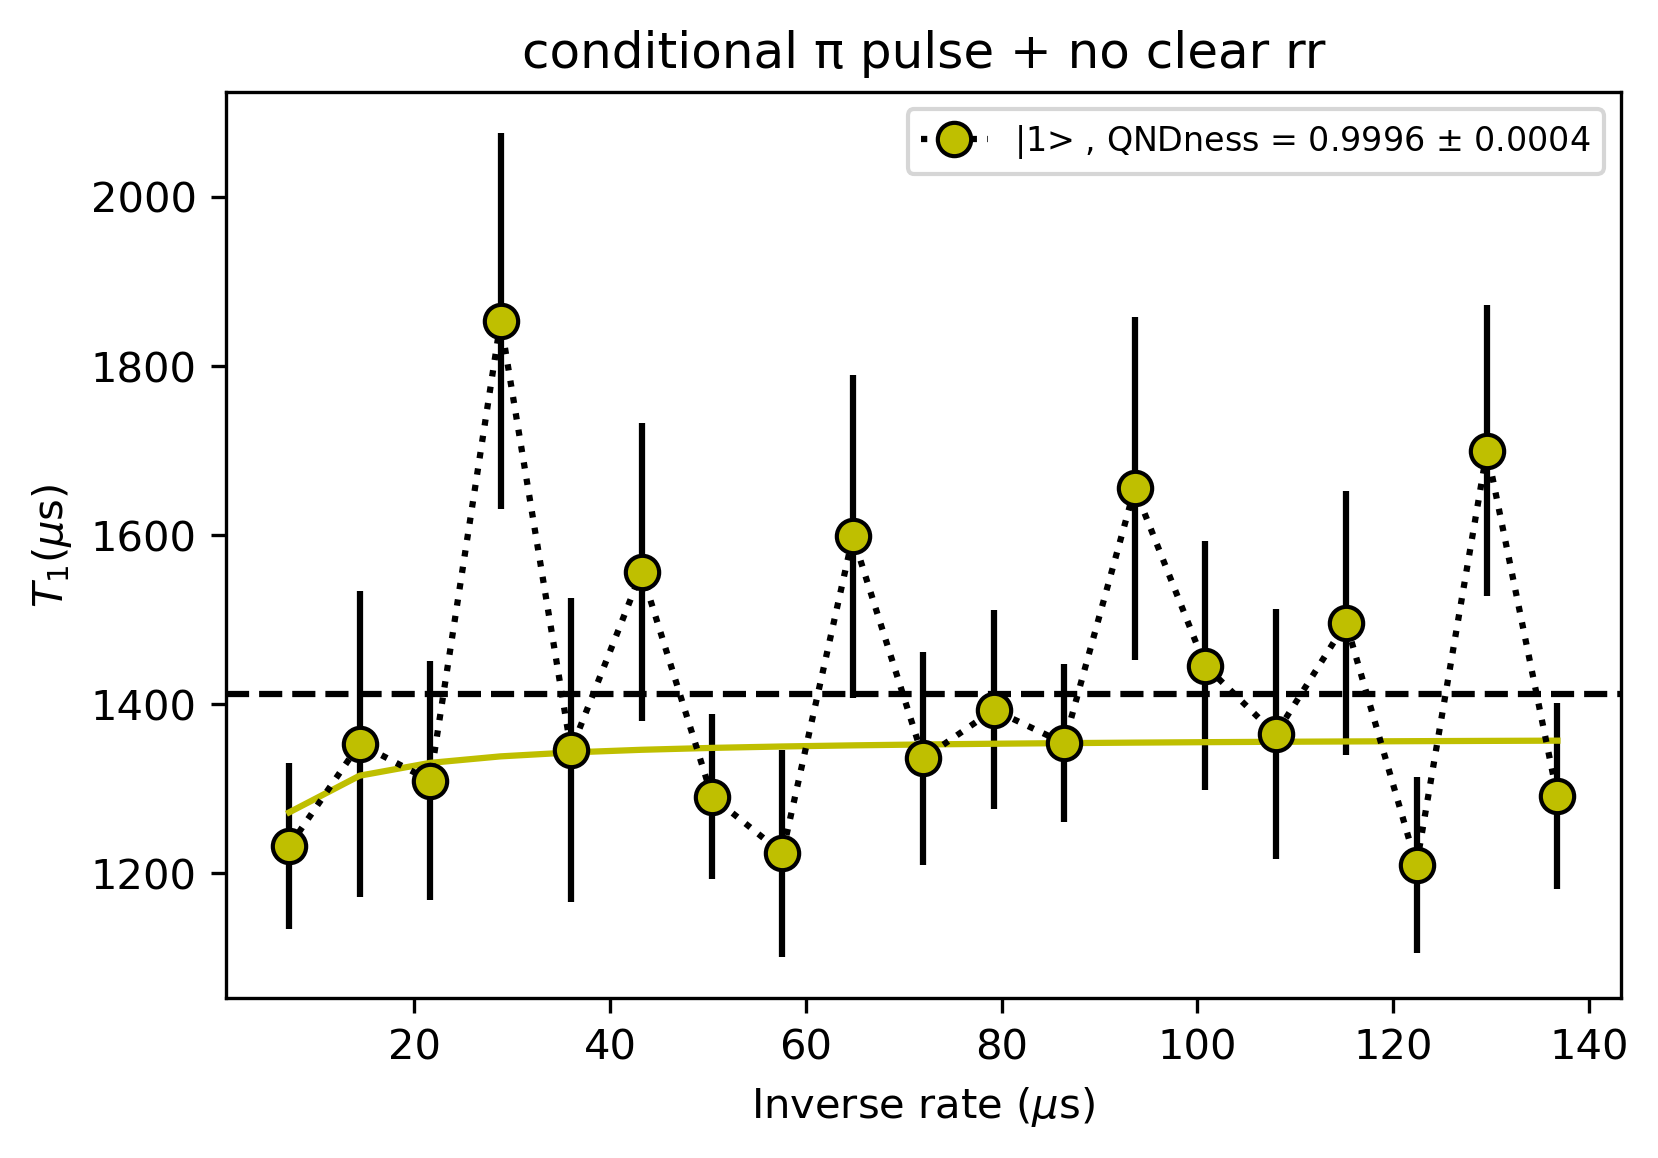

QNDness = 1.000


In [84]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
def qndness(x, b):
    t1 = 1362
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_qubit'
filelist = [12]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im)
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')

        plt.show()
        
        t = 3
        x = x[t:]
        for jj in range(len(Q)-1):

            y = Q[jj+1][t:]

            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1200, 0))

            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)

popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate[1:]
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1412, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')

plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title('conditional π pulse + no clear rr')
plt.legend(fontsize=8)
plt.show()

print("QNDness = %.3f"%(1-popt))

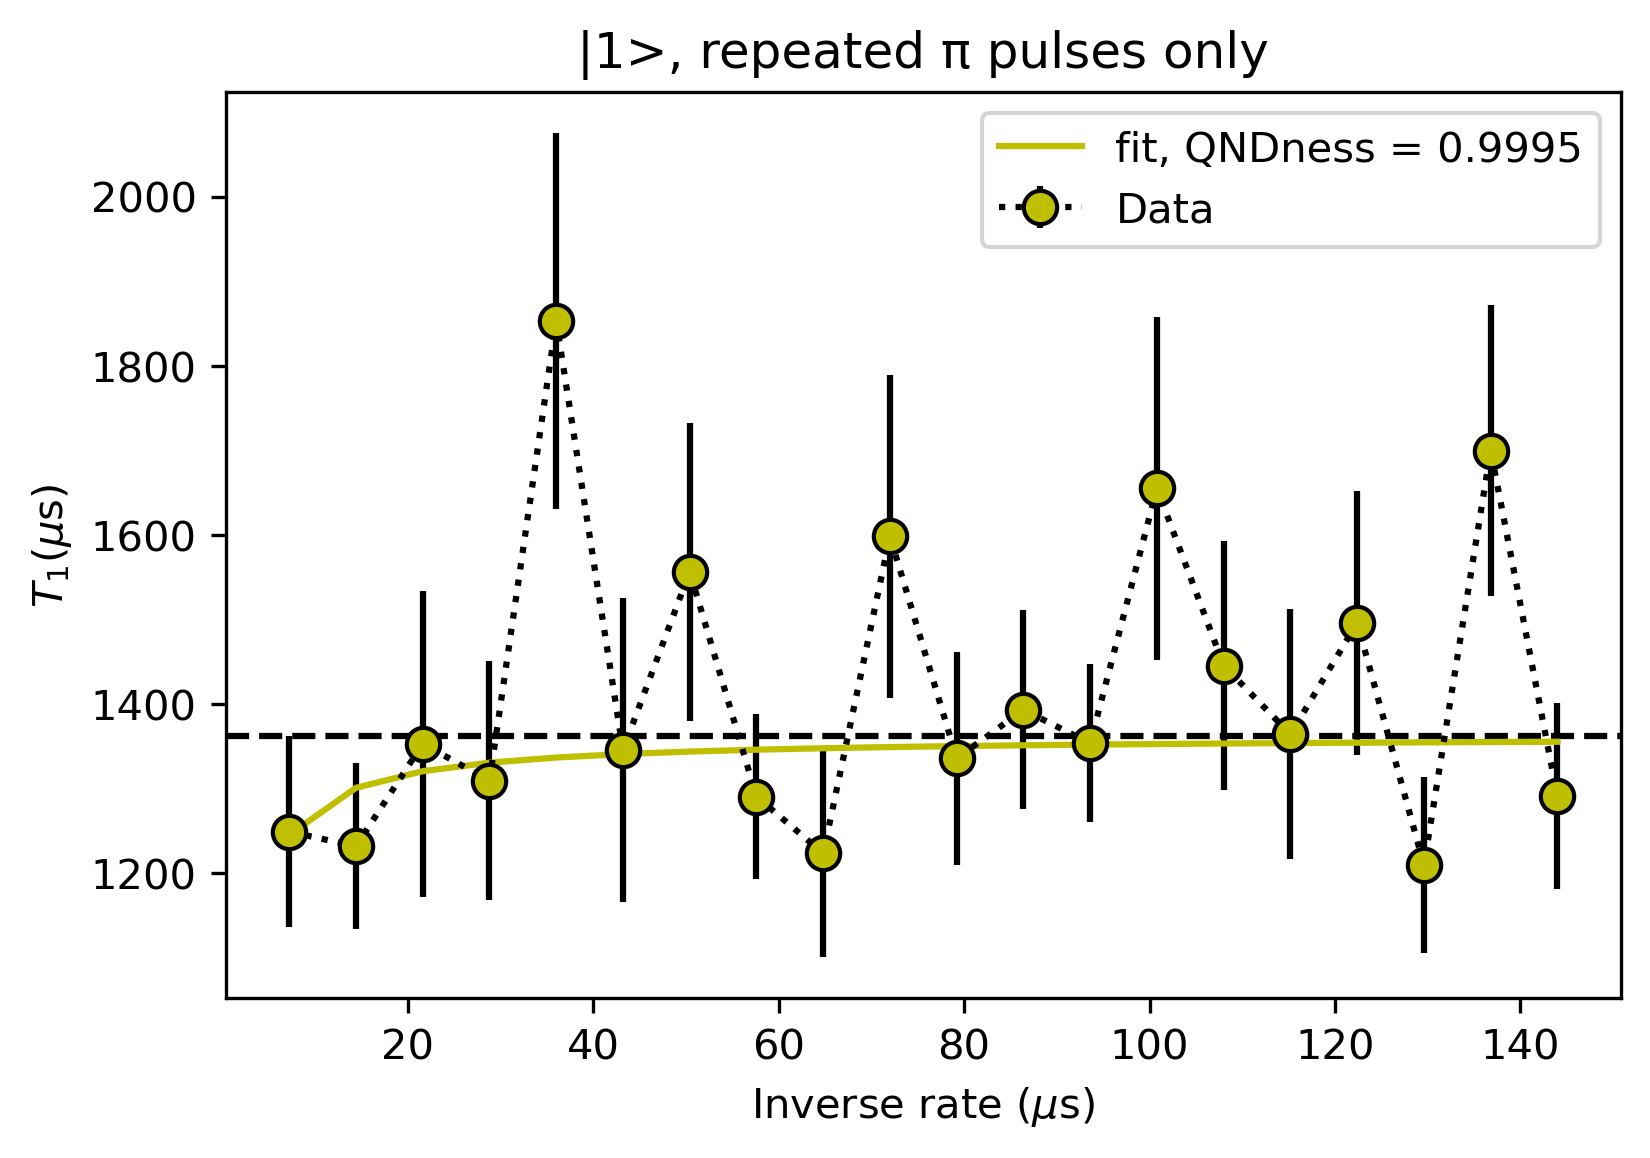

QNDness = 1.000


In [352]:
x = inv_rate
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1362, linestyle='--', color='k')
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='Data')
plt.plot(x, qndness(x, *popt), label='fit, QNDness = %.4f'%(1-popt), color='y')
plt.title('|1>, repeated π pulses only')
plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.legend()
plt.show()

print("QNDness = %.3f"%(1-popt))

## Different Fock states

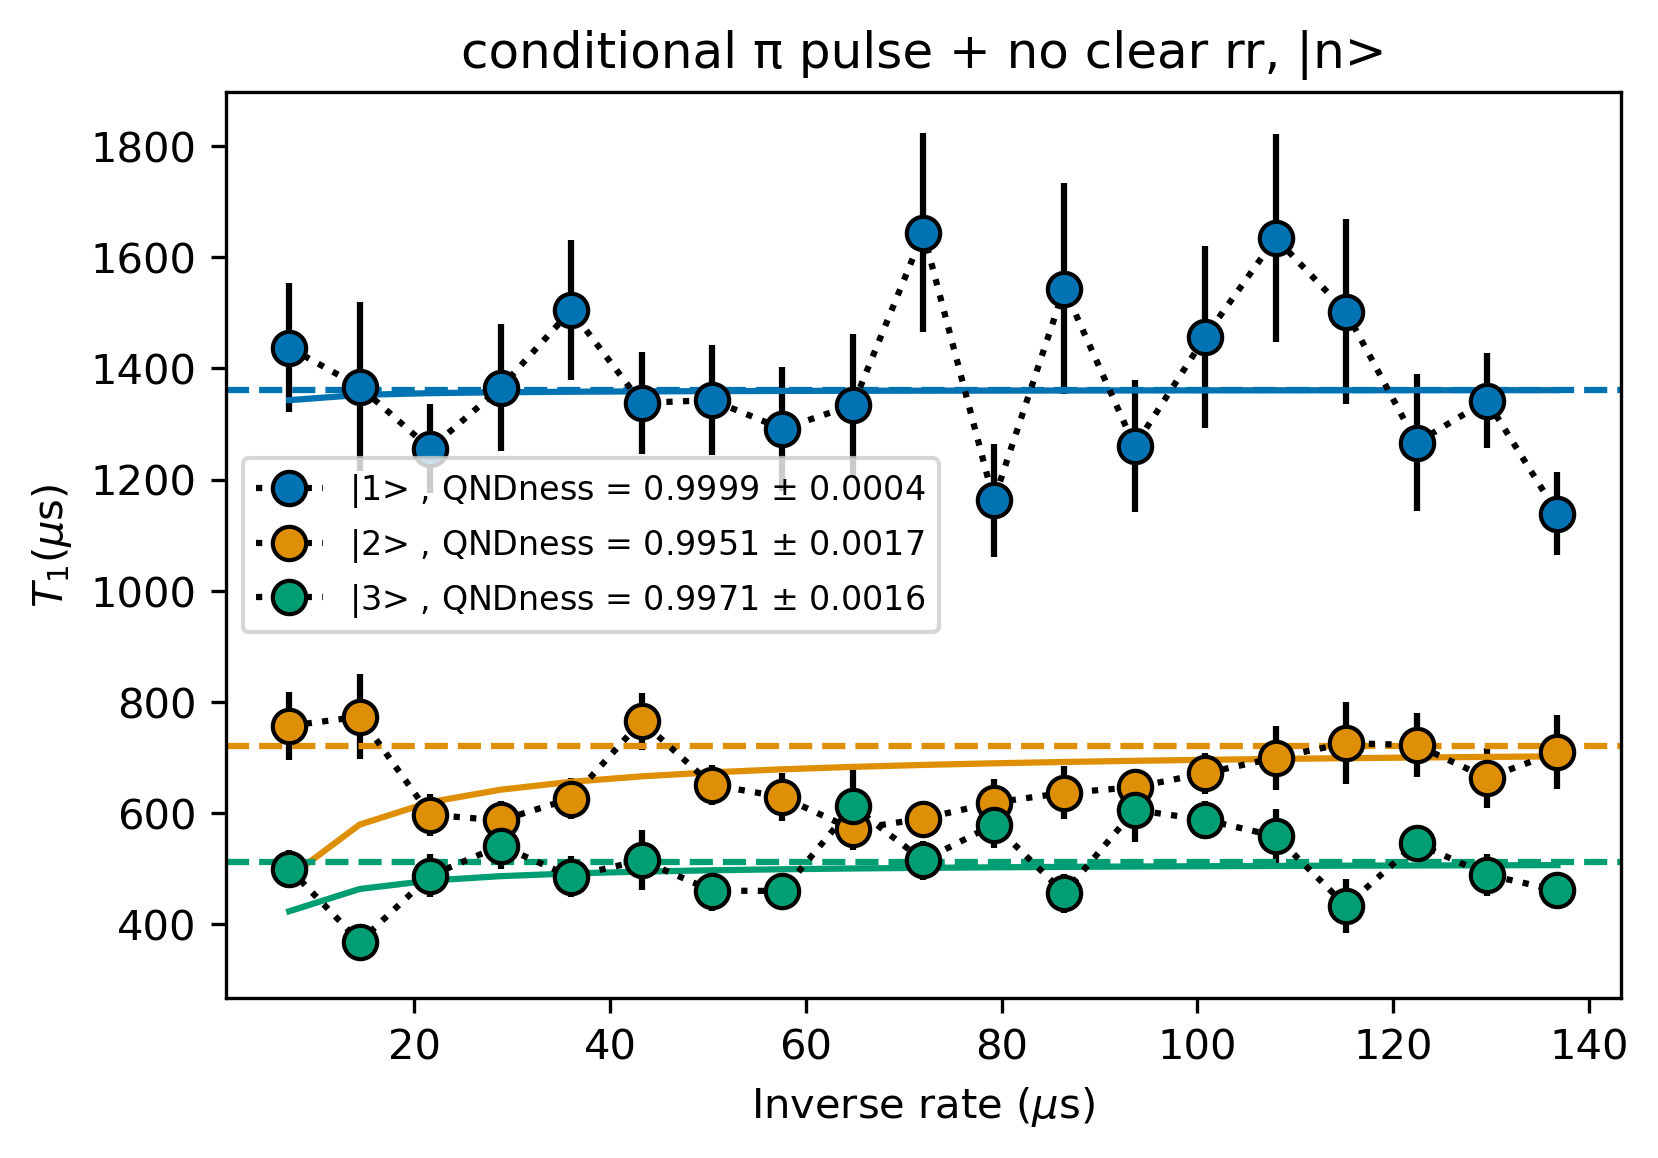

In [86]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
t1_ind = [1362, 720, 512]
def qndness(x, b):
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_qubit'
filelist = [6, 7, 8]

t1_rate = {}
t1_rate_err = {}

fig, axs = plt.subplots(1, 1, dpi=300)


qnd = []
qnd_err = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        if ii==0:
            t=2
        else:
            t = 0
        x = x[t:]
        t1_temp = []
        t1_err_temp = []
        for jj in range(len(Q)-1):
            y = Q[jj+1][t:]
            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1000, 0))
            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_temp.append(t1)
            t1_err_temp.append(t1_err)
        t1_rate['n%i'%(ii+1)] = t1_temp
        t1_rate_err['n%i'%(ii+1)] = t1_err_temp
        
        x = inv_rate[1:]
        t1 = t1_ind[ii]
        popt, pcov = curve_fit(qndness, x, t1_temp, sigma=t1_err_temp)
        
        qnd = np.round(1-popt[0], 4)
        qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
        
        axs.axhline(y=t1, linestyle='--', color=colors[ii])
        axs.errorbar(x, y=t1_temp, yerr= t1_err_temp, marker='o', markersize=8, 
                     linestyle='dotted', color='k', markerfacecolor=colors[ii], label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
        axs.plot(x, qndness(x, *popt),  color=colors[ii])
        axs.legend(fontsize=8)

axs.set_xlabel('Inverse rate ($\mu$s)')
axs.set_ylabel(r'$T_{1}(\mu$s)')
plt.title('conditional π pulse + no clear rr, |n>')
plt.show()

# Comparison b/w combo, rr, pi

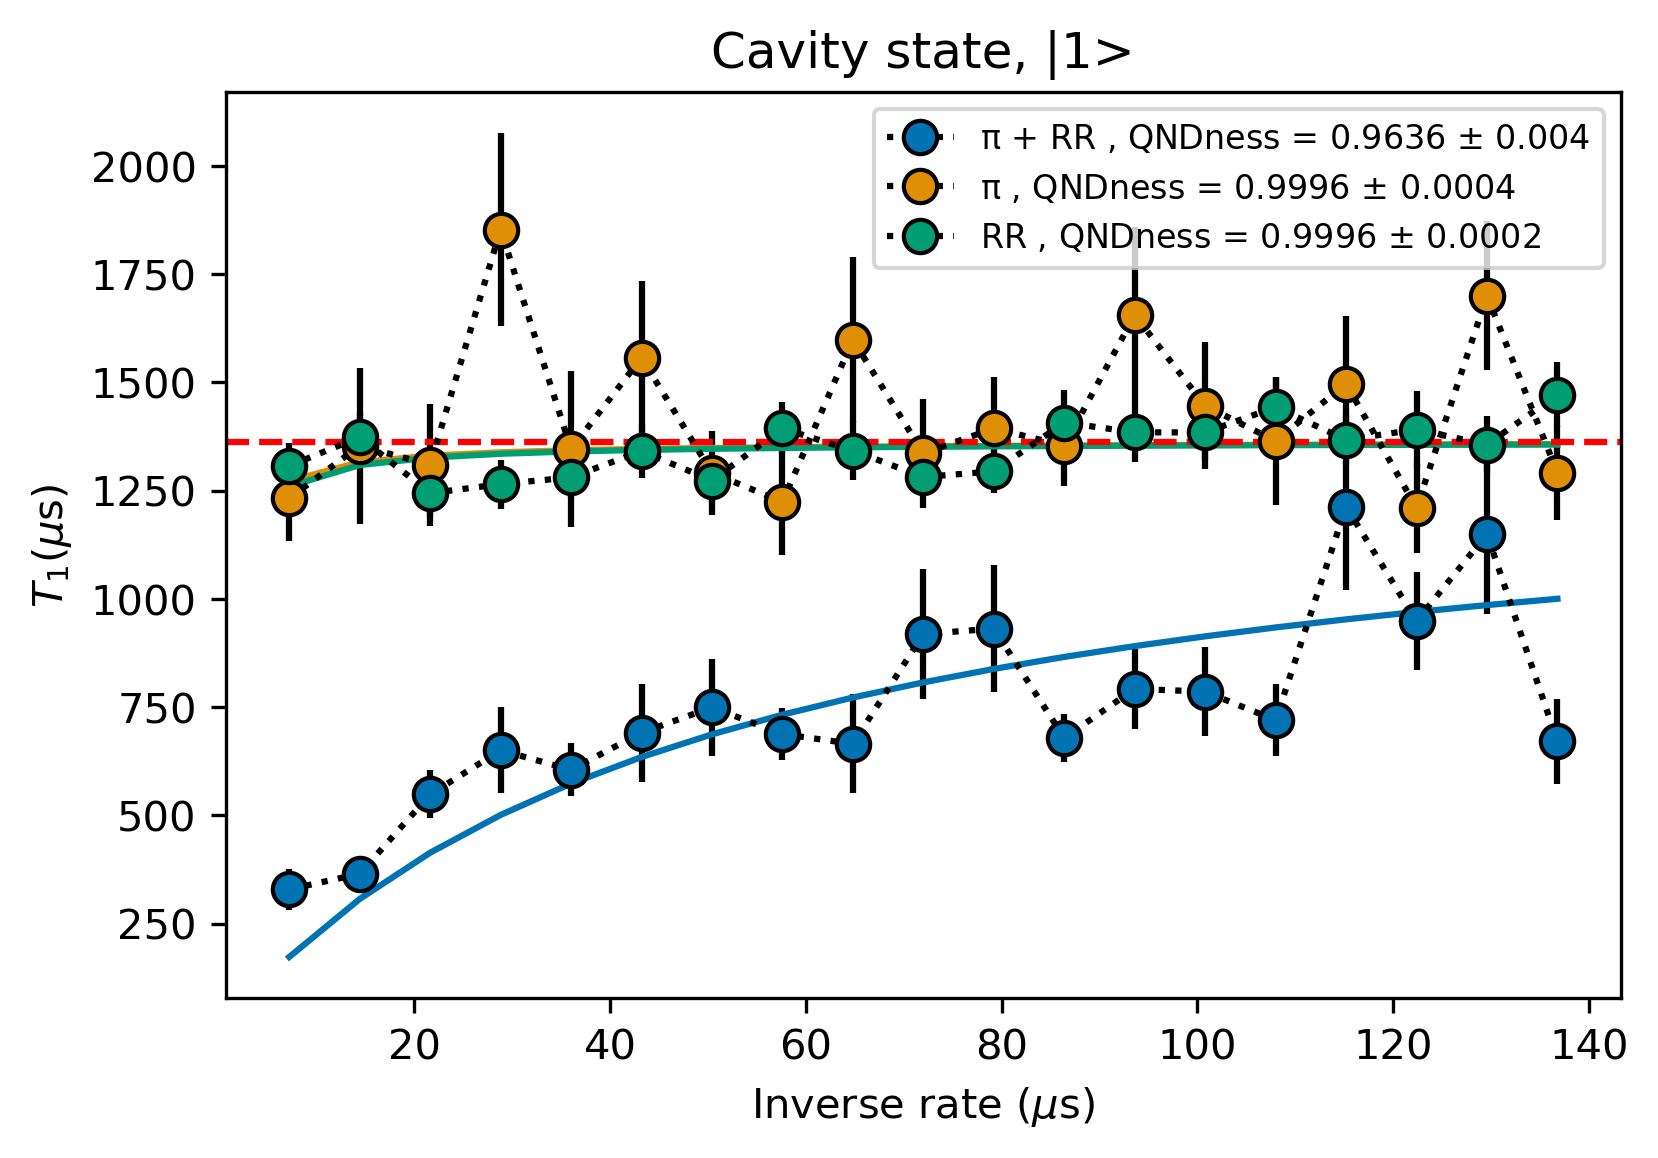

In [87]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
t1_ind = [1362, 1362, 1362]
def qndness(x, b):
    return 1/(1/t1 + b/x)

expt_name = ['storage_t1_qndness', 'storage_t1_qndness_qubit', 'storage_t1_qndness_readout']
filelist = [18, 12, 16]

t1_rate = {}
t1_rate_err = {}

fig, axs = plt.subplots(1, 1, dpi=300)
labels = ['π + RR', 'π', 'RR']
qnd = []
qnd_err = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name[ii].lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        if ii==1:
            t=3
        else:
            t=0
        x = x[t:]
        t1_temp = []
        t1_err_temp = []
        for jj in range(len(Q)-1):
            y = Q[jj+1][t:]
            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1000, 0))
            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_temp.append(t1)
            t1_err_temp.append(t1_err)
        t1_rate['n%i'%(ii+1)] = t1_temp
        t1_rate_err['n%i'%(ii+1)] = t1_err_temp
        
        x = inv_rate[1:]
        t1 = t1_ind[ii]
        popt, pcov = curve_fit(qndness, x, t1_temp, sigma=t1_err_temp)
        
        qnd = np.round(1-popt[0], 4)
        qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
        
        axs.errorbar(x, y=t1_temp, yerr= t1_err_temp, marker='o', markersize=8, 
                     linestyle='dotted', color='k', markerfacecolor=colors[ii], label='{} , QNDness = {} $\pm$ {}'.format(labels[ii], qnd, qnd_err ))
        axs.plot(x, qndness(x, *popt),  color=colors[ii])
        axs.legend(fontsize=8)

axs.axhline(y=t1, linestyle='--', color='r')
axs.set_xlabel('Inverse rate ($\mu$s)')
axs.set_ylabel(r'$T_{1}(\mu$s)')
plt.title('Cavity state, |1>')
plt.show()

#  QNDness, with a fast Pi

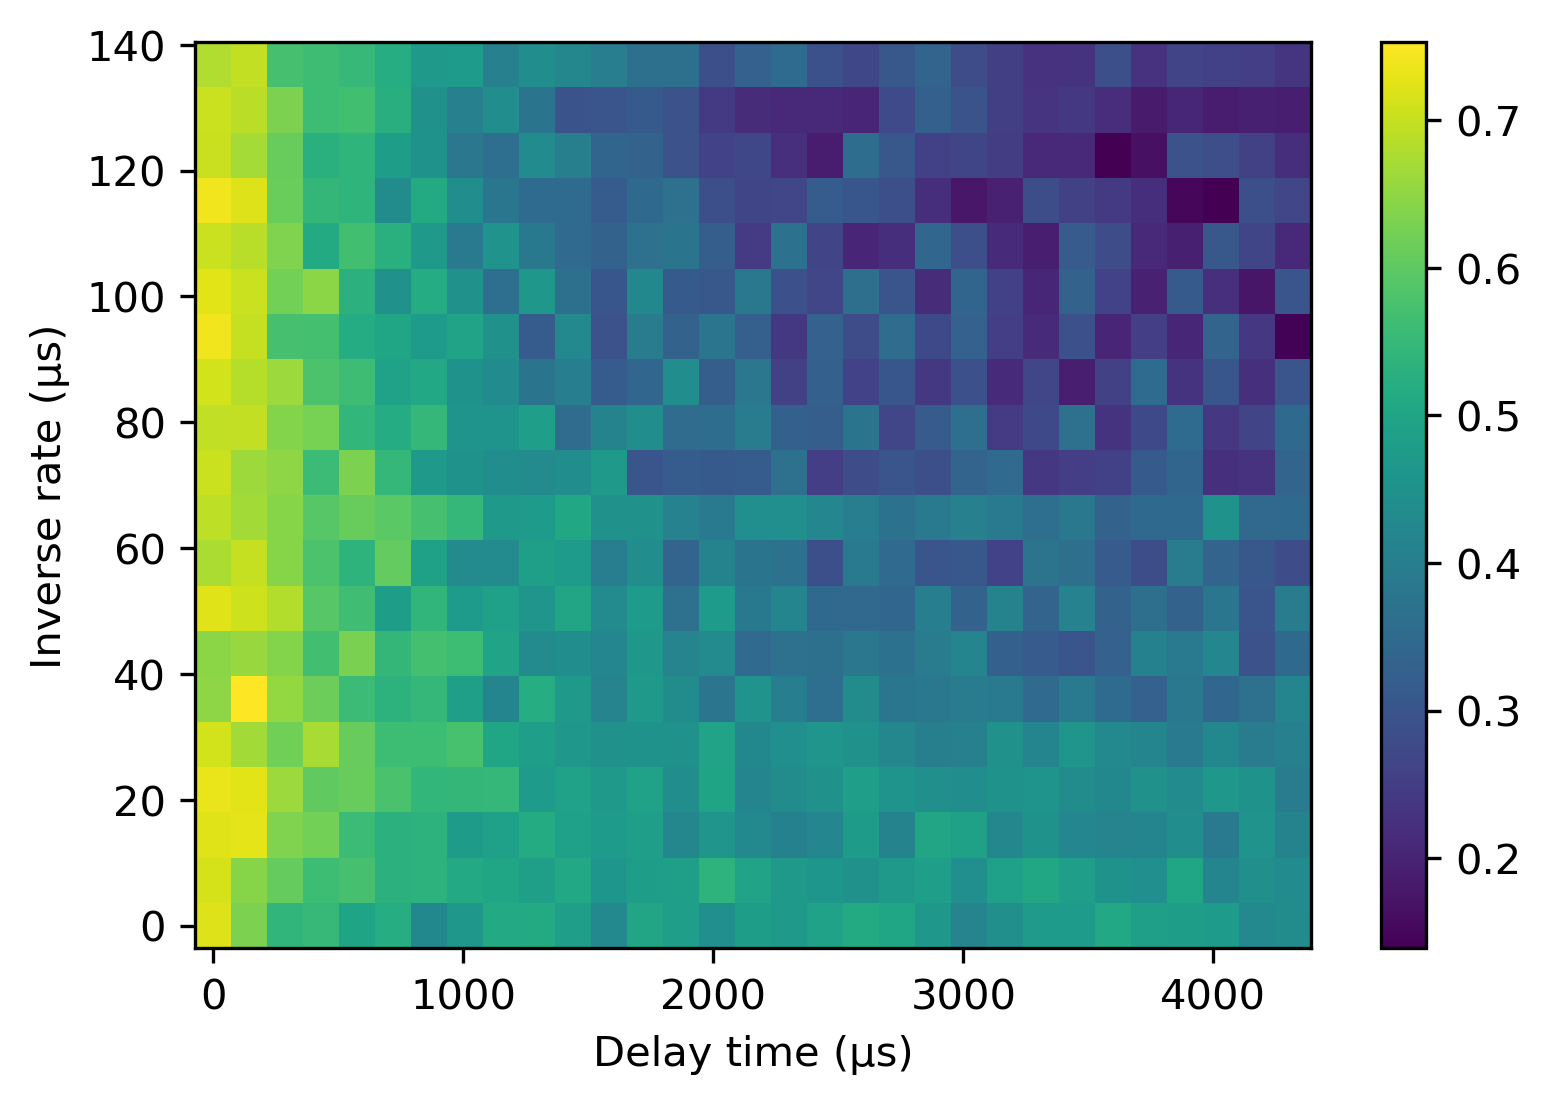

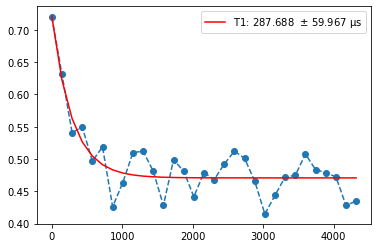

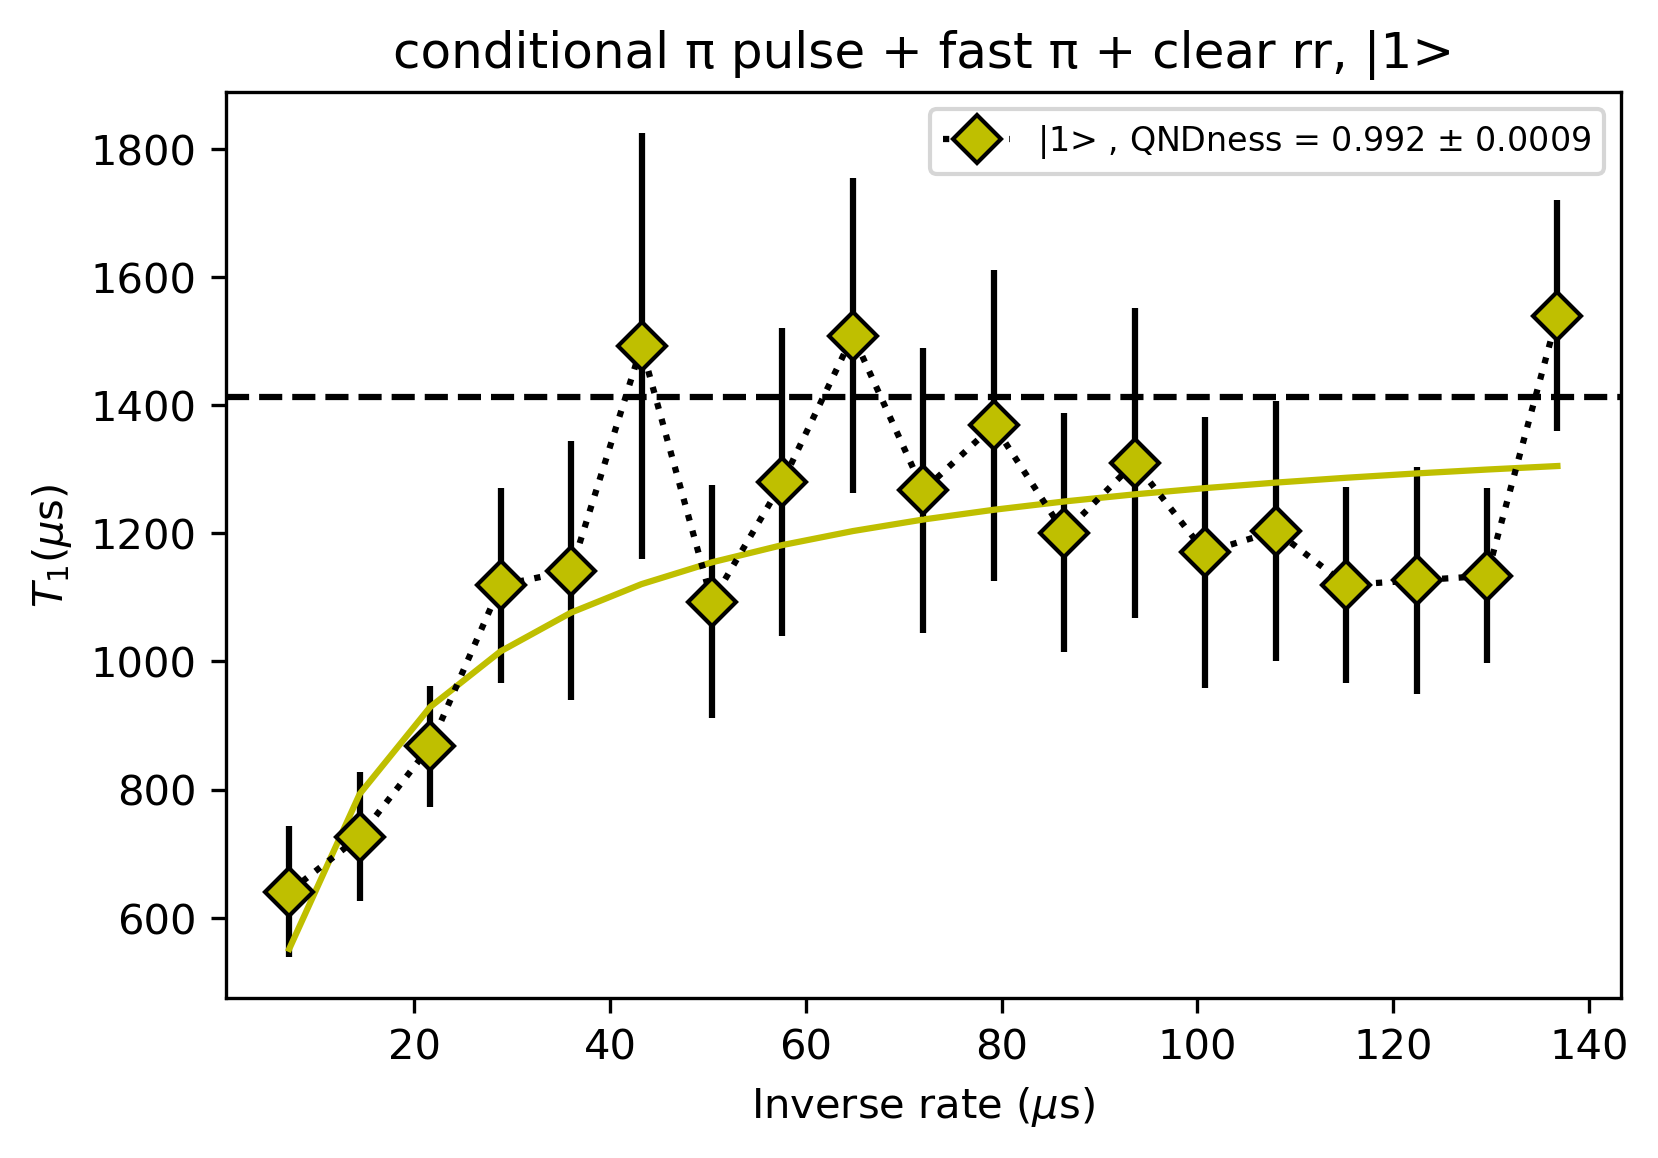

QNDness = 0.992


In [88]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
def qndness(x, b):
    t1 = 1412
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_fastpi'
filelist = [7]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im)
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')

        plt.show()
        
        t = 0
        x = x[t:]
        for jj in range(len(Q)-1):

            y = Q[jj+1][t:]

            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1200, 0))

            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)


popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate[1:]
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1412, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker=markers[ii], markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')

plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title('conditional π pulse + fast π + clear rr, |1>')
plt.legend(fontsize=8)
plt.show()

print("QNDness = %.3f"%(1-popt))

## Fast pi before a resolved pi

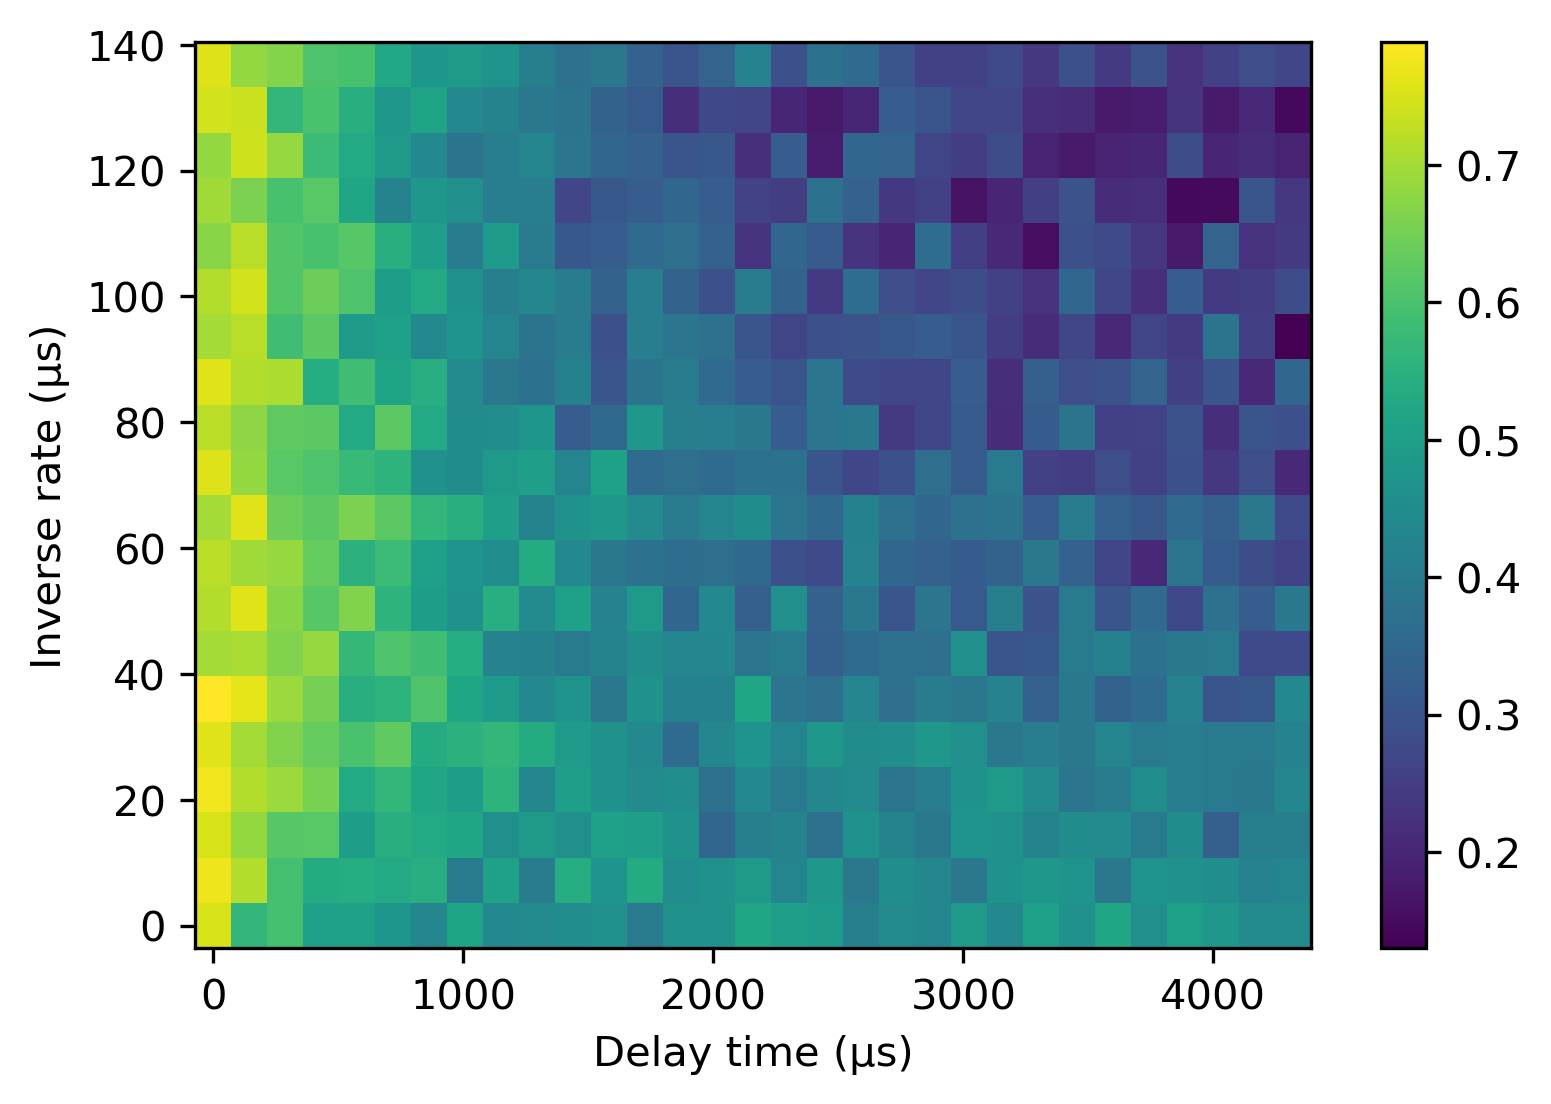

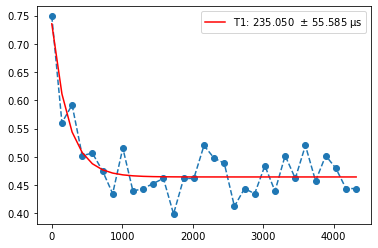

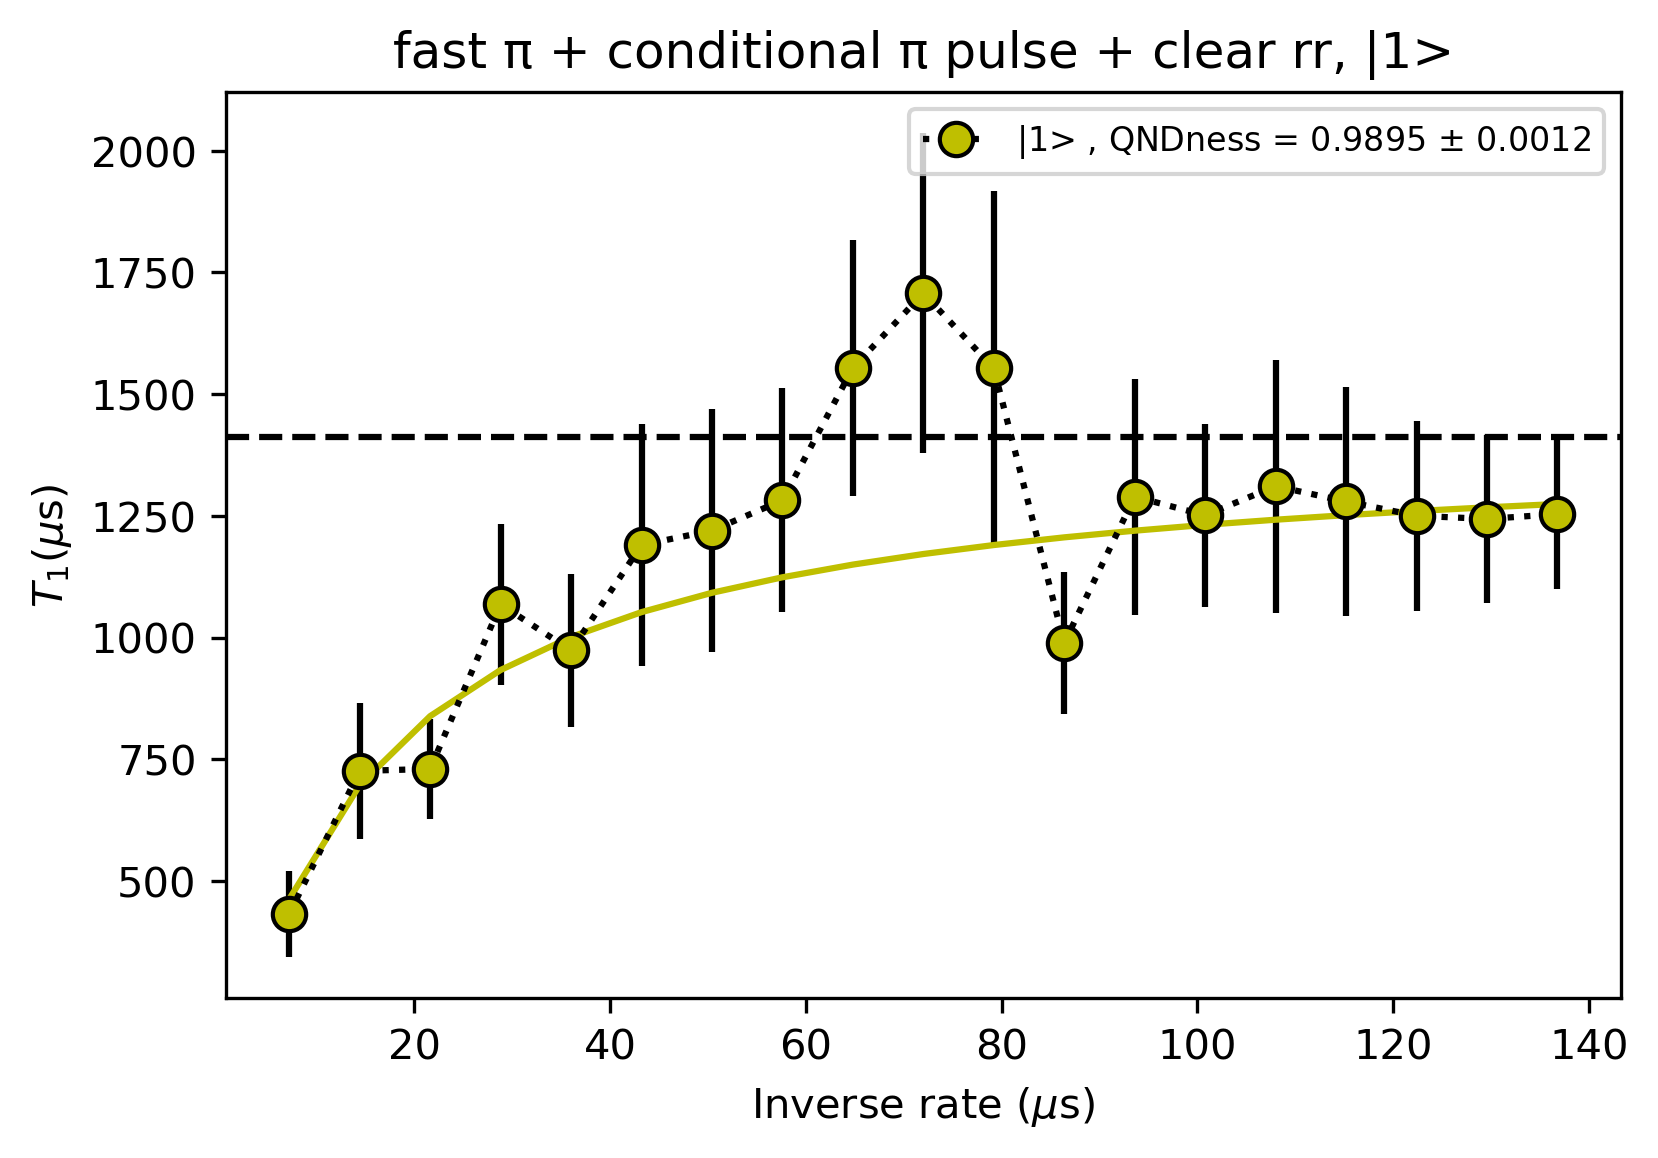

QNDness = 0.990


In [90]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
def qndness(x, b):
    t1 = 1412
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness_fastpi'
filelist = [6]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3 -7.20 #incorrectly added this in the wait time while saving the data
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im)
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')

        plt.show()
        
        t = 0
        x = x[t:]
        for jj in range(len(Q)-1):

            y = Q[jj+1][t:]
            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1200, 0))
            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)

popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate[1:]
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1412, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')

plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title('fast π + conditional π pulse + clear rr, |1>')
plt.legend(fontsize=8)
plt.show()

print("QNDness = %.3f"%(1-popt))

In [425]:
popt, pcov = curve_fit(expfunc_baseline, x, Q[2][t:], p0=(1, 1000, 0))

plt.plot(x, Q[2][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])


plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()


ValueError: operands could not be broadcast together with shapes (20,) (31,) 

In [423]:
np.argmax(t1_rate)

10

## Alpha

Energy decay of the storage cavity prepared in a coherent state with $\alpha$, measured with a selective $\pi$ pulse centered around n=0. 
\begin{equation}
P_{e} \sim  e^{-|\alpha|^{2} e^{-\kappa * t}}
\end{equation}

<ipython-input-19-5e734f8802e0>:15: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-alpha**2*np.exp(-k*t))


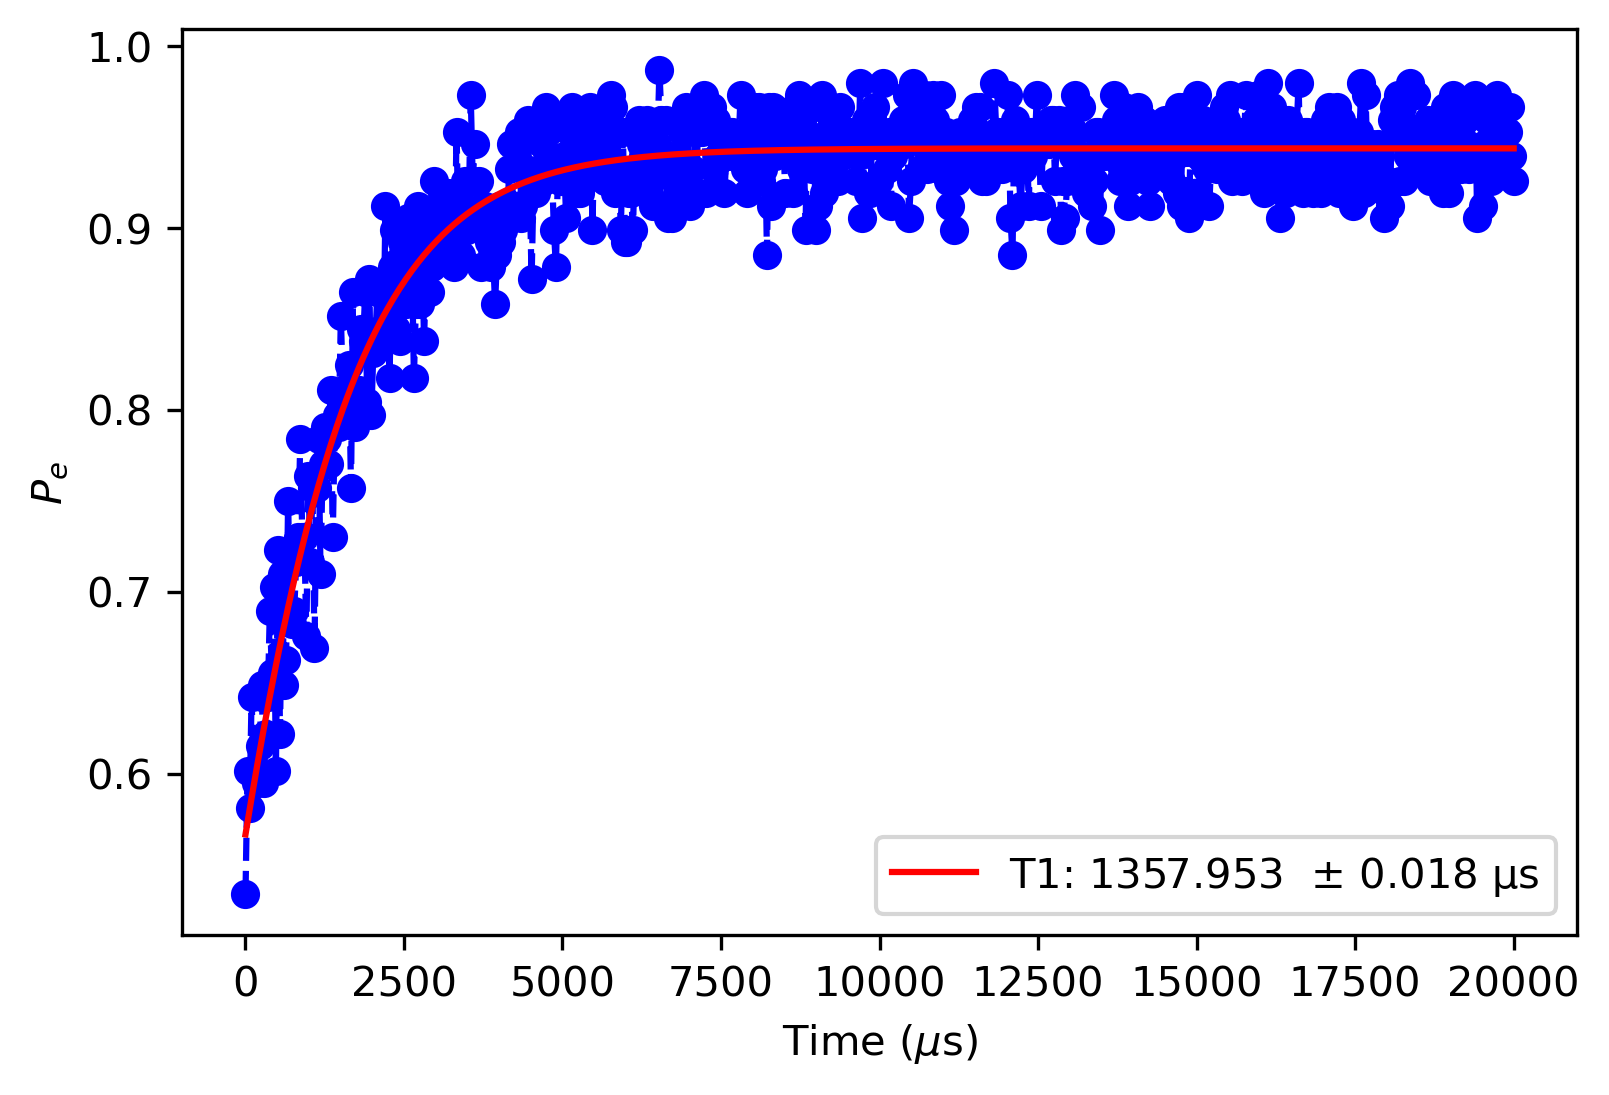

In [33]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)


"""
expt_name = 'storage_mode_t1'
filelist = [1]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        cav_len = array(a['cav_len'])
        cav_amp = array(a['cav_amp'])
        
        fig, ax = plt.subplots(1, 1, dpi=300)
        y = Q

        popt, pcov = curve_fit(storage_t1, x, y)
        ax.plot(x, y, 'bo--')
        t1 = 1/(popt[1])
        t1_err = np.sqrt(np.diag(pcov)[1])/popt[1]
        ax.plot(x, storage_t1(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel(r'$P_{e}$')
        ax.legend()
        plt.show()

In [34]:
alpha

0.7145481862660984

In [35]:
alpha_awg_cal(cav_amp=1.0, cav_len=40)

0.7145481862660984

In [32]:
np.sqrt(np.diag(pcov)[1])/popt[1]

0.018286771849665217

# QNDness for n=0 state

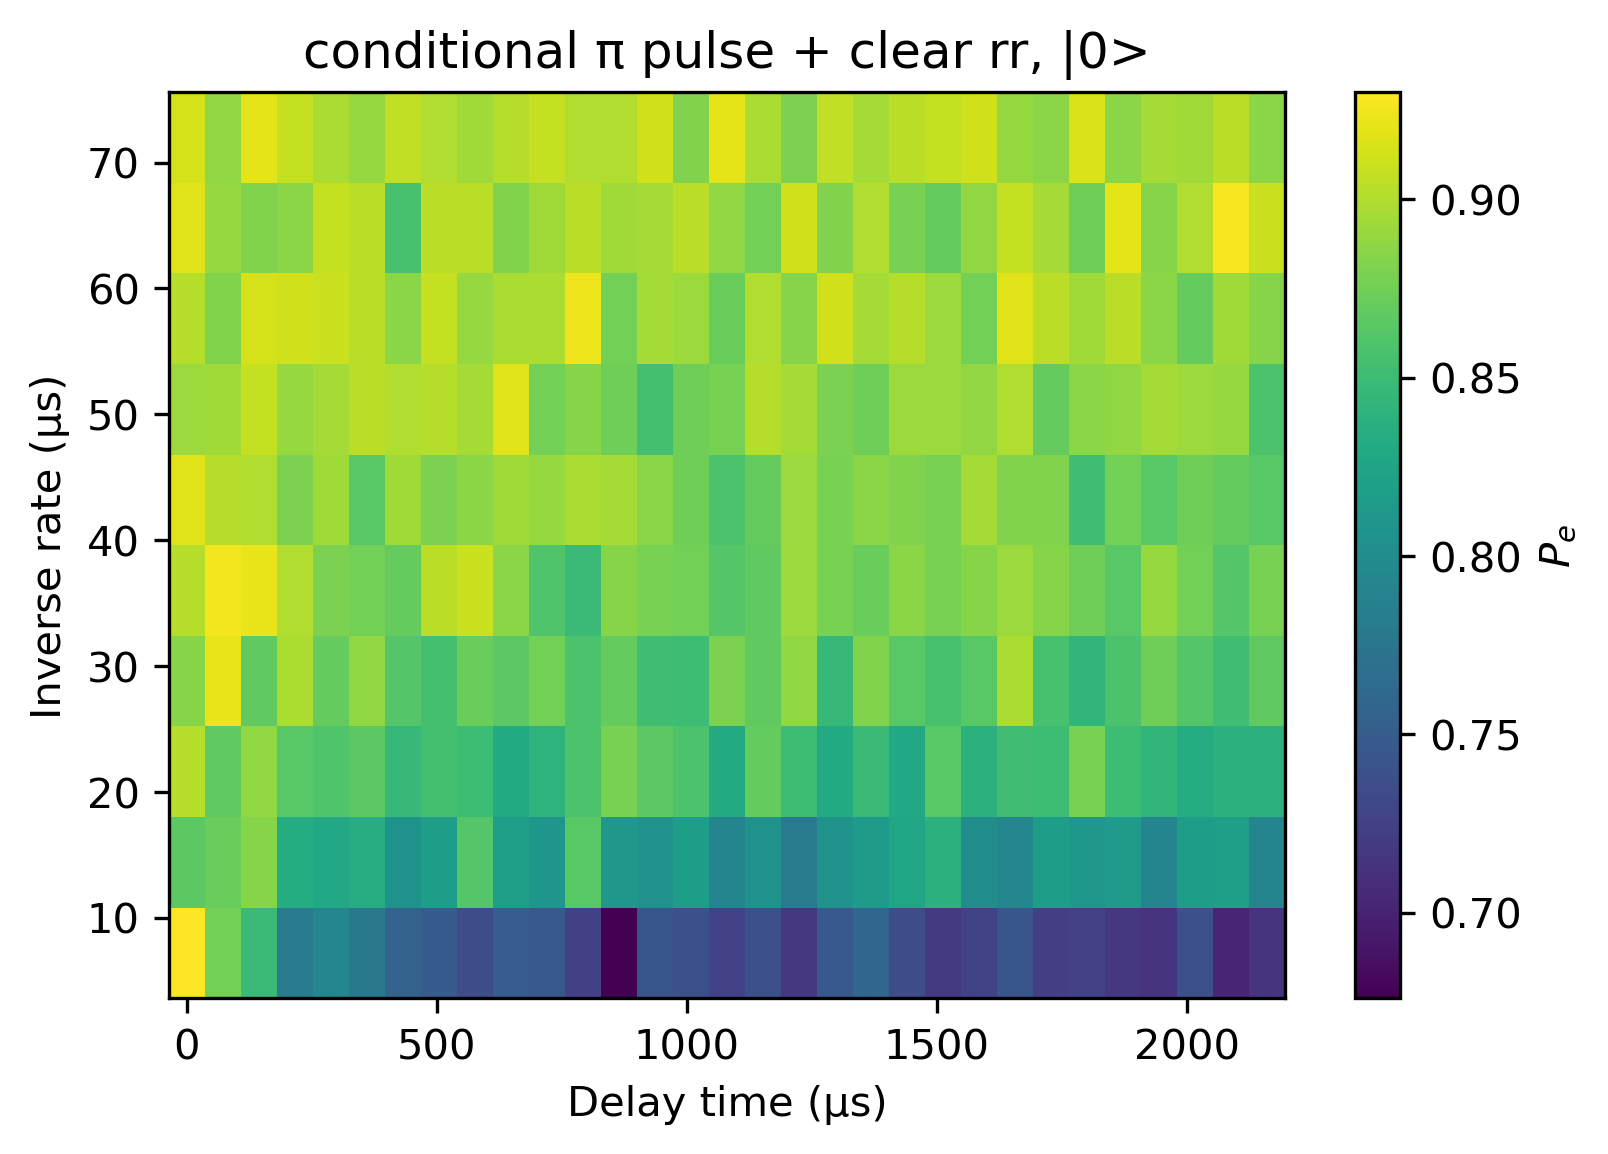

C:\Users\slab\AppData\Local\Temp\ipykernel_27016\2029631603.py:36: RuntimeWarning: invalid value encountered in sqrt
  t1_err = np.sqrt(np.diag(pcov)[1])


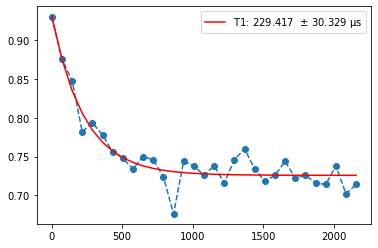

C:\ProgramData\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


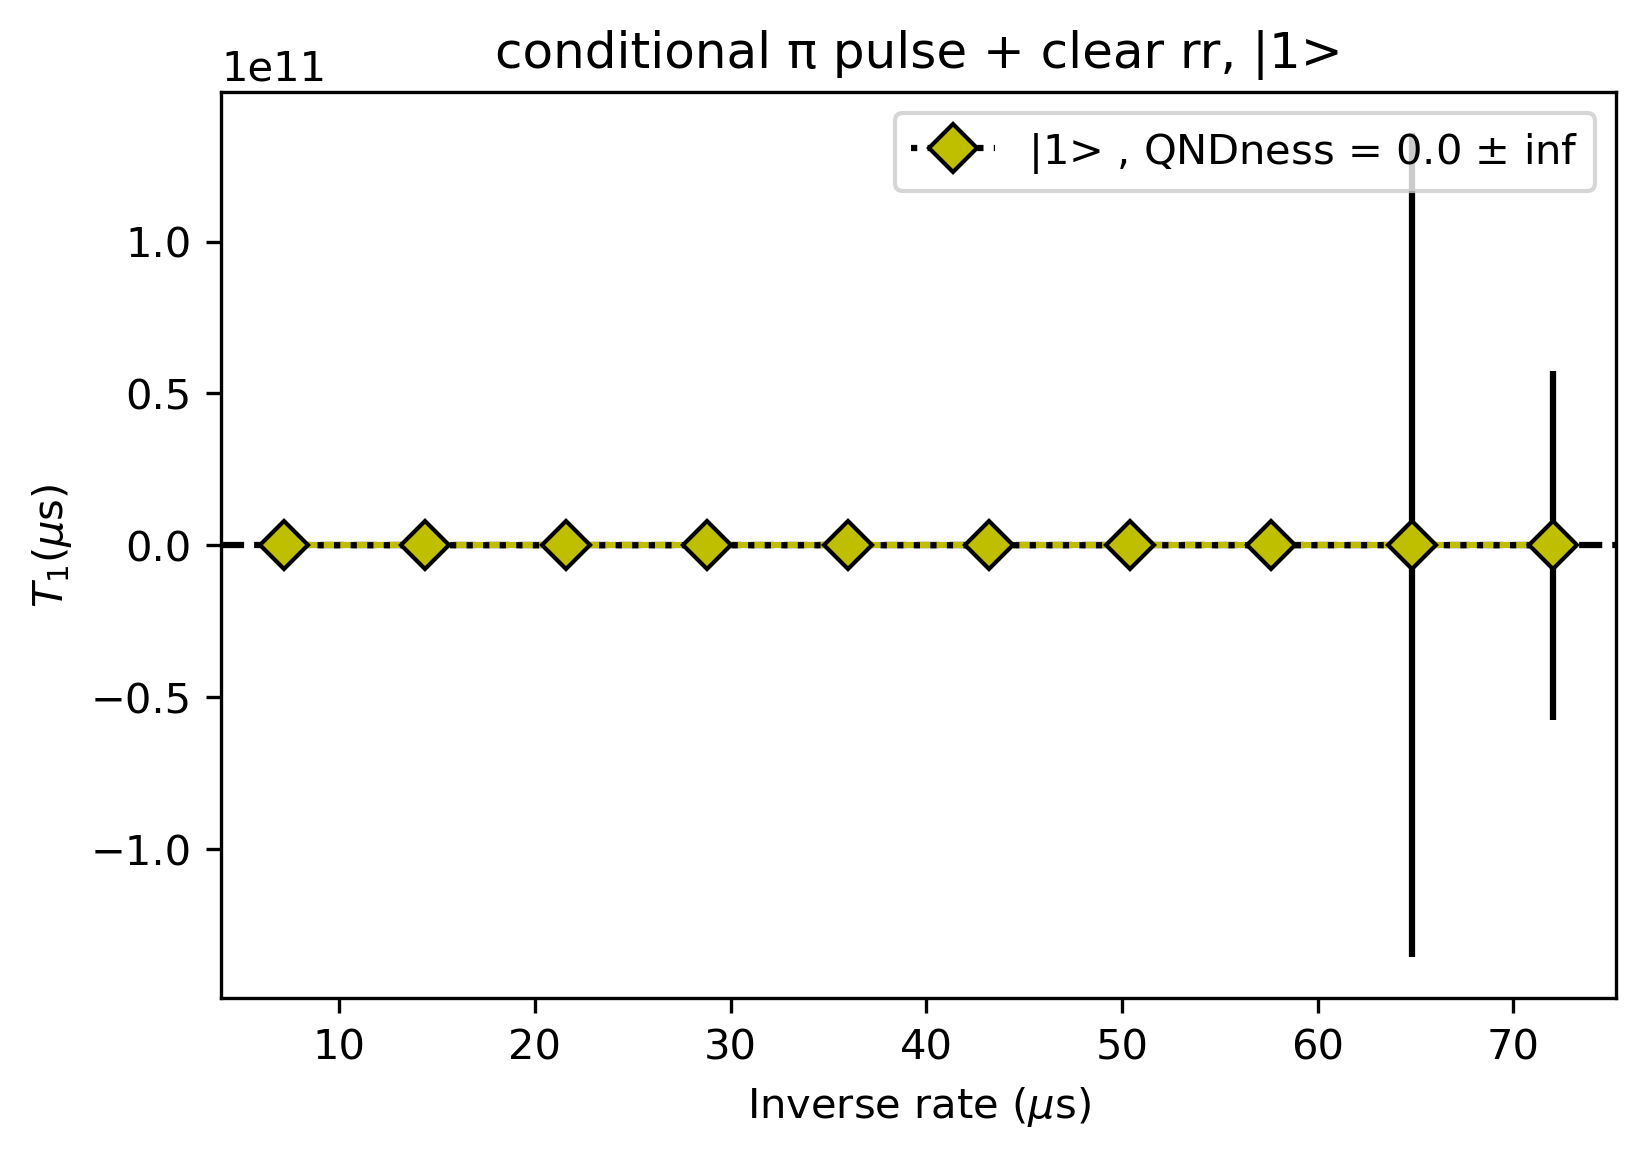

QNDness = 0.000


In [46]:
"""Based off of Yvonner's thesis Fig. 3.7, eq (3.2)

"""
def qndness(x, b):
    t1 = 1362
    return 1/(1/t1 + b/x)

expt_name = 'storage_t1_qndness'
filelist = [20]

t1_rate  =[]
t1_rate_err  =[]

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        I = array(a['I'])
        Q = array(a['res'])
        x = array(a['time'])/1e3
        inv_rate = array(a['inv_rate'])/1e3
        
        fig, axs = plt.subplots(dpi=300)
        im = axs.pcolormesh(x, inv_rate, Q, shading='auto')
        plt.colorbar(im, label=r'$P_{e}$')
        plt.xlabel('Delay time (μs)')
        plt.ylabel('Inverse rate (μs)')
        plt.title('conditional π pulse + clear rr, |0>')

        plt.show()        
        x = x[:]
        for jj in range(len(Q)):
            y = Q[jj][:]
            popt, pcov = curve_fit(expfunc_baseline, x, y, p0=(1, 1000, 0))
            t1 = (popt[1])
            t1_err = np.sqrt(np.diag(pcov)[1])
            t1_rate.append(t1)
            t1_rate_err.append(t1_err)

t=0
popt, pcov = curve_fit(expfunc_baseline, x, Q[0][t:], p0=(1, 1000, 0))
plt.plot(x, Q[0][t:], 'o--')
t1 = (popt[1])
t1_err = np.sqrt(np.diag(pcov)[1])
plt.plot(x, expfunc_baseline(x, *popt), 'r-', label=r"T1: %.3f  $\pm$ %.3f μs"%(t1, t1_err))
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel(r'$P_{e}$')
plt.legend()
plt.show()

x = inv_rate
popt, pcov = curve_fit(qndness, x, t1_rate, sigma=t1_rate_err)
plt.figure(dpi=300)
plt.axhline(y=1362, linestyle='--', color='k')
qnd = np.round(1-popt[0], 4)
qnd_err = np.round(np.sqrt(np.diag(pcov)[0]), 4)
plt.errorbar(x, y=t1_rate, yerr= t1_rate_err, marker='D', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y', label='|{}> , QNDness = {} $\pm$ {}'.format(ii+1, qnd, qnd_err ))
plt.plot(x, qndness(x, *popt),  color='y')
plt.xlabel('Inverse rate ($\mu$s)')
plt.ylabel(r'$T_{1}(\mu$s)')
plt.title('conditional π pulse + clear rr, |1>')
plt.legend()
plt.show()

print("QNDness = %.3f"%(1-popt))

# Qubit T1 as a function of coherent state in the cavity

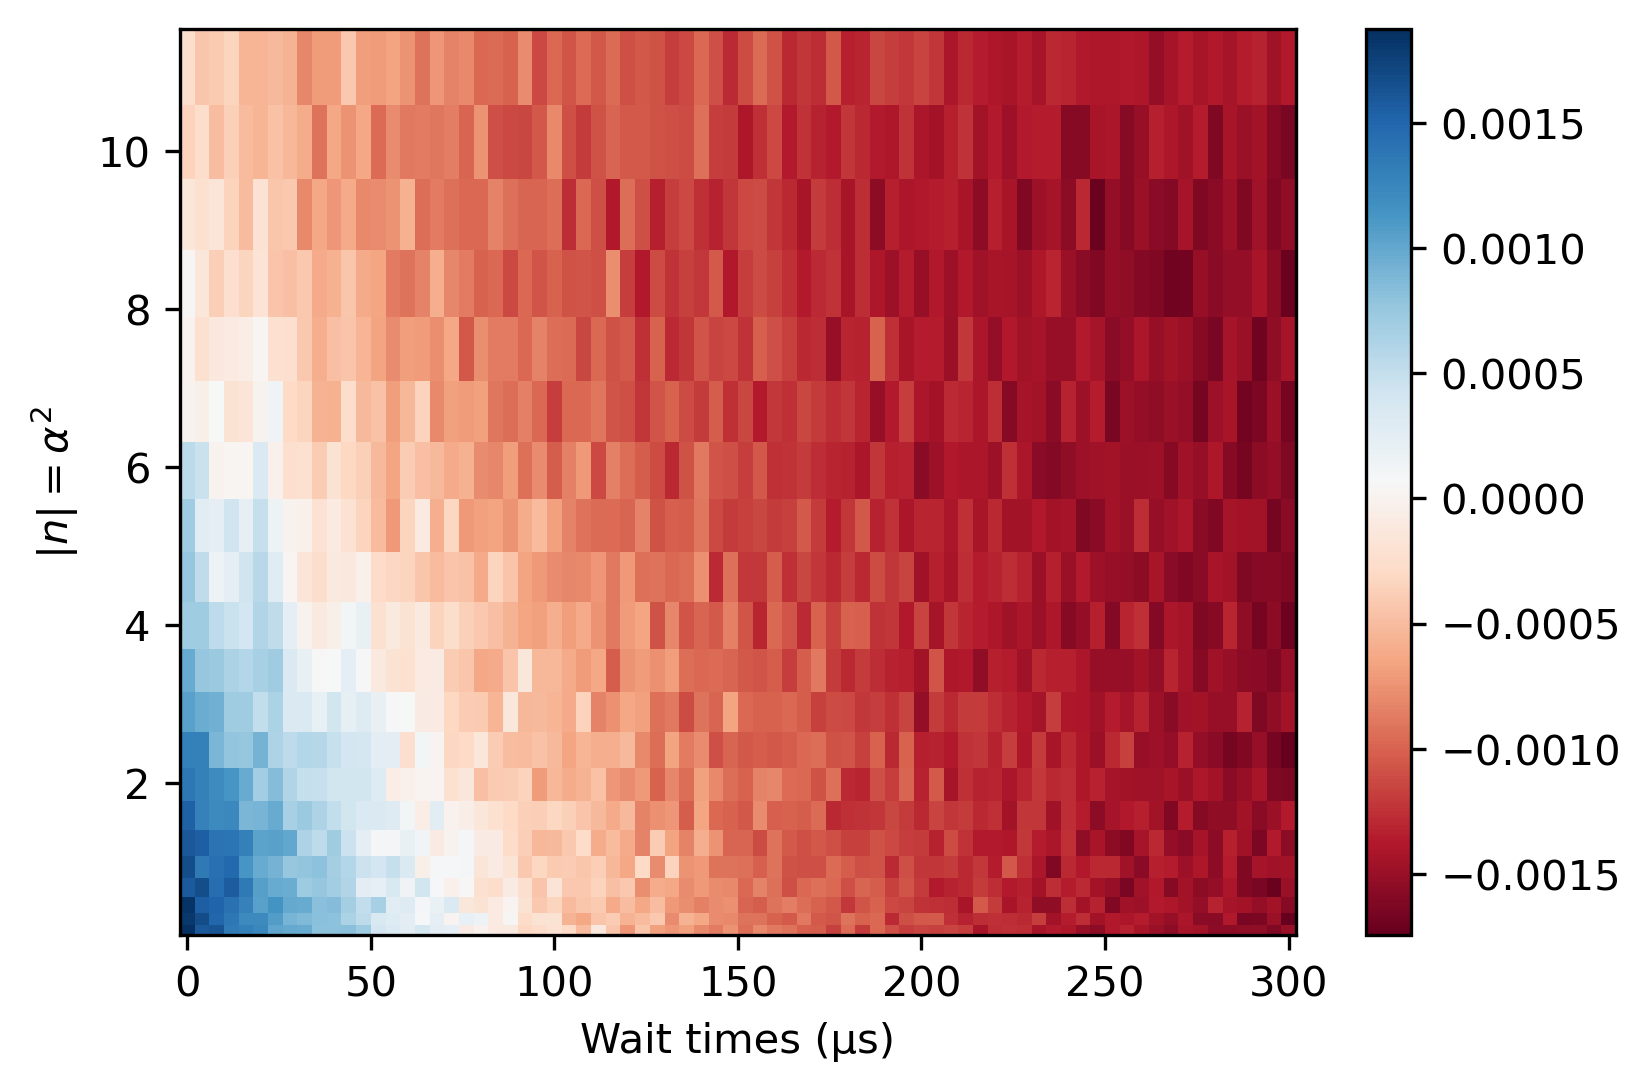

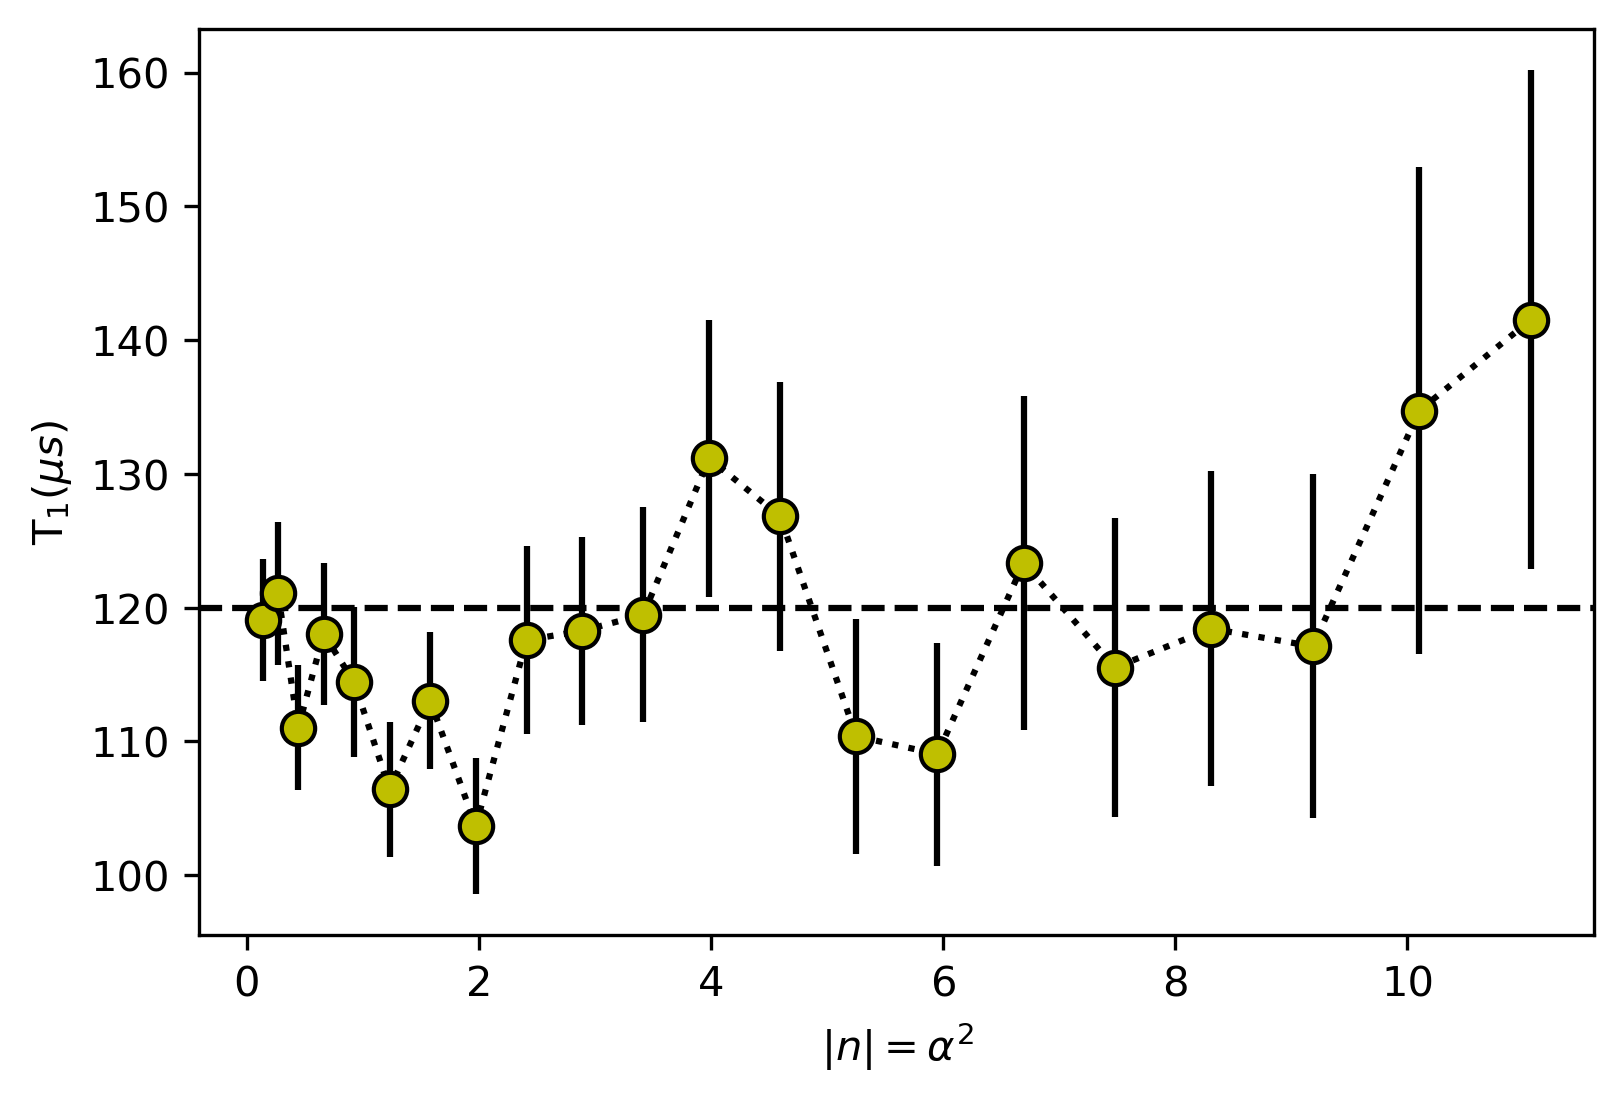

In [40]:
def t1(x, y):
    popt, pcov = curve_fit(expfunc_baseline, x, y)
    return popt[1], np.sqrt(np.diag(pcov)[1])

expt_name = 't1_alpha'
filelist = [4]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        data = array(a['I'])
        wait_times = array(a['time'])
        alphas = array(a['alphas'])
        
        fig, ax = plt.subplots(1, 1, dpi=300)
        d = plt.pcolormesh(wait_times, alphas**2, data, cmap='RdBu', shading='auto')
        plt.colorbar()
        plt.xlabel('Wait times (μs)')
        plt.ylabel(r'$|n| = \alpha^{2}$')
        plt.show()

        fig, ax = plt.subplots(1, 1, dpi=300)

        df = pd.DataFrame(data)
        fit_data = df.apply(lambda row: t1(wait_times, row), axis=1)
        t1_alpha = [f[0] for f in fit_data]
        t1_alpha_err = [f[1] for f in fit_data]
        ax.errorbar(alphas**2, y = t1_alpha, yerr=t1_alpha_err, marker='o', markersize=8, 
             linestyle='dotted', color='k', markerfacecolor='y')
        ax.axhline(y=120, color='k', linestyle='--')
        ax.set_ylabel(r'$\mathrm{T_{1}} (μs)$')
        ax.set_xlabel(r'$|n| = \alpha^{2}$')
        plt.show()


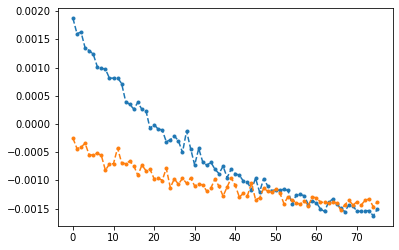

In [183]:
plt.plot(data[0], '.--')
plt.plot(data[-1], '.--')

## SNAP Fock prep

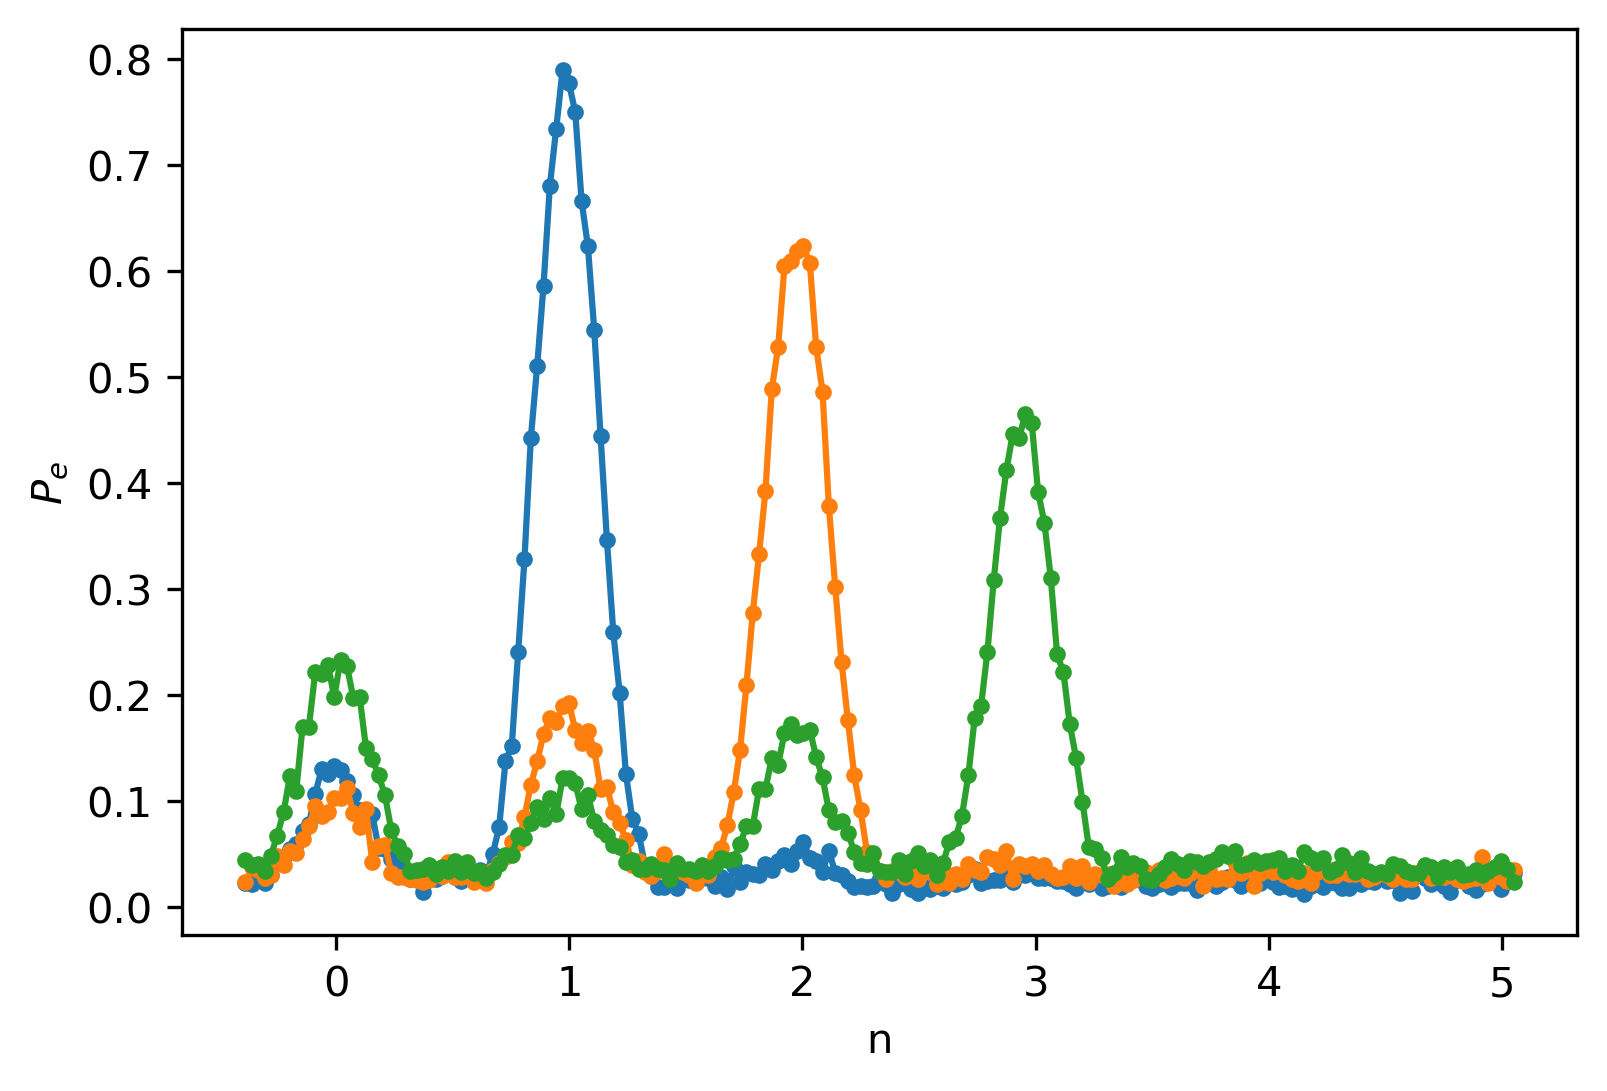

In [256]:
expt_name = 'snap_fock_prep'
filelist = [0, 1, 2]
plt.figure(dpi=300)

p_cav = [[10.75, 55.85, 20.55, 12.85], [22.15, 9.45, 52.55, 15.85], [30.2, 27.5, 11.95, 30.35]]

for ii, i in enumerate(filelist):
    filename = "..\\data\\thesis\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        two_chi = a['two_chi']
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()        
        plt.plot(freqs, Q, '.-')
#         plt.plot(np.array(p_cav[ii])/100, 'D')

plt.xlabel('n')
plt.ylabel(r'$P_{e}$')
plt.show()

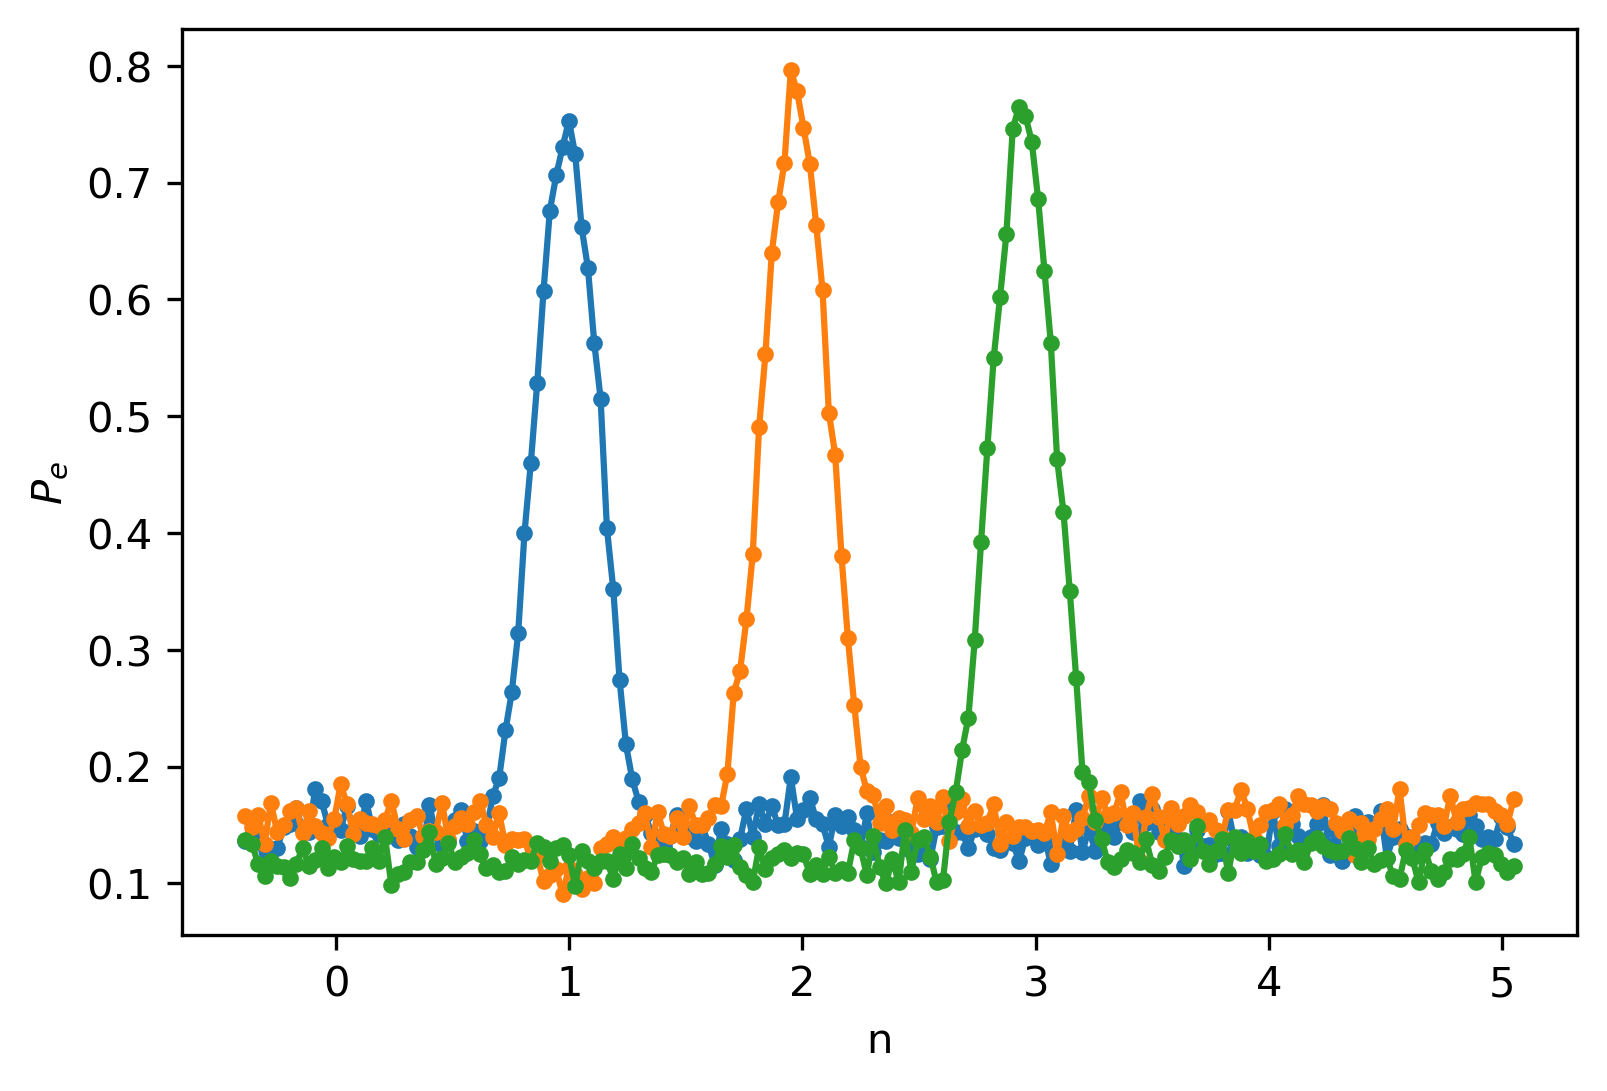

In [264]:
expt_name = 'fock_state_oct'
filelist = [0, 1, 2]
plt.figure(dpi=300)

p_cav = [[10.75, 55.85, 20.55, 12.85], [22.15, 9.45, 52.55, 15.85], [30.2, 27.5, 11.95, 30.35]]

for ii, i in enumerate(filelist):
    filename = "..\\data\\thesis\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        two_chi = a['two_chi']
        freqs = (np.array(a['freq'])-93304128)[:]/two_chi
        a.close()        
        plt.plot(freqs, Q, '.-')
#         plt.plot(np.array(p_cav[ii])/100, 'D')

plt.xlabel('n')
plt.ylabel(r'$P_{e}$')
plt.show()

0.86
0.797


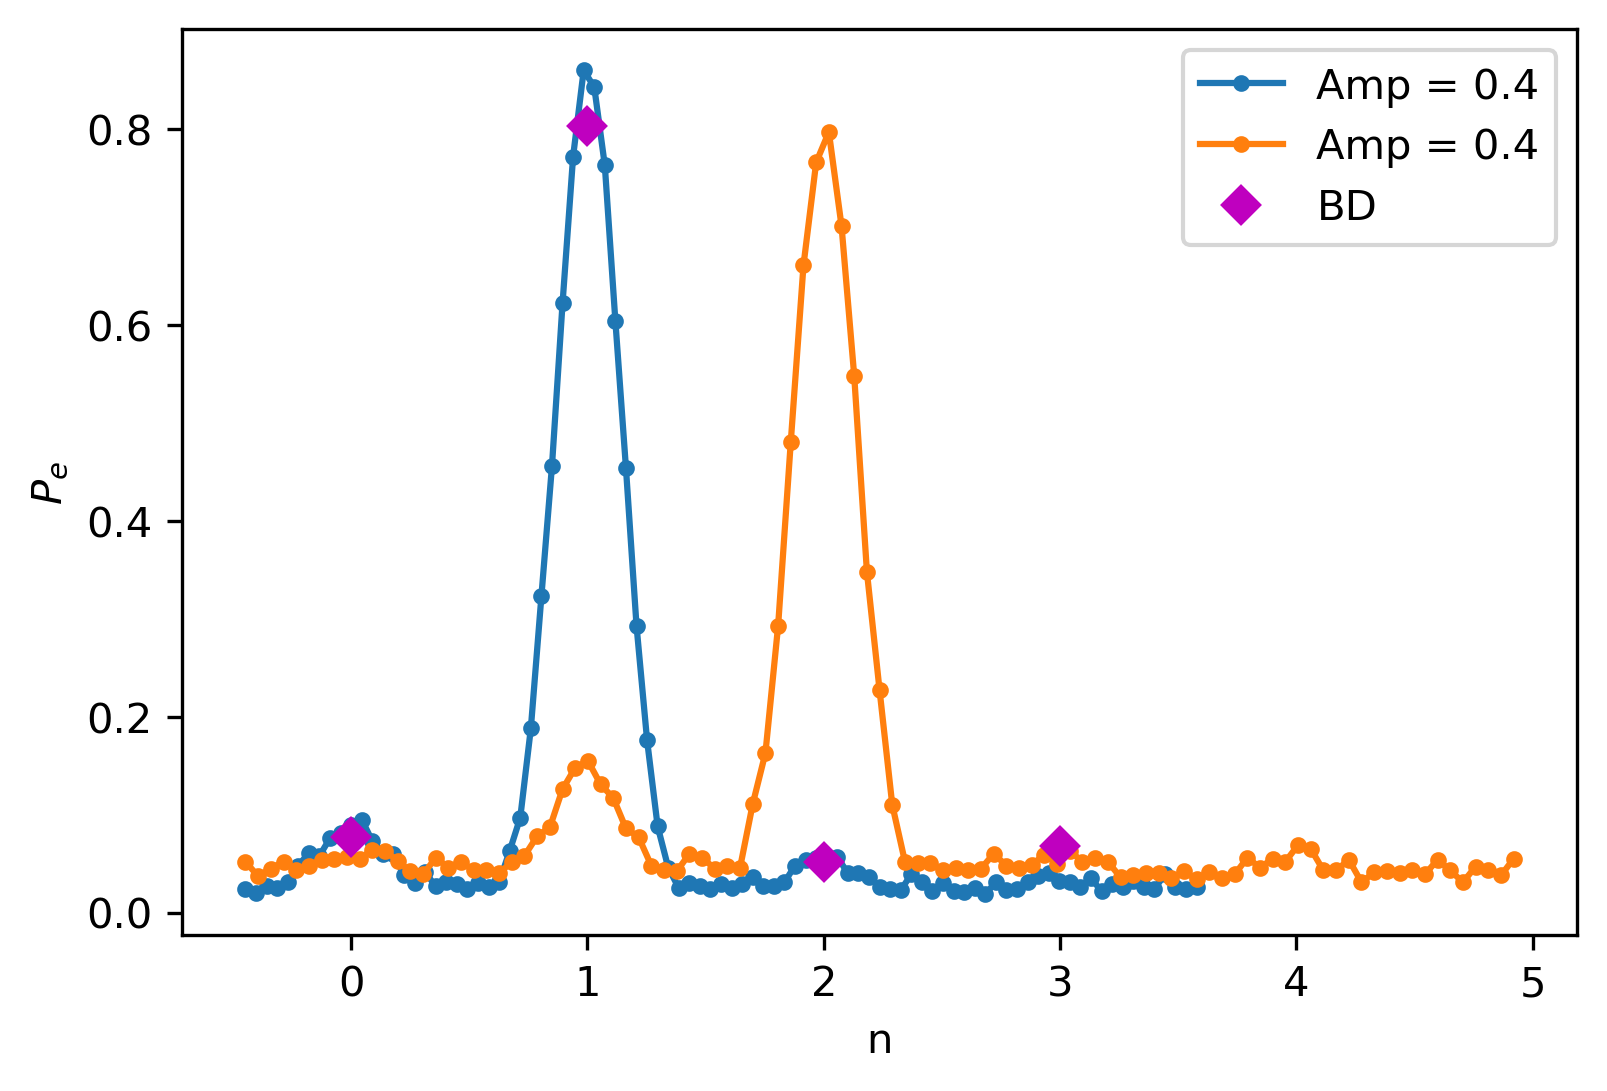

In [215]:
expt_name = 'snap_fock_prep'
filelist = [19, 23]
two_chi = -1.118e6
cal = [0.9205, 0.002]
# 0.9205 0.002
plt.figure(dpi=300)
amp = [0.4, 0.4]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
    plt.plot(freqs, Q, '.-', label='Amp = {}'.format(amp[ii]))
    print(np.max(Q))

plt.plot([0 ,1, 2, 3],np.array([ 1158, 12054,   775,  1013])/15000, 'Dm', label='BD')
plt.xlabel('n')
plt.ylabel(r'$P_{e}$')
plt.legend(loc='best')
plt.show()

0.86
0.797


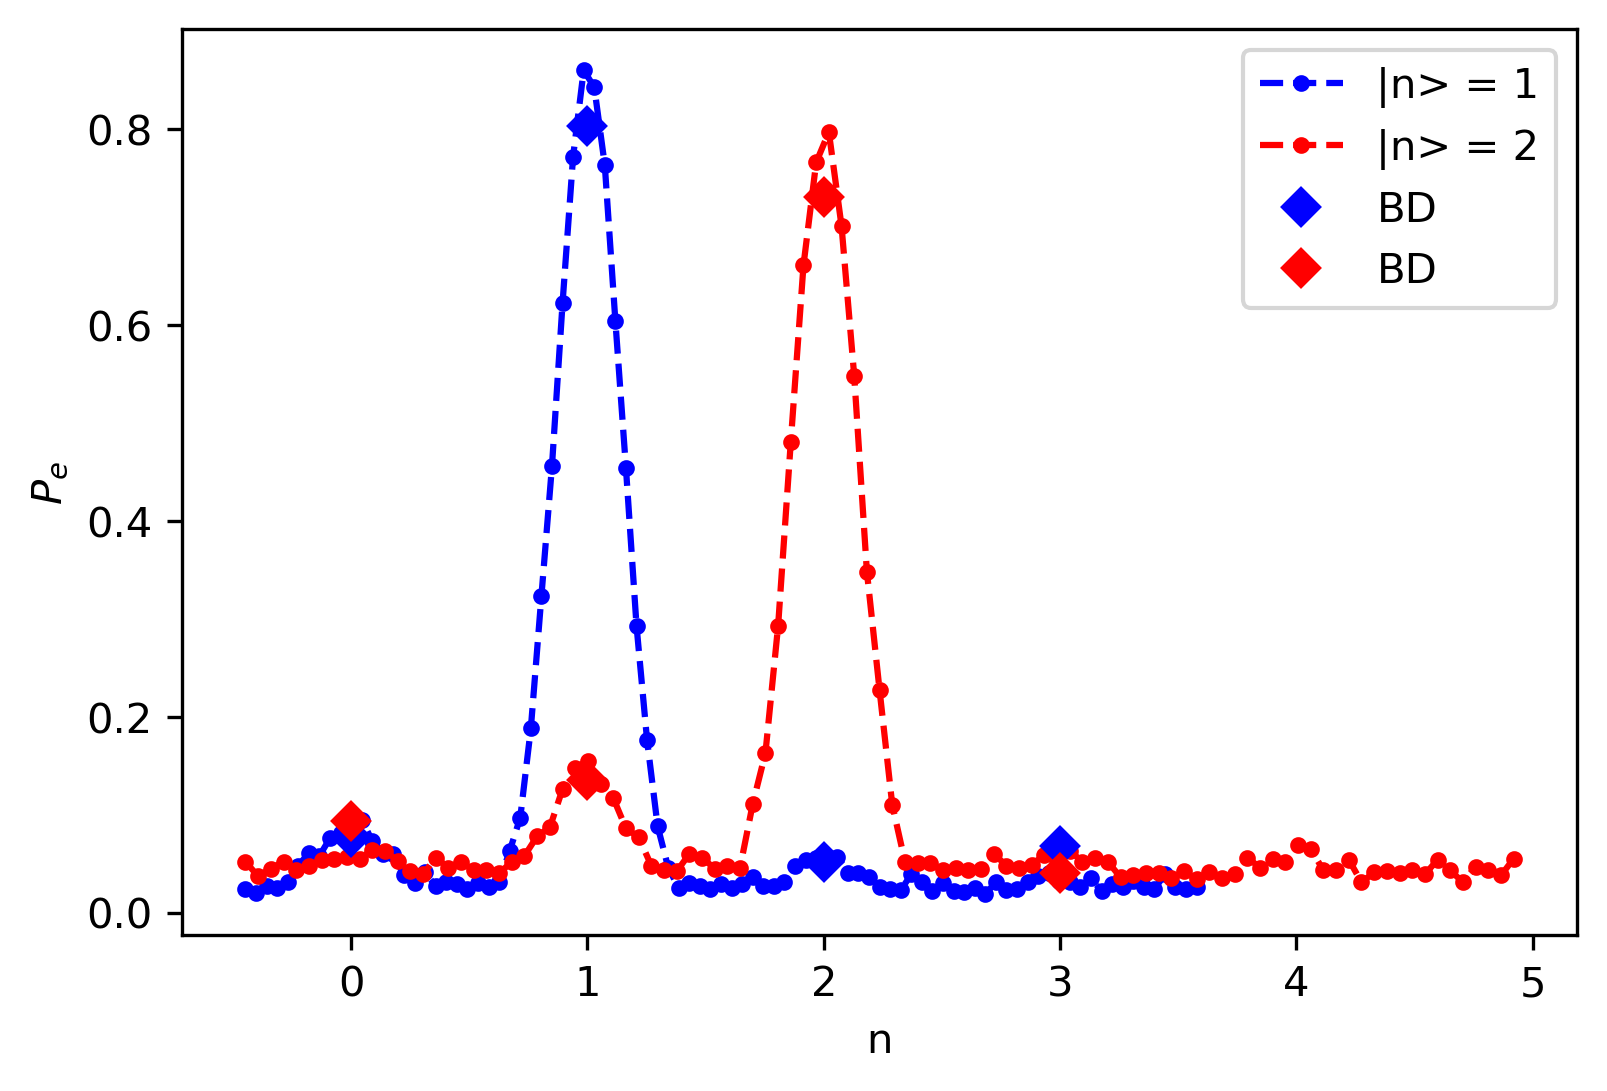

In [37]:
expt_name = 'snap_fock_prep'
filelist = [19, 23]
two_chi = -1.118e6
cal = [0.9205, 0.002]
# 0.9205 0.002
plt.figure(dpi=300)
amp = [1, 2]
color = ['b', 'r']
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
    plt.plot(freqs, Q, color = color[ii], marker='.', linestyle='--', label='|n> = {}'.format(amp[ii]))
    print(np.max(Q))

plt.plot([0 ,1, 2, 3],np.array([ 1158, 12054,   775,  1013])/15000, 'Db', label='BD')
plt.plot([0 ,1, 2, 3],np.array([ 0.094, 0.1354,   0.7302,  0.0404]), 'Dr', label='BD')
plt.xlabel('n')
plt.ylabel(r'$P_{e}$')
plt.legend(loc='best')
plt.savefig('2021-06-09-bd_comparison_qubitspec.png', dpi=300, bbox_inches='tight')
plt.show()

In [239]:
np.exp(-3/100) * np.exp(-3/100)

0.9417645335842487

## Comparison of SNAP and OCT

0.9321021184139054
0.8180336773492667
0.9429657794676806
0.8766974470396525


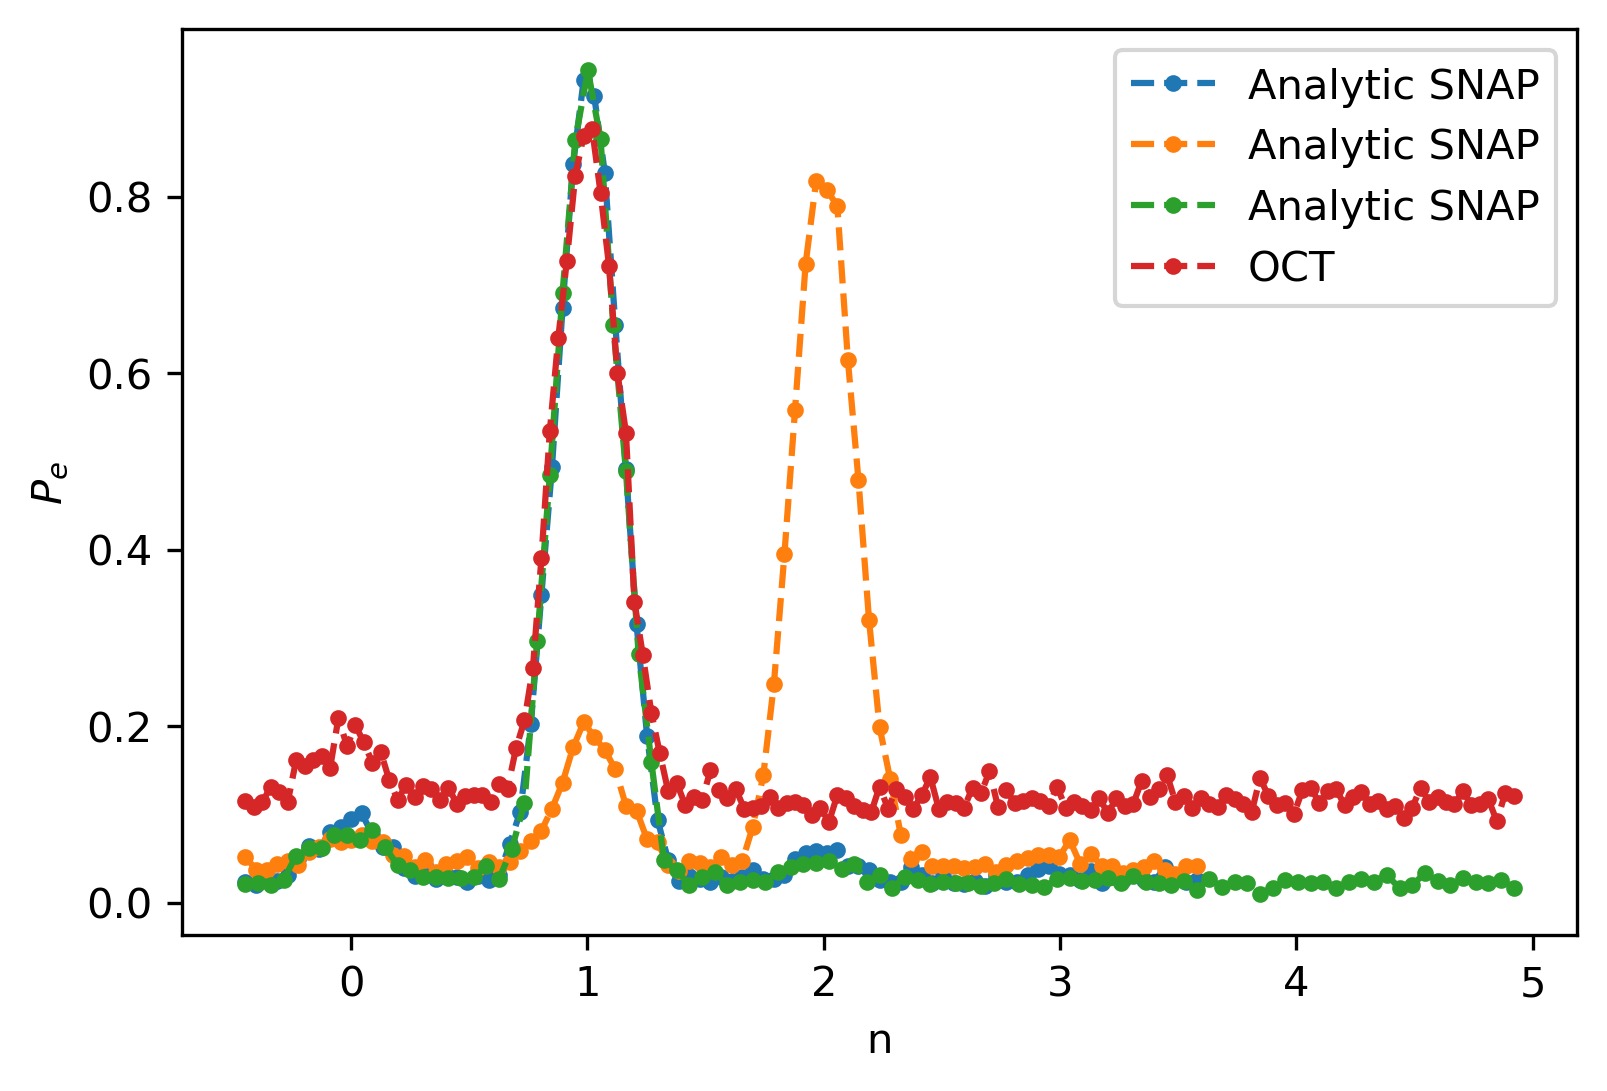

In [28]:
expt_name = 'snap_fock_prep'
filelist = [19, 20, 21]
two_chi = -1.118e6
cal = [0.9205, 0.002]
# 0.9205 0.002
plt.figure(dpi=300)
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
    Q = (Q-cal[1])/cal[0]
    plt.plot(freqs, Q, '.--', label='Analytic SNAP')
    print(np.max(Q))

expt_name = 'oct_fock'
filelist = [4]
two_chi = -1.118e6
cal = [0.9205, 0.002]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
    Q = (Q-cal[1])/cal[0]
    plt.plot(freqs, Q, '.--', label='OCT')
    print(np.max(Q))    
    
plt.xlabel('n')
plt.ylabel(r'$P_{e}$')
plt.legend(loc='best')
plt.show()

## Wigner Tomography

No handles with labels found to put in legend.


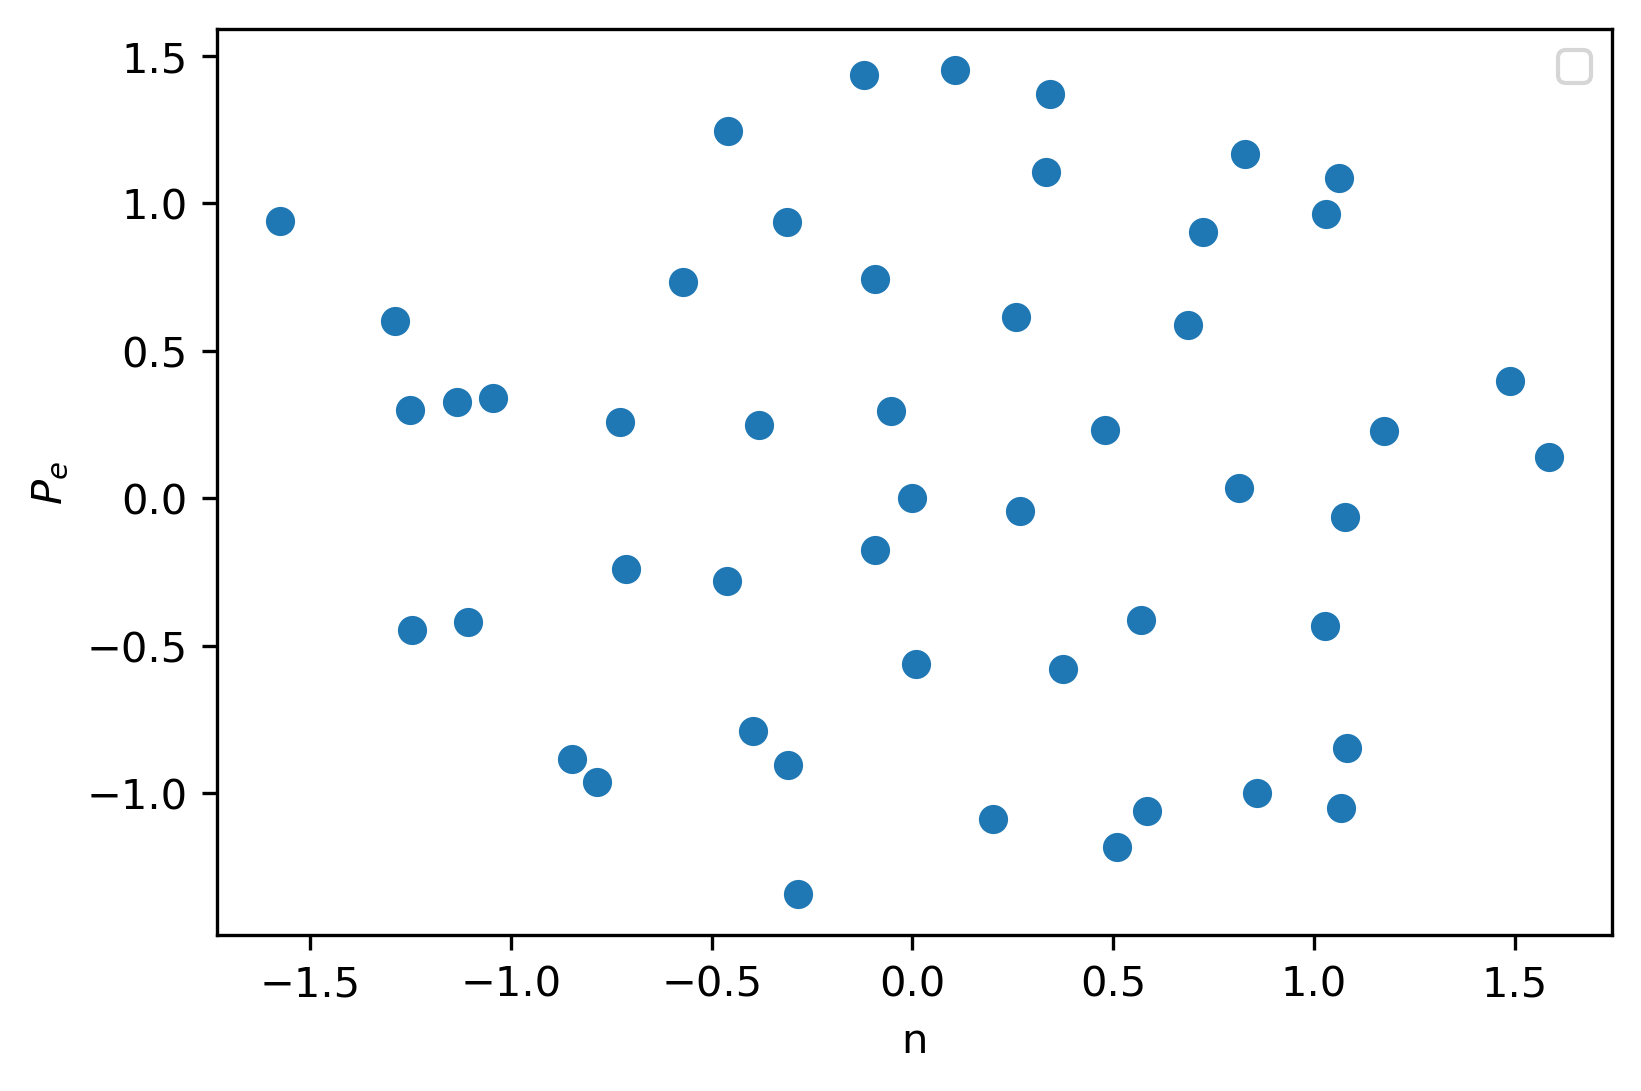

In [215]:
expt_name = 'wigner_tomo_binary_decomp'
filelist = [7]
two_chi = -1.118e6
cal = [0.9575, 0.019]
plt.figure(dpi=300)
# amp = [0.4, 0.35, 0.45]
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        Q = np.array(a['res'])[:]
        alpha_x = np.array(a['alphax'])[:]
        alpha_y = np.array(a['alphay'])[:]
        a.close()
        
    Q = (Q-cal[1])/cal[0]
        
#         plt.plot(freqs, Q, '.-', label='Amp = {}'.format(amp[ii]))
plt.xlabel('n')
plt.scatter(alpha_x, alpha_y)
plt.ylabel(r'$P_{e}$')
plt.legend(loc='best')
plt.show()

In [216]:
from scipy.linalg import expm

import matplotlib .pyplot as plt
import matplotlib .patches as mpatches
import numpy as np
from scipy.special import genlaguerre
from math import sqrt,factorial
from numpy.linalg import cond,svd
from scipy.optimize import fmin,check_grad,minimize
from IPython.display import display,clear_output
import time

Nmax = 100 # for numerical definition of displacement operator before exponentiation

class gen_wigner_tomography_analysis:
    
    def __init__(self,alphas,mode_state_num = 5,theta = pi,analytic=False):       
        self.alphas = alphas
        self.m = mode_state_num
        self.I  = (np.diag((1+0j)*ones(self.m), 0))
        self.Par =  (np.diag(np.exp(1j*pi*(np.arange(0, self.m))), 0))
        self.analytic = analytic
        self.theta = theta

    def Phase_op(self,theta):
        return ((np.diag(cos(theta*(np.arange(0, self.m))), 0)))
    
    def D(self,beta):
        M_m = np.diag(np.sqrt(np.arange(1, 100)), 1)
        M_p = np.diag(np.sqrt(np.arange(1, 100)), -1)
        return (expm(beta*M_p - conj(beta)*M_m))[:self.m,:self.m]

    def W_op(self,alpha):
        analytic = self.analytic
        if analytic:
            w = np.zeros((self.m,self.m),dtype=complex)
            B = 4*abs(alpha)**2
            pf = (2/np.pi)*np.exp(-B/2.0)
            for m in range(self.m):
                x = pf*real((-1)**m*genlaguerre(m, 0)(B))
                # x = pf*((-1)**m*genlaguerre(m, 0)(B))
                w[m, m] = x
                for n in range(m+1, self.m):
                    pf_nm = sqrt(factorial(m)/float(factorial(n)))
                    x = pf * pf_nm * (-1)**m * 2 * (2*alpha)**(n-m-1)*genlaguerre(m, n-m)(B)
                    if m > 0:
                        y = 8 * pf * pf_nm * (-1)**(m-1)*(2*alpha)**(n-m) *genlaguerre (m-1,n-m+1)(B)
                    w[m, n] = alpha * x
                    w[n, m] = (alpha * x). conj ()          
        else:  w  = 2/pi*dot(self.D(alpha),dot(self.Par,self.D(-alpha)))      
        return w
        
    def gen_W_op(self,theta,alpha):
        w  = 2/pi*dot(self.D(alpha),dot(self.Phase_op(theta),self.D(-alpha)))      
        return w
    
    def wigner_mat_and_grad(self,disps,FD,reshape=True):
        ND = len(disps)
        wig_tens = np.zeros((ND,FD,FD),dtype=complex)
        grad_mat_r = np.zeros((ND,FD,FD),dtype=complex)
        grad_mat_i = np.zeros((ND,FD,FD),dtype=complex)

        B = 4*abs(disps)**2
        pf = (2/np.pi)*np.exp(-B/2.0)
        for m in range(FD):
            x = pf*np.real((-1)**m*genlaguerre(m, 0)(B))
            term_r = -4*disps.real*x
            term_i = -4*disps.imag*x
            if m > 0:
                y = 8*pf*(-1)**(m-1)*genlaguerre(m-1, 1)(B)
                term_r += disps.real * y
                term_i += disps.imag * y
            wig_tens[:, m, m] = x
            grad_mat_r[:, m, m] = term_r
            grad_mat_i[:, m, m] = term_i

            for n in range(m+1, FD):
                pf_nm = sqrt( factorial (m)/float( factorial (n)))
                x = pf * pf_nm * (-1)**m * 2 * (2*disps)**(n-m-1) * genlaguerre (m, n-m)(B)
                term_r = ((n - m) - 4*disps.real*disps)*x
                term_i = (1j * (n - m) - 4*disps.imag*disps) * x
                if m > 0:
                    y = 8 * pf * pf_nm * (-1)**(m-1)*(2*disps)**(n-m) *genlaguerre (m-1, n-m+1)(B)
                    term_r += disps.real * y
                    term_i += disps.imag * y

                wig_tens [:, n, m] = disps * x
                wig_tens [:, m, n] = (disps * x). conj ()
                grad_mat_r [:, n, m] = term_r
                grad_mat_r [:, m,n] = term_r . conjugate ()
                grad_mat_i [:, n,m] = term_i
                grad_mat_i [:, m,n] = term_i . conjugate ()
        if reshape:return (wig_tens .reshape ((ND , FD**2)),grad_mat_r .reshape ((ND , FD**2)),grad_mat_i .reshape ((ND , FD**2)))
        else:return (wig_tens,grad_mat_r,grad_mat_i)


    def curlyM(self):
        analytic=self.analytic
        if analytic:
            if self.theta ==pi:
                curlyM, gcurlyMx, gcurlyMy = self.wigner_mat_and_grad(self.alphas,self.m,reshape=True)
            else:print("No analytic expression for arb theta")
        else:
            M_mat = array([self.gen_W_op(self.theta,alpha) for alpha in self.alphas])
            curlyM = array([transpose(m).flatten() for m in M_mat])
        return curlyM

    def curlyMinv(self):
        curlyM_inv = linalg.pinv(self.curlyM())
        
        return curlyM_inv
    
    def rho_pinv(self,w_vec):
        self.x = w_vec
        curlyM_inv = linalg.pinv(self.curlyM())
        rho_vec = dot(curlyM_inv,self.x)
        rho = rho_vec.reshape(self.m,self.m)
        return rho
    
    def rho_pinv2(self,w_vec):
        self.x = w_vec
        curlyM_inv2 = dot(pinv(dot((transpose(self.curlyM())),self.curlyM())),(transpose(self.curlyM())))
        rho_vec = dot(curlyM_inv2,self.x)
        rho = rho_vec.reshape(self.m,self.m)
        return rho
    
    
    def extracted_W(self,rho,alphaxs,alphays):
        return array([[trace(dot(self.W_op(alphax + 1j*alphay),rho)) 
                            for alphax in alphaxs] for alphay in alphays])
    
    
    def extracted_W_single(self,rho,alpha):
        return trace(dot(self.W_op(alpha),rho))

    
    def expect_gen_W(self,theta,rho,alphaxs,alphays):
        return array([[trace(dot(self.gen_W_op(theta,alphax + 1j*alphay),rho)) 
                            for alphax in alphaxs] for alphay in alphays])
    
    def expect_gen_W_single(self,theta,rho,alpha):
        return trace(dot(self.gen_W_op(theta,alpha),rho))
    
    
    def extracted_W_single_analytic(self,rho,disps,FD):
        W,gWx,gWy = self.wigner_mat_and_grad(disps,FD,reshape=False)
        
        return array([trace(dot(w,rho)) for w in W])
        
    def rho_pinv_trace_1(self,w_vec):

        rho = np.zeros((self.m,self.m),dtype=complex)
        self.x = w_vec
        i_vec = self.I.flatten()
        
        A = zeros([self.m**2+1, self.m**2+1],dtype=complex)
        A[:self.m**2,:self.m**2] = dot((transpose(self.curlyM())),self.curlyM())
        A[self.m**2,self.m**2], A[self.m**2][:self.m**2], A.T[self.m**2][:self.m**2] = 0,i_vec,i_vec
        vec_b = ones([self.m**2+1],dtype=complex)

        vec_b[:self.m**2] = dot(transpose(self.curlyM()),w_vec)
        rho_vec = dot(pinv(A),vec_b)[:self.m**2]
        rho = rho_vec.reshape(self.m,self.m)
        return (rho)

    def rho_pinv_positive_sd(self,w_vec):

        rho = self.rho_pinv_trace_1(w_vec)
        l,v = eig(rho)
        ls_index = sorted(range(len(l)), key=lambda k: l[k],reverse=True)
        ls = sorted(l,reverse=True)
        lps = self.positive_semidefinite_eigs(ls)
        vs = array([v.T[i] for i in ls_index]).T
        rho_new = dot((array(vs)),dot(diag(lps,0),array(vs).T.conj()))
        return (rho_new)   
    
    def positive_semidefinite_eigs(self,vs):
        a = 0
        d = len(vs)
        vout = array(zeros(d))
        vout = vs
        for i in sorted(range(d),reverse=True):
            if (vs[i] +a/(i+1) < 0):
                a = a + vs[i]
                vout[i] = 0
            else:break
#         try:vout[:i+1] = vs[:i+1] + a/(i+1)
#         except:print ("positive semidefinite errors")
            
        if i!= d-1:
            vout[:i+1] = vs[:i+1] + a/(i+1)
#         except:print ("positive semidefinite errors")
                
        return(vout)
    
print("done")

done


50
Trace =  (0.9999999999999999+1.6509752444669854e-16j)
0 population:  (0.04617173636411511+1.1058862159352145e-17j)
1 population:  (0.836246847286366+1.3980220361784136e-16j)
2 population:  (0.07085137913655025+5.89534931288993e-18j)
sum 0 + 1:  (0.8824185836504811+1.508610657771935e-16j)


<ipython-input-219-17036731ded1>:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax2.pcolormesh(arange(mode_state_num),arange(mode_state_num),real(rho),cmap = 'RdBu_r',vmin = 0,vmax = 1)
<ipython-input-219-17036731ded1>:57: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax2.pcolormesh(arange(mode_state_num),arange(mode_state_num),imag(rho),cmap = 'RdBu_r',vmin = 0,vmax = 1)
<ipython-input-219-17036731ded1>:63: MatplotlibDeprecationWarning: shading='

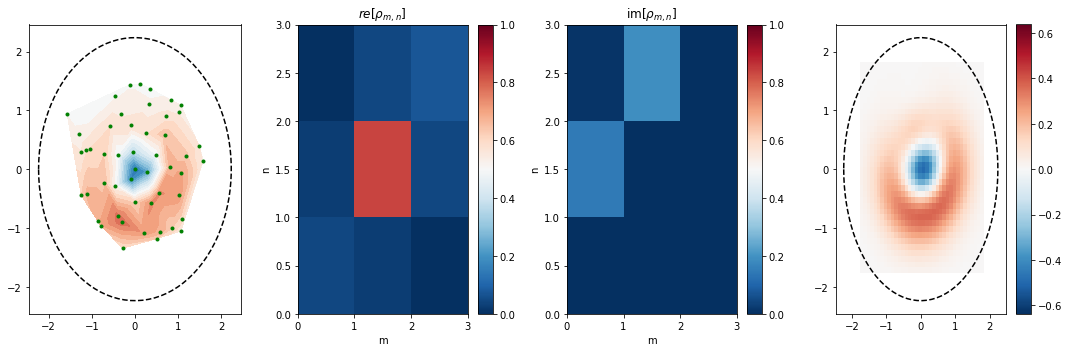

In [219]:
expt_name = 'wigner_tomo_binary_decomp'
filelist = [8]  # 190 is g0 for normalization
mode_state_num = 4

one_pops_snap = []

for ii,i in enumerate(filelist[:]):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        Ps = np.array(a['res'])
        Ws = -2/np.pi*(2*Ps-1)
        x = np.array(a['alphax'])[:]
        y = np.array(a['alphay'])[:]

        alphas = x+1j*y
                
        print(len(Ps))
        alphas2 = arange(-np.sqrt(7)/np.sqrt(2)+0.1,np.sqrt(7)/np.sqrt(2),0.1)
    
        w = gen_wigner_tomography_analysis(alphas, mode_state_num=mode_state_num,analytic=True)

        fig1 = plt.figure(figsize=(15,5))

        
        W = Ws 
        
        ax1 = fig1.add_subplot(141)
#         ax1.tripcolor(x,y,W)
        tcf = ax1.tricontourf(x, y, W, np.linspace(-2/np.pi, 2/np.pi, 30), cmap='RdBu_r')
        ax1.plot(x, y, 'g. ')
        r = sqrt(5)
        th = linspace(-3.14, 3.14, 100)
        ax1.plot(r*np.cos(th),r*np.sin(th),'k--')

        rho = w.rho_pinv_positive_sd(W)
#             rho = w.rho_pinv(W)
#         print(Qobj(rho))
        print ("Trace = ",trace(rho))
#         print (eig(rho)[0])
#         print (array([rho[i][i] for i in range(mode_state_num)]))
        print("0 population: ", rho[0][0])
        print("1 population: ", rho[1][1])
        one_pops_snap.append(rho[1][1])
        print("2 population: ", rho[2][2])
        print("sum 0 + 1: ", rho[0][0] + rho[1][1])

#         P_ns.append([rho[i][i] for i in range(mode_state_num)])

        ax2 = fig1.add_subplot(142,title ='$re[\\rho_{m,n}$]')
        c = ax2.pcolormesh(arange(mode_state_num),arange(mode_state_num),real(rho),cmap = 'RdBu_r',vmin = 0,vmax = 1)   
        ax2.set_ylabel('n')
        ax2.set_xlabel('m')
        fig1.colorbar(c,ax=ax2)
        ax2 = fig1.add_subplot(143,title ='im[$\\rho_{m,n}$]')
        c = ax2.pcolormesh(arange(mode_state_num),arange(mode_state_num),imag(rho),cmap = 'RdBu_r',vmin = 0,vmax = 1)   
        ax2.set_ylabel('n')
        ax2.set_xlabel('m')
        fig1.colorbar(c,ax=ax2)
        ax3 = fig1.add_subplot(144)
#             dx = (alphas2[1]-alphas2[0])
        c = ax3.pcolormesh(alphas2,alphas2,real(w.extracted_W(rho,alphas2,alphas2)),cmap = 'RdBu_r',vmin = -2/np.pi,vmax = 2/np.pi)
        r = sqrt(5)
        th = linspace(-3.14,3.14,100)
        ax3.plot(r*cos(th),r*sin(th),'k--')
        ax3.set_ylim
        fig1.colorbar(c,ax=ax3)

        fig1.tight_layout()

In [276]:
rho

array([[ 0.04617174+1.10588622e-17j,  0.02369809-1.45349815e-01j,
        -0.01141712-9.89324731e-03j,  0.01519619-1.15598669e-02j],
       [ 0.02369809+1.45349815e-01j,  0.83624685+1.39802204e-16j,
         0.04455683-1.88126910e-01j,  0.06035717+4.98924476e-02j],
       [-0.01141712+9.89324731e-03j,  0.04455683+1.88126910e-01j,
         0.07085138+5.89534931e-18j, -0.01534859+3.81137077e-03j],
       [ 0.01519619+1.15598669e-02j,  0.06035717-4.98924476e-02j,
        -0.01534859-3.81137077e-03j,  0.04673004+8.34110936e-18j]])

## OCT Pulse

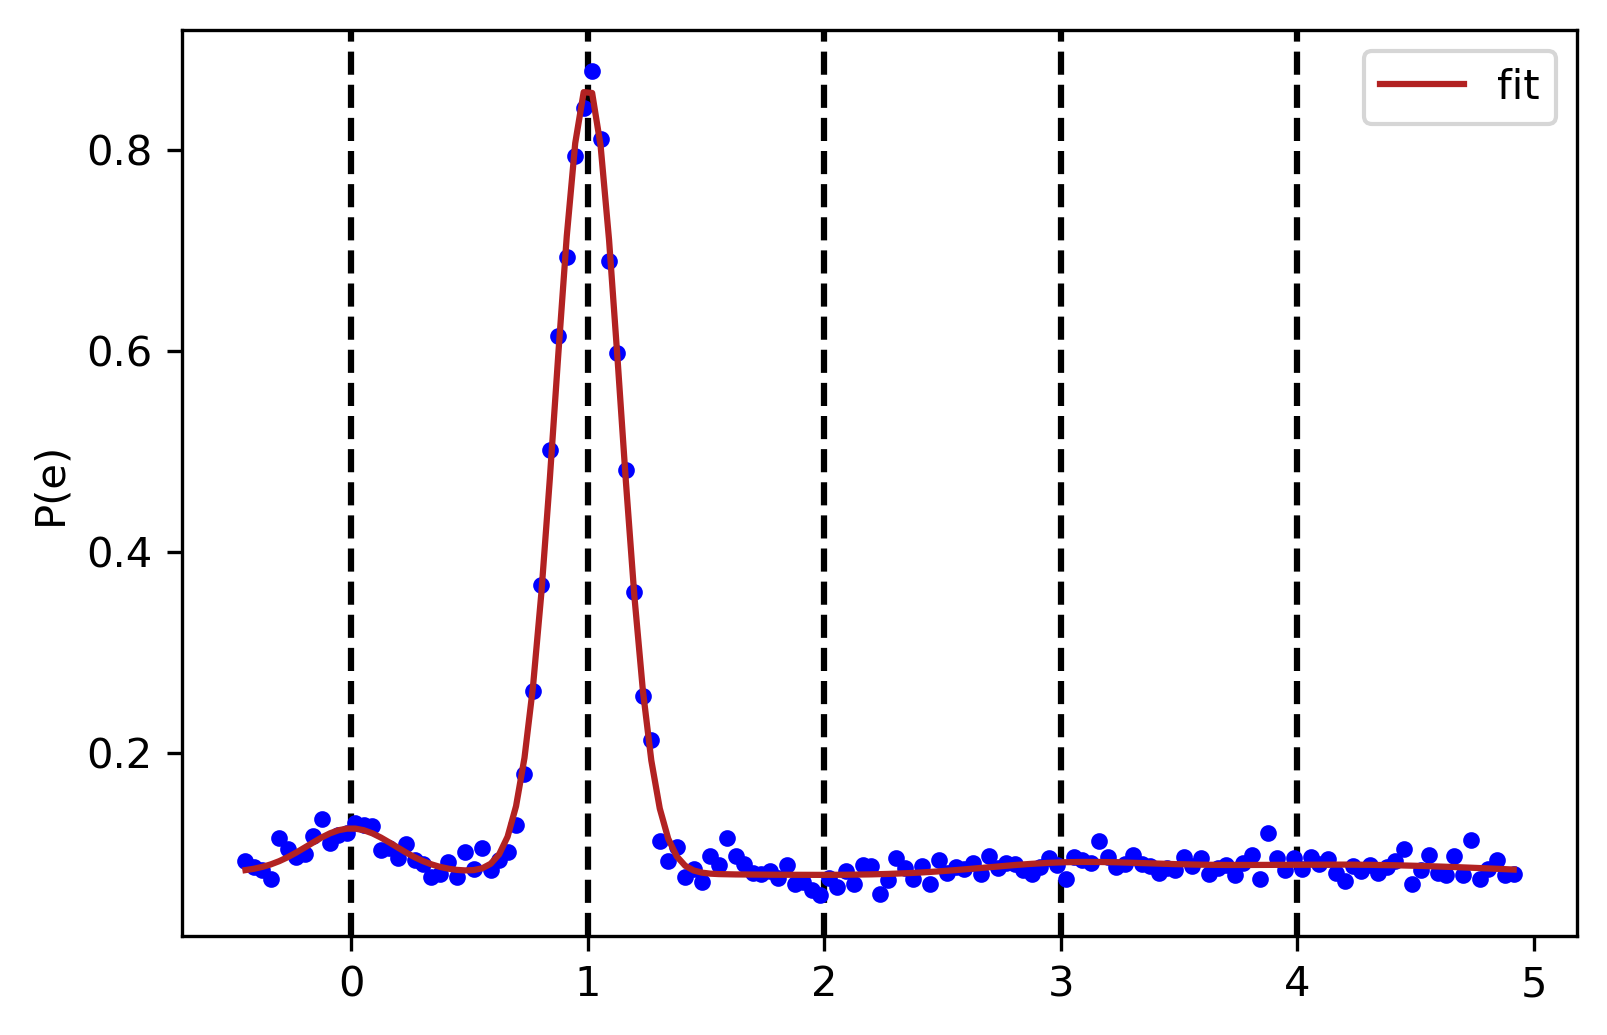

In [311]:
expt_name = 'oct_fock'
filelist = [2]

N = 5
contrast = [0.9525, 0.013]

two_chi_meas = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        two_chi = a['two_chi']
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
        x = freqs
        """Scaling the probability values with g and e"""
        y = (Q - contrast[1])/contrast[0]
        
        plt.figure(dpi=300)

        for j in range(N):
            plt.axvline(x=j, linestyle='--', color='k')
        plt.plot(x, y, '.', color='b') 
        
        fitparams = np.zeros(3*N+1)
        fitparams[0] = 0

        for kk in range(N):
            fitparams[3*kk+1] = max(y)
            fitparams[3*kk+2] = kk
            fitparams[3*kk+3] = 0.3

        p1, p2 = fitgausssum_with_baseline(x, y, fitparams=fitparams)
        
        plt.plot(x[::-1], gaussfuncsum_with_baseline(x[::-1], *p1), 'firebrick', label='fit')
        peak_val, freq_val = fitamp(p1)        

        plt.ylabel('P(e)')
        plt.legend(loc='best')
        plt.show()

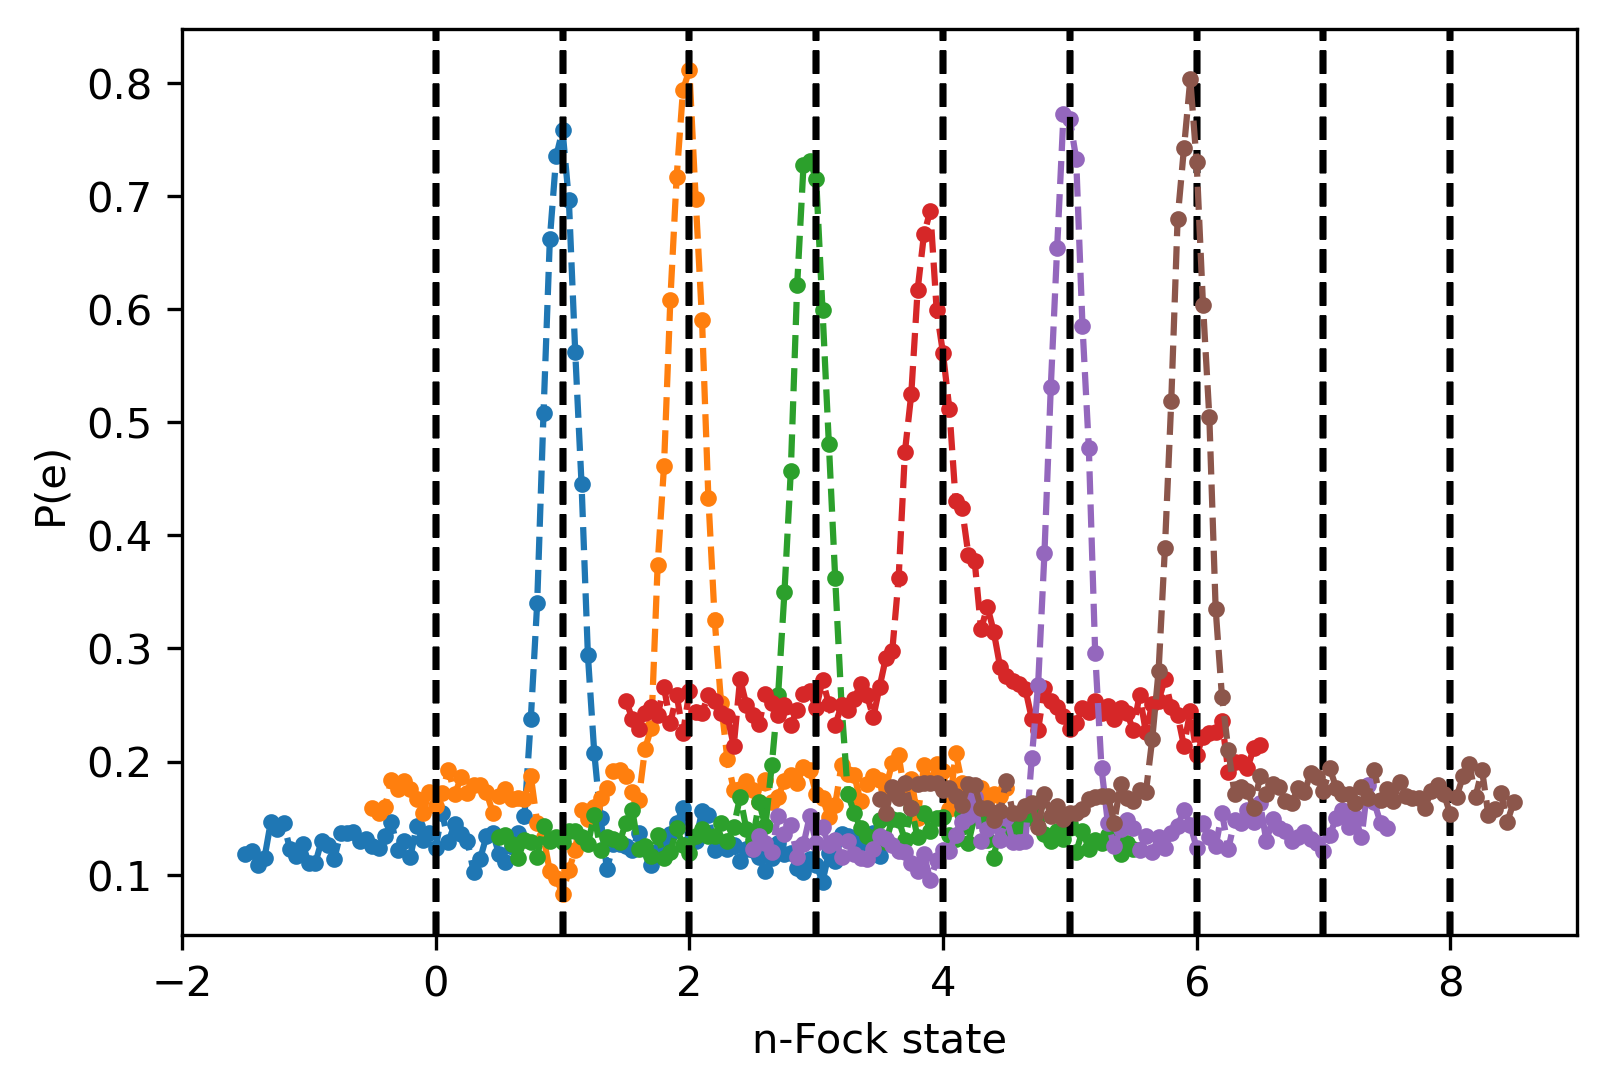

In [298]:
expt_name = 'fock_state_oct'
filelist = np.arange(7, 13, 1)

N = 9
# contrast = [0.9525, 0.013]

two_chi_meas = []
plt.figure(dpi=300)

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        I = np.array(a['I'])[:]
        Q = np.array(a['Q'])[:]
        two_chi = a['two_chi']
        freqs = (np.array(a['freq'])/1e9)[:]*1e9/two_chi
        a.close()
        x = freqs
        """Scaling the probability values with g and e"""
        y = Q
        

        for j in range(N):
            plt.axvline(x=j, linestyle='--', color='k')
        plt.plot(x, y, '.--') 
        
        fitparams = np.zeros(3*N+1)
        fitparams[0] = 0

        for kk in range(N):
            fitparams[3*kk+1] = max(y)
            fitparams[3*kk+2] = kk
            fitparams[3*kk+3] = 0.3

#         p1, p2 = fitgausssum_with_baseline(x, y, fitparams=fitparams)
        
#         plt.plot(x[::-1], gaussfuncsum_with_baseline(x[::-1], *p1), 'firebrick', label='fit')
#         peak_val, freq_val = fitamp(p1)        

plt.ylabel('P(e)')
plt.xlabel('n-Fock state')
# plt.legend(loc='best')
plt.show()